In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import gc
import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


2024-11-15 18:06:26.192890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731690386.207060  117081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731690386.211080  117081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 18:06:26.225054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(632, 51)
(622, 236)
(806, 151)
(1063, 51)
(837, 238)
(654, 51)
(585, 236)
(960, 131)
(855, 131)
(577, 236)
(679, 151)
(1429, 131)
(1583, 131)
(1170, 236)
(966, 51)
(1527, 131)
(841, 41)
(2003, 131)
(843, 238)
(859, 236)
(706, 131)
(1226, 131)
(880, 131)
(779, 131)
(695, 131)
(778, 51)
(636, 237)
(653, 131)
(1045, 131)
(925, 71)
(793, 236)
(718, 238)
(782, 236)
(2122, 131)
(1279, 131)
(1632, 131)
(941, 238)
(537, 236)
(1796, 101)
(890, 237)
(823, 131)
(1503, 131)
(1675, 131)
(861, 151)
(681, 236)
(1147, 51)
(755, 131)
(608, 238)
(1480, 237)
(2268, 131)
(1045, 181)
(1023, 51)
(1418, 238)
(691, 236)
(735, 131)
(655, 236)
(1139, 181)
(921, 131)
(673, 236)
(645, 238)
(1074, 131)
(908, 51)
(957, 131)
(877, 40)
(1297, 131)
(951, 131)
(1594, 131)
(799, 131)
(776, 236)
(971, 237)
(1675, 131)
(1178, 237)
(2072, 131)
(898, 51)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


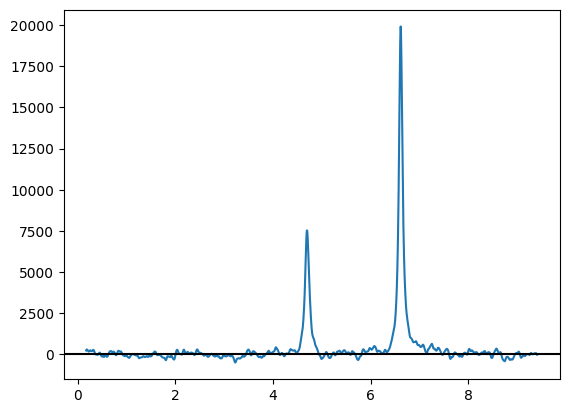

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

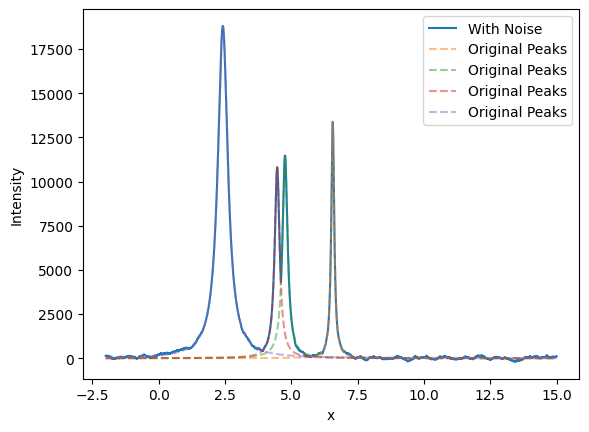

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        
        metabolism_gamma = np.random.uniform(0.05, 0.3)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, df.max().max())  # Random height
        peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

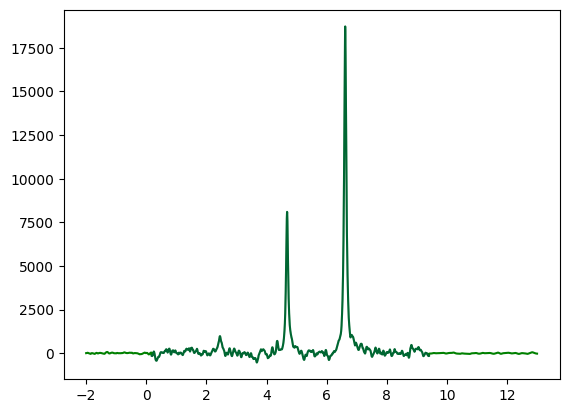

(3686, 2)


,x,y
0,-2.000000,9.042592
1,-1.995927,9.435920
2,-1.991855,10.258024
3,-1.987782,11.596524
4,-1.983710,13.494756
...,...,...
3681,12.983526,-16.943491
3682,12.987599,-17.752363
3683,12.991671,-18.364680
3684,12.995744,-18.774494


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 13, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, [0, 2]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

# Step 3: Bring data to same shape

(3000, 2)


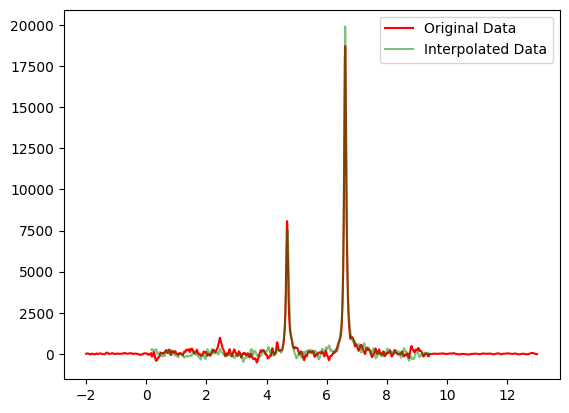

In [9]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [10]:
df_interpolated.shape

(3000, 2)

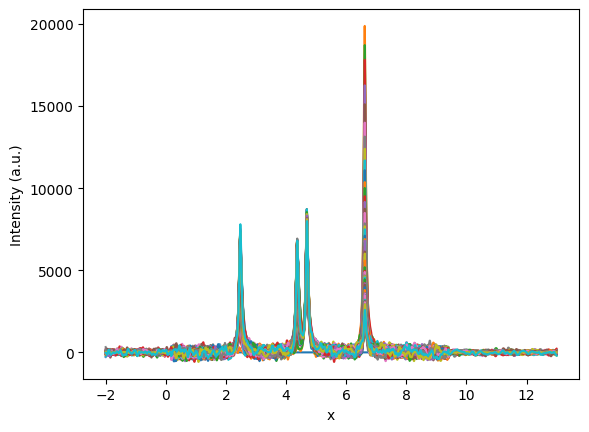

In [11]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [12]:

num_samples = 5000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

x_data shape: torch.Size([5000, 3000])
data shape: torch.Size([5000, 3000])
x_params_tensor shape: torch.Size([5000, 4])
gamma_params_tensor shape: torch.Size([5000, 4])
height_params_tensor shape: torch.Size([5000, 4])
target shape: torch.Size([5000, 12])




/tmp/ipykernel_117081/809751612.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


In [13]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([5000, 3000])
Before Scaling: torch.Size([5000, 12])
After Reshaping: torch.Size([5000, 3000])
After Reshaping: torch.Size([5000, 12])
After Scaling: (5000, 3000)
After Scaling: (5000, 12)


In [14]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([3000, 3000])
Data Val Shape: torch.Size([1000, 3000])
Data Test Shape: torch.Size([1000, 3000])
Target Train Shape: torch.Size([3000, 12])
Target Val Shape: torch.Size([1000, 12])
Target Test Shape: torch.Size([1000, 12])


# LSTM 

In [15]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [16]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([3000, 3000]) torch.Size([3000, 12])


# Conv1D

In [17]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [18]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512,
                 #fc2_output = 512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        # self.fc2 = nn.Sequential(
        #     nn.Linear(fc1_output, fc2_output),
        #     nn.LeakyReLU(),
        #     nn.Dropout(p=dropout_prob)
        # )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):

        # Erweitern der Eingabe für MaxPool1d
        x = x.unsqueeze(1)  # Form: (batch_size, 1, sequence_length)
        x = self.pooling(x)
        x = x.squeeze(1)    # Zurück zu (batch_size, sequence_length)

        x = self.fc1(x)
        # x = self.fc2(x)
        output = self.output(x)
        return output


    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [20]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [21]:
def my_loss(df, model, random=True, i=3, device='cpu', weight=0.01):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.cpu().numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values

    max_lorentz = max_lorentz.clone().detach().requires_grad_(True).to(device)


    # del lorentz_tensor, x0_parms_real, gamma_parms_real, height_parms_real, target_real_pred, y_real_tensor
    # torch.cuda.empty_cache()

    # Squeeze from shape (1, 3000) to shape (3000,)
    y_real_tensor = y_real_tensor.squeeze(0)

    # Compute MSE using PyTorch
    mse_loss = torch.mean((max_lorentz - y_real_tensor)**2) + torch.mean(y_real_tensor * weight)
    #mse = torch.nn.functional.mse_loss(max_lorentz, y_real_tensor)
    #print(mse_loss, mse_loss.shape, mse_loss.dtype)
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()
    return mse_loss




In [22]:


# # ------------------------------------
# import torch

# def get_model_size(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
#     size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
#     return total_params, size_in_megabytes


# df = pd.read_csv(path_list[0]) 

# dropout_results = [] # storing the results of the dropout experiment
# optuna_results = [] # storing the results of the optuna experiment

# def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

#     # Set device to GPU if available
#     if torch.cuda.is_available():
#         device = torch.device('cuda')
#     else:
#         device = torch.device('cpu')

#    # device = torch.device('cpu')

#     # Move data and model to device
#     X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
#     model.to(device)

#     # Initialize best metrics and model
#     best_eval_metric_val = float('inf') # Initialize the best_eval_metric
#     best_val_loss = float('inf') # Initialize the best_val_loss
#     best_real_metric_val = float('inf')
#     best_train_loss = float('inf')
#     best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
#     patience_counter_loss = 0  # Early stopping counter
#     patience_counter_metric = 0  # Early stopping counter

#     # DataLoader for batching
#     train_dataset = TensorDataset(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


#     # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
#     train_losses, val_losses = [], [] # to visualize the drop_out_prob
#     train_accuracies, val_accuracies = [], []
#     real_accuracies = []
#     # Training Loop
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0

#         # Training loop
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

            
            
#             #print(data.shape, target.shape)
#             optimizer.zero_grad()  # Clear gradients
#             outputs = model(data)  # Forward pass
#             #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

#             # FOR LSTM
#             loss = criterion(outputs, target)  # Calculate loss # For LSTM
#             #print(loss)
#             loss_real = my_loss(df, model, random=True, device=device)
            
#             loss_real.backward()  # Backpropagation
#             optimizer.step()  # Update weights

#             epoch_loss += loss_real # Accumulate batch loss

#         # Validation
#         model.eval()
#         with torch.no_grad():
            
#             val_outputs = model(X_val)  # Forward pass
#             #loss_val = criterion(val_outputs.squeeze(1), y_val)
#             # FOR LSTM
#             loss_val = criterion(val_outputs, y_val)
#             #scheduler.step(loss_val)  # Adjust learning rate based on loss
            
#             # calculate the training mase
#             predictions_train = model.predict(X_train)
            
#             mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

#             # Calculate validation mase
#             predictions_val = model.predict(X_val)
#             mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

#             # Calculate the mse of real data
#             mse_real = calculate_mse_of_real_data(df, model, random=True)
#             loss_train = epoch_loss / len(train_loader)

#             # Log to TensorBoard
#             if log_tensorboard:
#                 writer.add_scalars("Loss", {"train": loss_train}, epoch)
#                 writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
#                 writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
#                 for name, param in model.named_parameters():
#                     if param.grad is None:
#                         print(f"Gradient is None for {name}")

#                 try:
#                     for name, param in model.named_parameters():
#                         writer.add_histogram(f"{name}/grad", param.grad, epoch)
#                         writer.add_histogram(f"{name}/value", param, epoch)
#                 except:
#                     pass
#                 writer.flush()
            
            

#             if loss_train < best_train_loss:
#                 best_train_loss = loss_train
#                 patience_counter_loss = 0
#             else:
#                 patience_counter_loss += 1

#             # # Early stopping if loss_val is increasing
#             # if loss_val < best_val_loss:
#             #     best_val_loss = loss_val  # Update best val_loss
#             #     patience_counter_loss = 0  # Reset patience counter
#             # else:
#             #     patience_counter_loss += 1  # Increment if no improvement

#             # Early Stopping based on if val_mse is not increasing
#             if mse_val < best_eval_metric_val:
#                 best_eval_metric_val = mse_val
#                 #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#                 patience_counter_metric_val = 0  # Reset patience counter if improved
#             else:
#                 patience_counter_metric_val += 1

#             # early stopping if real_mse is increasing
#             if mse_real < best_real_metric_val:
#                 best_real_metric_val = mse_real
#                 best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#             else:
#                 patience_counter_metric += 1

#             if check_real_data:
#                 train_losses.append(loss_train)
#                 val_losses.append(loss_val)
#                 train_accuracies.append(mse_train)
#                 val_accuracies.append(mse_val)
#                 real_accuracies.append(mse_real)



#             # Early stopping check
#             if (patience_counter_loss >= patience):
#                 print(f"Early stopping at epoch {epoch+1}, wit train loss: {loss_train}")
#                 break


#         # Print status
#         if verbose:
#           if epoch % 19 == 0:
#             print(f"| Epoch {epoch+1} | Train Loss: {loss_train:.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")



        
#     optuna_results.append({'dropout_prob': dropout_prob,
#                             'train_loss': min(train_losses),
#                             'val_loss': min(val_losses),
#                             'training_MSE': min(train_accuracies),
#                             'validation_MSE': min(val_accuracies),
#                             'real_data_MSE': mse_real
#                             })

            


#     dropout_results.append({'dropout_prob': dropout_prob,
#                                     'train_loss': train_losses,
#                                     'val_loss': val_losses,
#                                     'training_MSE': train_accuracies,
#                                     'validation_MSE': val_accuracies
#                                     })
#     # Load the best model
#     model.load_state_dict(best_model)
#     print(f"Best validation MSE: {best_eval_metric_val:.4f}")
#     if check_real_data:
#         print(f'MSE Real Data: {mse_real}')

#     writer.close()
#     # del loss_real
#     # torch.cuda.empty_cache()
#     # gc.collect()
#     # torch.cuda.empty_cache()
#     return model, optuna_results




# #%tensorboard --logdir=runs


# # Data preparation: ensure data shapes are correct
# data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
# data_val_tensor = data_val_tensor.reshape(-1, 3000)

# # Check shapes before training
# print("Train shape:", data_train_tensor.shape)
# print("Validation shape:", data_val_tensor.shape)

# #Define model with correct input size
# # input_size = 3000
# # hidden_size = 512
# # output_size = len(substrates_list) * 3
# # dropout_prob = 0.1
# # learning_rate = 0.01
# # epochs = 100

# # model = NeuralNetwork().to(device)
# # model_size, model_size_mb = get_model_size(model)
# # print(f'Total parameters: {model_size}')
# # print(f'Model size: {model_size_mb:.2f} MB')

# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # criterion = torch.nn.MSELoss()

# # writer = SummaryWriter()

# # trained_model, _ = training(model=model,
# #                          X_train=data_train_tensor,
# #                          y_train=target_train_tensor,
# #                          X_val=data_val_tensor,
# #                          y_val=target_val_tensor,
# #                          criterion=criterion,
# #                          optimizer=optimizer,
# #                          epochs=epochs,
# #                          writer=writer,
# #                          dropout_prob=dropout_prob,
# #                          log_tensorboard=True,
# #                          verbose=True,
# #                          check_real_data=True)


In [23]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import pandas as pd

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1, kernel_size=2, stride=1, padding=1):
        super(NeuralNetwork, self).__init__()
        self.pooling = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for MaxPool1d
        x = self.pooling(x).squeeze(1)  # Remove channel dimension
        x = self.fc1(x)
        return self.output(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Custom loss function for real data
def calculate_mse_of_real_data(df, model, random=True, i=3, tensor=False):
    if random:
        i = np.random.randint(1, df.shape[1])
    df_fill = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)
    target_real_pred = model.predict(y_real_tensor)
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)
    x0, gamma, height = np.split(target_real_pred, 3, axis=1)

    lorentz_df = pd.DataFrame({'x': x_real})
    for i, (x0_val, gamma_val, height_val) in enumerate(zip(x0[0], gamma[0], height[0])):
        lorentz = lorentzian(x_real, x0_val, gamma_val, height_val)
        lorentz_df[f'lorentz_{i}'] = lorentz
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    return mean_squared_error(y_real, lorentz_df['max'])

# Training function
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, df, writer=None, batch_size=64, patience=20, log_tensorboard=True, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    best_train_losss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = my_loss(df, model, device=device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            #val_loss = criterion(val_outputs, y_val)
            #scheduler.step(val_loss)
            #mse_real = calculate_mse_of_real_data(df, model)
        
        if log_tensorboard and writer:
            writer.add_scalars("Loss", {"Train": train_loss}, epoch)
            #writer.add_scalars("MSE", {"Real Data": mse_real}, epoch)

        if loss < best_train_losss:
            best_train_losss = loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, with loss: {loss}")
            break

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | | Real MSE: ")

    model.load_state_dict(best_model_state)
    return model, loss

# Utility to compute model size
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_mb = total_params * 4 / (1024 ** 2)  # Assuming 32-bit (4 bytes) floats
    return total_params, size_in_mb

# Example usage
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Ensure correct shape
data_val_tensor = data_val_tensor.reshape(-1, 3000)

model = NeuralNetwork(input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, _ = train_model(
    model, 
    data_train_tensor, 
    target_train_tensor, 
    data_val_tensor, 
    target_val_tensor, 
    criterion, 
    optimizer, 
    epochs=50, 
    df=df, 
    writer=None, 
    verbose=True
)

model_size, model_size_mb = get_model_size(model)
print(f"Model Parameters: {model_size}, Size: {model_size_mb:.2f} MB")


Epoch 1/50 | Train Loss: 0.2640 | | Real MSE: 
Epoch 11/50 | Train Loss: 0.2958 | | Real MSE: 
Epoch 21/50 | Train Loss: 0.2379 | | Real MSE: 
Early stopping at epoch 24, with loss: 0.21911686658859253
Model Parameters: 1550875, Size: 5.92 MB


In [24]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [25]:
data_train_tensor.shape

torch.Size([3000, 3000])

In [26]:
import optuna
import gc

def objective(trial):
    # Suggest hyperparameters
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.9, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 4, data_train_tensor.shape[1], step=4)
    fc1_output = trial.suggest_int('fc1_output', 10, 3000, step=10)
    fc2_output = trial.suggest_int('fc2_output', 10, 3000, step=10)

    kernel_size = trial.suggest_int('kernel_size',6, 200, step=1)
    stride = trial.suggest_int('stride',1, 2, step=1)
    padding = trial.suggest_int('padding',1, 3, step=1)
    
    # Initialize model and optimizer
    model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        #fc2_output=fc2_output,
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding = padding
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = torch.nn.MSELoss()
    writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
    try:
        # Train the model
        trained_model, loss = train_model(
            model=model,
            X_train=data_train_tensor,
            y_train=target_train_tensor,
            X_val=data_val_tensor,
            y_val=target_val_tensor,
            criterion=criterion,
            optimizer=optimizer,
            epochs=1000,
            writer=writer,
            #dropout_prob=dropout_prob,
            log_tensorboard=True,
            verbose=False,
            #check_real_data=True,
            batch_size=batch_size,
            df=df
        )
        
        



        
    finally:
        # Cleanup
        writer.close()
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()  # Free unused memory
        #torch.cuda.synchronize()  # Ensure all computations are finished

    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)  # Run for 20 trials (adjust as needed)


/home/generalpegasus/Documents/VirtualEnvirnoments/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-15 18:06:51,063] A new study created in memory with name: no-name-d8fa2de3-af6e-4e23-a7d6-3eefd8cf2b36
[I 2024-11-15 18:06:52,112] Trial 0 finished with value: 0.27032411098480225 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00014472100325409388, 'batch_size': 812, 'fc1_output': 200, 'fc2_output': 600, 'kernel_size': 52, 'stride': 2, 'padding': 3}. Best is trial 0 with value: 0.27032411098480225.


Early stopping at epoch 36, with loss: 0.27032411098480225


[I 2024-11-15 18:06:52,683] Trial 1 finished with value: 0.2068585604429245 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.058136861707871e-07, 'batch_size': 1560, 'fc1_output': 450, 'fc2_output': 2370, 'kernel_size': 121, 'stride': 1, 'padding': 2}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 22, with loss: 0.2068585604429245


[I 2024-11-15 18:06:53,596] Trial 2 finished with value: 0.22127023339271545 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001706887216438806, 'batch_size': 2276, 'fc1_output': 1970, 'fc2_output': 1810, 'kernel_size': 178, 'stride': 2, 'padding': 1}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 31, with loss: 0.22127023339271545


[I 2024-11-15 18:06:55,004] Trial 3 finished with value: 0.21287944912910461 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0016303696806819464, 'batch_size': 1552, 'fc1_output': 2670, 'fc2_output': 870, 'kernel_size': 44, 'stride': 2, 'padding': 3}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 70, with loss: 0.21287944912910461


[I 2024-11-15 18:06:57,762] Trial 4 finished with value: 0.23385661840438843 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005381601087281331, 'batch_size': 924, 'fc1_output': 1840, 'fc2_output': 1840, 'kernel_size': 119, 'stride': 1, 'padding': 1}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 68, with loss: 0.23385661840438843


[I 2024-11-15 18:06:58,381] Trial 5 finished with value: 0.20701783895492554 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.001861617285773988, 'batch_size': 1804, 'fc1_output': 1990, 'fc2_output': 2170, 'kernel_size': 20, 'stride': 1, 'padding': 2}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 21, with loss: 0.20701783895492554


[I 2024-11-15 18:06:59,030] Trial 6 finished with value: 0.20922726392745972 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0004305556600239617, 'batch_size': 1524, 'fc1_output': 1970, 'fc2_output': 1760, 'kernel_size': 11, 'stride': 2, 'padding': 3}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 33, with loss: 0.20922726392745972


[I 2024-11-15 18:06:59,835] Trial 7 finished with value: 0.28693440556526184 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00852045539216907, 'batch_size': 2308, 'fc1_output': 150, 'fc2_output': 2720, 'kernel_size': 134, 'stride': 2, 'padding': 3}. Best is trial 1 with value: 0.2068585604429245.


Early stopping at epoch 38, with loss: 0.28693440556526184


[I 2024-11-15 18:07:01,202] Trial 8 finished with value: 0.19429273903369904 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.146763073874383e-07, 'batch_size': 2816, 'fc1_output': 690, 'fc2_output': 790, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 37, with loss: 0.19429273903369904


[I 2024-11-15 18:07:02,944] Trial 9 finished with value: 0.219682976603508 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00044308559949502813, 'batch_size': 420, 'fc1_output': 930, 'fc2_output': 1120, 'kernel_size': 78, 'stride': 2, 'padding': 3}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 38, with loss: 0.219682976603508


[I 2024-11-15 18:07:03,860] Trial 10 finished with value: 0.2153879851102829 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.6856661758361194e-07, 'batch_size': 2948, 'fc1_output': 1100, 'fc2_output': 90, 'kernel_size': 198, 'stride': 1, 'padding': 2}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 21, with loss: 0.2153879851102829


[I 2024-11-15 18:07:05,122] Trial 11 finished with value: 0.2224096953868866 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.185346201460042e-07, 'batch_size': 2964, 'fc1_output': 690, 'fc2_output': 2850, 'kernel_size': 149, 'stride': 1, 'padding': 2}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 32, with loss: 0.2224096953868866


[I 2024-11-15 18:07:19,771] Trial 12 finished with value: 0.2088761329650879 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.810799924219702e-06, 'batch_size': 60, 'fc1_output': 570, 'fc2_output': 2330, 'kernel_size': 161, 'stride': 1, 'padding': 2}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 76, with loss: 0.2088761329650879


[I 2024-11-15 18:07:20,569] Trial 13 finished with value: 0.29341453313827515 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.156639547659157e-06, 'batch_size': 2180, 'fc1_output': 1150, 'fc2_output': 1230, 'kernel_size': 107, 'stride': 1, 'padding': 2}. Best is trial 8 with value: 0.19429273903369904.


Early stopping at epoch 24, with loss: 0.29341453313827515


[I 2024-11-15 18:07:21,394] Trial 14 finished with value: 0.18954023718833923 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0427339773900468e-07, 'batch_size': 936, 'fc1_output': 20, 'fc2_output': 420, 'kernel_size': 92, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 23, with loss: 0.18954023718833923


[I 2024-11-15 18:07:22,009] Trial 15 finished with value: 0.3055834472179413 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0714796140648586e-07, 'batch_size': 1016, 'fc1_output': 30, 'fc2_output': 270, 'kernel_size': 84, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 22, with loss: 0.3055834472179413


[I 2024-11-15 18:07:22,826] Trial 16 finished with value: 0.22234156727790833 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.13960159557891e-06, 'batch_size': 1188, 'fc1_output': 1460, 'fc2_output': 500, 'kernel_size': 88, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 21, with loss: 0.22234156727790833


[I 2024-11-15 18:07:23,863] Trial 17 finished with value: 0.20688596367835999 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.317907496500016e-07, 'batch_size': 500, 'fc1_output': 410, 'fc2_output': 880, 'kernel_size': 199, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 21, with loss: 0.20688596367835999


[I 2024-11-15 18:07:24,513] Trial 18 finished with value: 0.21457089483737946 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.4594627459935546e-06, 'batch_size': 1952, 'fc1_output': 780, 'fc2_output': 10, 'kernel_size': 61, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 23, with loss: 0.21457089483737946


[I 2024-11-15 18:07:26,256] Trial 19 finished with value: 0.2073356658220291 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.354594706029189e-05, 'batch_size': 2560, 'fc1_output': 2850, 'fc2_output': 1330, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 38, with loss: 0.2073356658220291


[I 2024-11-15 18:07:27,286] Trial 20 finished with value: 0.20146329700946808 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.6540612155451626e-07, 'batch_size': 1196, 'fc1_output': 1520, 'fc2_output': 510, 'kernel_size': 141, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 30, with loss: 0.20146329700946808


[I 2024-11-15 18:07:28,143] Trial 21 finished with value: 0.1969687044620514 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.492179298824276e-07, 'batch_size': 1224, 'fc1_output': 1390, 'fc2_output': 510, 'kernel_size': 146, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 21, with loss: 0.1969687044620514


[I 2024-11-15 18:07:29,798] Trial 22 finished with value: 0.22121404111385345 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.0058530029347604e-07, 'batch_size': 580, 'fc1_output': 1390, 'fc2_output': 860, 'kernel_size': 172, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 34, with loss: 0.22121404111385345


[I 2024-11-15 18:07:32,558] Trial 23 finished with value: 0.48919302225112915 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.5208924489424426e-06, 'batch_size': 1268, 'fc1_output': 340, 'fc2_output': 400, 'kernel_size': 184, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 87, with loss: 0.48919302225112915


[I 2024-11-15 18:07:33,469] Trial 24 finished with value: 0.20982740819454193 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.761302450781914e-07, 'batch_size': 752, 'fc1_output': 1050, 'fc2_output': 740, 'kernel_size': 155, 'stride': 1, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 25, with loss: 0.20982740819454193


[I 2024-11-15 18:07:34,524] Trial 25 finished with value: 0.22188450396060944 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.7128008777455435e-05, 'batch_size': 2636, 'fc1_output': 770, 'fc2_output': 330, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 27, with loss: 0.22188450396060944


[I 2024-11-15 18:07:36,042] Trial 26 finished with value: 0.23250636458396912 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.4281681057322604e-06, 'batch_size': 1796, 'fc1_output': 2430, 'fc2_output': 1090, 'kernel_size': 133, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 52, with loss: 0.23250636458396912


[I 2024-11-15 18:07:38,145] Trial 27 finished with value: 0.3962375223636627 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.2803487425545715e-07, 'batch_size': 1352, 'fc1_output': 1660, 'fc2_output': 1480, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 55, with loss: 0.3962375223636627


[I 2024-11-15 18:07:39,278] Trial 28 finished with value: 0.22913581132888794 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.705540557999441e-05, 'batch_size': 1040, 'fc1_output': 1220, 'fc2_output': 220, 'kernel_size': 186, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 36, with loss: 0.22913581132888794


[I 2024-11-15 18:07:40,302] Trial 29 finished with value: 0.25085338950157166 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.1401346326793285e-06, 'batch_size': 708, 'fc1_output': 210, 'fc2_output': 650, 'kernel_size': 64, 'stride': 2, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 27, with loss: 0.25085338950157166


[I 2024-11-15 18:07:42,486] Trial 30 finished with value: 0.19829092919826508 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 7.922277186742238e-07, 'batch_size': 188, 'fc1_output': 20, 'fc2_output': 660, 'kernel_size': 115, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 28, with loss: 0.19829092919826508


[I 2024-11-15 18:07:46,050] Trial 31 finished with value: 0.2001606822013855 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.531303059471071e-07, 'batch_size': 152, 'fc1_output': 10, 'fc2_output': 570, 'kernel_size': 119, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 41, with loss: 0.2001606822013855


[I 2024-11-15 18:07:48,698] Trial 32 finished with value: 0.2202460914850235 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.646100599375995e-07, 'batch_size': 280, 'fc1_output': 240, 'fc2_output': 1000, 'kernel_size': 146, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 46, with loss: 0.2202460914850235


[I 2024-11-15 18:07:50,764] Trial 33 finished with value: 0.21328780055046082 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.8209340867341344e-07, 'batch_size': 284, 'fc1_output': 520, 'fc2_output': 740, 'kernel_size': 128, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 35, with loss: 0.21328780055046082


[I 2024-11-15 18:07:52,321] Trial 34 finished with value: 0.20688174664974213 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 7.117506256138721e-07, 'batch_size': 872, 'fc1_output': 890, 'fc2_output': 140, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 41, with loss: 0.20688174664974213


[I 2024-11-15 18:07:54,234] Trial 35 finished with value: 0.20929361879825592 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.0104040329127927e-07, 'batch_size': 1716, 'fc1_output': 2300, 'fc2_output': 340, 'kernel_size': 112, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 61, with loss: 0.20929361879825592


[I 2024-11-15 18:07:55,602] Trial 36 finished with value: 0.21343576908111572 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.8098356969017937e-06, 'batch_size': 620, 'fc1_output': 620, 'fc2_output': 690, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 38, with loss: 0.21343576908111572


[I 2024-11-15 18:07:56,399] Trial 37 finished with value: 0.21826374530792236 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.485825645823233e-07, 'batch_size': 1420, 'fc1_output': 380, 'fc2_output': 950, 'kernel_size': 49, 'stride': 2, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 24, with loss: 0.21826374530792236


[I 2024-11-15 18:07:57,116] Trial 38 finished with value: 0.20430439710617065 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.452434385914315e-05, 'batch_size': 2048, 'fc1_output': 110, 'fc2_output': 460, 'kernel_size': 37, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 32, with loss: 0.20430439710617065


[I 2024-11-15 18:07:58,570] Trial 39 finished with value: 0.22415469586849213 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.956446728436017e-07, 'batch_size': 1660, 'fc1_output': 310, 'fc2_output': 1720, 'kernel_size': 123, 'stride': 2, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 65, with loss: 0.22415469586849213


[I 2024-11-15 18:07:59,641] Trial 40 finished with value: 0.22694285213947296 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2303061022125002e-06, 'batch_size': 1084, 'fc1_output': 1730, 'fc2_output': 1420, 'kernel_size': 156, 'stride': 1, 'padding': 3}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 26, with loss: 0.22694285213947296


[I 2024-11-15 18:08:02,154] Trial 41 finished with value: 0.23317644000053406 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.061986581576628e-07, 'batch_size': 172, 'fc1_output': 70, 'fc2_output': 590, 'kernel_size': 115, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 30, with loss: 0.23317644000053406


[I 2024-11-15 18:08:16,068] Trial 42 finished with value: 0.27859920263290405 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.6746908594423262e-07, 'batch_size': 16, 'fc1_output': 10, 'fc2_output': 780, 'kernel_size': 138, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 21, with loss: 0.27859920263290405


[I 2024-11-15 18:08:18,583] Trial 43 finished with value: 0.6830474734306335 and parameters: {'dropout_prob': 0.2, 'learning_rate': 6.578955281364748e-06, 'batch_size': 352, 'fc1_output': 480, 'fc2_output': 570, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 47, with loss: 0.6830474734306335


[I 2024-11-15 18:08:22,349] Trial 44 finished with value: 0.19102220237255096 and parameters: {'dropout_prob': 0.1, 'learning_rate': 9.091268699632513e-07, 'batch_size': 152, 'fc1_output': 200, 'fc2_output': 190, 'kernel_size': 125, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 41, with loss: 0.19102220237255096


[I 2024-11-15 18:08:23,528] Trial 45 finished with value: 0.20912542939186096 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.113846513185351e-06, 'batch_size': 820, 'fc1_output': 250, 'fc2_output': 180, 'kernel_size': 168, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 29, with loss: 0.20912542939186096


[I 2024-11-15 18:08:24,600] Trial 46 finished with value: 0.21628548204898834 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.6698933205177885e-07, 'batch_size': 516, 'fc1_output': 180, 'fc2_output': 10, 'kernel_size': 126, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 25, with loss: 0.21628548204898834


[I 2024-11-15 18:08:26,334] Trial 47 finished with value: 0.27197110652923584 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.1854319552772352e-07, 'batch_size': 1496, 'fc1_output': 2180, 'fc2_output': 1970, 'kernel_size': 78, 'stride': 1, 'padding': 2}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 41, with loss: 0.27197110652923584


[I 2024-11-15 18:08:27,531] Trial 48 finished with value: 0.20807276666164398 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0002620692112325352, 'batch_size': 932, 'fc1_output': 580, 'fc2_output': 400, 'kernel_size': 109, 'stride': 1, 'padding': 1}. Best is trial 14 with value: 0.18954023718833923.


Early stopping at epoch 33, with loss: 0.20807276666164398


[I 2024-11-15 18:08:29,216] Trial 49 finished with value: 0.18146629631519318 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0637432161467295e-05, 'batch_size': 2632, 'fc1_output': 890, 'fc2_output': 1140, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 49, with loss: 0.18146629631519318


[I 2024-11-15 18:08:29,909] Trial 50 finished with value: 0.39822301268577576 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1007338956556211e-05, 'batch_size': 2832, 'fc1_output': 1260, 'fc2_output': 1160, 'kernel_size': 191, 'stride': 2, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 21, with loss: 0.39822301268577576
Early stopping at epoch 36, with loss: 0.2200956493616104


[I 2024-11-15 18:08:31,204] Trial 51 finished with value: 0.2200956493616104 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.525912320438903e-07, 'batch_size': 2364, 'fc1_output': 960, 'fc2_output': 1030, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 26, with loss: 0.21024414896965027


[I 2024-11-15 18:08:32,404] Trial 52 finished with value: 0.21024414896965027 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.335511578657469e-06, 'batch_size': 2736, 'fc1_output': 440, 'fc2_output': 860, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.
[I 2024-11-15 18:08:34,269] Trial 53 finished with value: 0.2116367667913437 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.138784106256941e-05, 'batch_size': 2908, 'fc1_output': 790, 'fc2_output': 1320, 'kernel_size': 145, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 45, with loss: 0.2116367667913437


[I 2024-11-15 18:08:35,519] Trial 54 finished with value: 0.22085870802402496 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0009367345675207496, 'batch_size': 2536, 'fc1_output': 640, 'fc2_output': 240, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 36, with loss: 0.22085870802402496


[I 2024-11-15 18:08:36,707] Trial 55 finished with value: 0.2114054411649704 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1250377066410667e-06, 'batch_size': 2420, 'fc1_output': 130, 'fc2_output': 470, 'kernel_size': 176, 'stride': 1, 'padding': 1}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 40, with loss: 0.2114054411649704


[I 2024-11-15 18:08:37,827] Trial 56 finished with value: 0.26594024896621704 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.3847932159400034e-07, 'batch_size': 2164, 'fc1_output': 1380, 'fc2_output': 840, 'kernel_size': 131, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 35, with loss: 0.26594024896621704


[I 2024-11-15 18:08:41,986] Trial 57 finished with value: 0.2715476155281067 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.976694530385684e-07, 'batch_size': 152, 'fc1_output': 1030, 'fc2_output': 1210, 'kernel_size': 151, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 42, with loss: 0.2715476155281067


[I 2024-11-15 18:08:43,629] Trial 58 finished with value: 0.19073288142681122 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.726225215380826e-06, 'batch_size': 448, 'fc1_output': 720, 'fc2_output': 670, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 30, with loss: 0.19073288142681122


[I 2024-11-15 18:08:45,087] Trial 59 finished with value: 0.20583076775074005 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.816750078596794e-06, 'batch_size': 436, 'fc1_output': 750, 'fc2_output': 1580, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 27, with loss: 0.20583076775074005


[I 2024-11-15 18:08:46,793] Trial 60 finished with value: 0.39087608456611633 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.822504305025528e-06, 'batch_size': 700, 'fc1_output': 860, 'fc2_output': 2590, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 36, with loss: 0.39087608456611633


[I 2024-11-15 18:08:49,098] Trial 61 finished with value: 0.1988791823387146 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.1477913918847356e-05, 'batch_size': 264, 'fc1_output': 300, 'fc2_output': 650, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 35, with loss: 0.1988791823387146


[I 2024-11-15 18:08:50,477] Trial 62 finished with value: 0.1949305534362793 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.6931406279917204e-05, 'batch_size': 404, 'fc1_output': 690, 'fc2_output': 320, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 23, with loss: 0.1949305534362793


[I 2024-11-15 18:08:52,160] Trial 63 finished with value: 0.2982776463031769 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.444003678954004e-05, 'batch_size': 1160, 'fc1_output': 990, 'fc2_output': 360, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 49, with loss: 0.2982776463031769


[I 2024-11-15 18:08:53,725] Trial 64 finished with value: 0.19264072179794312 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.294814751905564e-05, 'batch_size': 452, 'fc1_output': 1160, 'fc2_output': 290, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 31, with loss: 0.19264072179794312


[I 2024-11-15 18:08:55,557] Trial 65 finished with value: 0.293366014957428 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.363982391040795e-05, 'batch_size': 396, 'fc1_output': 1150, 'fc2_output': 60, 'kernel_size': 199, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 37, with loss: 0.293366014957428


[I 2024-11-15 18:08:57,656] Trial 66 finished with value: 0.21150068938732147 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00014380089764368592, 'batch_size': 620, 'fc1_output': 750, 'fc2_output': 270, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 59, with loss: 0.21150068938732147


[I 2024-11-15 18:08:58,779] Trial 67 finished with value: 0.5451295971870422 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.986908971714229e-05, 'batch_size': 540, 'fc1_output': 850, 'fc2_output': 140, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 24, with loss: 0.5451295971870422


[I 2024-11-15 18:09:01,198] Trial 68 finished with value: 0.2917594313621521 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.7529570656795335e-05, 'batch_size': 344, 'fc1_output': 520, 'fc2_output': 300, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 43, with loss: 0.2917594313621521


[I 2024-11-15 18:09:07,323] Trial 69 finished with value: 0.27201133966445923 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.238900971930497e-05, 'batch_size': 84, 'fc1_output': 680, 'fc2_output': 420, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 39, with loss: 0.27201133966445923


[I 2024-11-15 18:09:08,381] Trial 70 finished with value: 0.7925795316696167 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.0911679821055352e-05, 'batch_size': 2676, 'fc1_output': 1220, 'fc2_output': 520, 'kernel_size': 158, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 22, with loss: 0.7925795316696167


[I 2024-11-15 18:09:09,390] Trial 71 finished with value: 0.21084490418434143 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.642564413111801e-06, 'batch_size': 2996, 'fc1_output': 1590, 'fc2_output': 120, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 23, with loss: 0.21084490418434143


[I 2024-11-15 18:09:10,562] Trial 72 finished with value: 0.1981232613325119 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.84848656711353e-05, 'batch_size': 1288, 'fc1_output': 1350, 'fc2_output': 930, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 31, with loss: 0.1981232613325119


[I 2024-11-15 18:09:12,058] Trial 73 finished with value: 0.20134283602237701 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.803736452246657e-06, 'batch_size': 972, 'fc1_output': 1100, 'fc2_output': 770, 'kernel_size': 153, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 38, with loss: 0.20134283602237701


[I 2024-11-15 18:09:13,333] Trial 74 finished with value: 0.19888728857040405 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.867819323657777e-05, 'batch_size': 452, 'fc1_output': 950, 'fc2_output': 550, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 25, with loss: 0.19888728857040405


[I 2024-11-15 18:09:15,091] Trial 75 finished with value: 0.2190549075603485 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.350135634650334e-05, 'batch_size': 1108, 'fc1_output': 1510, 'fc2_output': 250, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 50, with loss: 0.2190549075603485


[I 2024-11-15 18:09:16,136] Trial 76 finished with value: 0.6491992473602295 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.311293021238442e-07, 'batch_size': 808, 'fc1_output': 1290, 'fc2_output': 370, 'kernel_size': 144, 'stride': 1, 'padding': 1}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 25, with loss: 0.6491992473602295


[I 2024-11-15 18:09:17,130] Trial 77 finished with value: 0.2074202597141266 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.4901218106689575e-07, 'batch_size': 672, 'fc1_output': 350, 'fc2_output': 680, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 21, with loss: 0.2074202597141266


[I 2024-11-15 18:09:18,924] Trial 78 finished with value: 0.2263718545436859 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.295830532942933e-06, 'batch_size': 264, 'fc1_output': 1120, 'fc2_output': 480, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 24, with loss: 0.2263718545436859


[I 2024-11-15 18:09:20,534] Trial 79 finished with value: 0.2892594039440155 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.896965530876007e-06, 'batch_size': 2808, 'fc1_output': 830, 'fc2_output': 1060, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 37, with loss: 0.2892594039440155


[I 2024-11-15 18:09:23,176] Trial 80 finished with value: 0.2039244920015335 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2167380864976445e-07, 'batch_size': 2508, 'fc1_output': 1870, 'fc2_output': 200, 'kernel_size': 149, 'stride': 1, 'padding': 1}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 72, with loss: 0.2039244920015335


[I 2024-11-15 18:09:24,333] Trial 81 finished with value: 0.6853974461555481 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.3664844042709113e-05, 'batch_size': 1332, 'fc1_output': 1340, 'fc2_output': 890, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 29, with loss: 0.6853974461555481


[I 2024-11-15 18:09:25,860] Trial 82 finished with value: 0.25425514578819275 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.6009190814255576e-05, 'batch_size': 1268, 'fc1_output': 1460, 'fc2_output': 920, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 35, with loss: 0.25425514578819275


[I 2024-11-15 18:09:27,295] Trial 83 finished with value: 0.2154557704925537 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.005281181378067185, 'batch_size': 1468, 'fc1_output': 1190, 'fc2_output': 980, 'kernel_size': 157, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 37, with loss: 0.2154557704925537


[I 2024-11-15 18:09:28,077] Trial 84 finished with value: 0.21208281815052032 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.4842970139562745e-06, 'batch_size': 1384, 'fc1_output': 1060, 'fc2_output': 610, 'kernel_size': 6, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 23, with loss: 0.21208281815052032


[I 2024-11-15 18:09:29,402] Trial 85 finished with value: 0.1980569064617157 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.014807089603233e-05, 'batch_size': 1248, 'fc1_output': 910, 'fc2_output': 430, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 33, with loss: 0.1980569064617157


[I 2024-11-15 18:09:35,315] Trial 86 finished with value: 0.1952728033065796 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.952292513935164e-07, 'batch_size': 92, 'fc1_output': 680, 'fc2_output': 440, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 39, with loss: 0.1952728033065796


[I 2024-11-15 18:10:04,350] Trial 87 finished with value: 0.19462576508522034 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0035508410582364e-06, 'batch_size': 20, 'fc1_output': 570, 'fc2_output': 300, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 52, with loss: 0.19462576508522034


[I 2024-11-15 18:10:07,985] Trial 88 finished with value: 0.21985360980033875 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.265516715474562e-07, 'batch_size': 220, 'fc1_output': 700, 'fc2_output': 340, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 50, with loss: 0.21985360980033875


[I 2024-11-15 18:10:13,988] Trial 89 finished with value: 0.2121167778968811 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.3901229866437324e-07, 'batch_size': 84, 'fc1_output': 540, 'fc2_output': 3000, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 42, with loss: 0.2121167778968811


[I 2024-11-15 18:10:36,847] Trial 90 finished with value: 0.46340546011924744 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.272783628351882e-07, 'batch_size': 20, 'fc1_output': 450, 'fc2_output': 100, 'kernel_size': 68, 'stride': 2, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 42, with loss: 0.46340546011924744


[I 2024-11-15 18:10:38,357] Trial 91 finished with value: 0.20104697346687317 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.438092429439254e-07, 'batch_size': 336, 'fc1_output': 660, 'fc2_output': 300, 'kernel_size': 175, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 27, with loss: 0.20104697346687317


[I 2024-11-15 18:10:41,393] Trial 92 finished with value: 0.18775857985019684 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0711018416796787e-06, 'batch_size': 136, 'fc1_output': 400, 'fc2_output': 200, 'kernel_size': 83, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 29, with loss: 0.18775857985019684


[I 2024-11-15 18:10:47,478] Trial 93 finished with value: 0.29227563738822937 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0318190546598794e-06, 'batch_size': 116, 'fc1_output': 580, 'fc2_output': 190, 'kernel_size': 193, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 50, with loss: 0.29227563738822937


[I 2024-11-15 18:10:49,255] Trial 94 finished with value: 0.2089657336473465 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7391254050755009e-06, 'batch_size': 224, 'fc1_output': 400, 'fc2_output': 80, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 23, with loss: 0.2089657336473465


[I 2024-11-15 18:10:53,756] Trial 95 finished with value: 0.20123083889484406 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.487409919280392e-06, 'batch_size': 144, 'fc1_output': 270, 'fc2_output': 460, 'kernel_size': 105, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 48, with loss: 0.20123083889484406


[I 2024-11-15 18:11:12,487] Trial 96 finished with value: 0.23648938536643982 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.692629096724157e-07, 'batch_size': 20, 'fc1_output': 180, 'fc2_output': 390, 'kernel_size': 86, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 34, with loss: 0.23648938536643982


[I 2024-11-15 18:11:14,059] Trial 97 finished with value: 0.2054227888584137 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.798160650520777e-06, 'batch_size': 460, 'fc1_output': 480, 'fc2_output': 190, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 34, with loss: 0.2054227888584137


[I 2024-11-15 18:11:15,209] Trial 98 finished with value: 0.21308091282844543 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.4346655934544207e-06, 'batch_size': 384, 'fc1_output': 610, 'fc2_output': 30, 'kernel_size': 70, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 22, with loss: 0.21308091282844543


[I 2024-11-15 18:11:17,340] Trial 99 finished with value: 0.21886321902275085 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.648199279287924e-07, 'batch_size': 328, 'fc1_output': 110, 'fc2_output': 260, 'kernel_size': 57, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 40, with loss: 0.21886321902275085


[I 2024-11-15 18:11:19,474] Trial 100 finished with value: 0.20799125730991364 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3863538373969475e-07, 'batch_size': 588, 'fc1_output': 2990, 'fc2_output': 620, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 37, with loss: 0.20799125730991364


[I 2024-11-15 18:11:20,716] Trial 101 finished with value: 0.2141159325838089 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.705737726077779e-07, 'batch_size': 1564, 'fc1_output': 720, 'fc2_output': 720, 'kernel_size': 113, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 63, with loss: 0.2141159325838089


[I 2024-11-15 18:11:22,089] Trial 102 finished with value: 0.2009626179933548 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.7989102167224953e-07, 'batch_size': 1888, 'fc1_output': 810, 'fc2_output': 540, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 53, with loss: 0.2009626179933548


[I 2024-11-15 18:11:24,345] Trial 103 finished with value: 0.20248053967952728 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.739949760019367e-07, 'batch_size': 192, 'fc1_output': 370, 'fc2_output': 330, 'kernel_size': 122, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 29, with loss: 0.20248053967952728


[I 2024-11-15 18:11:28,735] Trial 104 finished with value: 0.23138576745986938 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.2123431914138305e-05, 'batch_size': 72, 'fc1_output': 500, 'fc2_output': 480, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 27, with loss: 0.23138576745986938


[I 2024-11-15 18:11:29,733] Trial 105 finished with value: 0.2006816565990448 and parameters: {'dropout_prob': 0.2, 'learning_rate': 5.733283634723694e-07, 'batch_size': 512, 'fc1_output': 70, 'fc2_output': 830, 'kernel_size': 196, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 22, with loss: 0.2006816565990448


[I 2024-11-15 18:11:30,811] Trial 106 finished with value: 0.2155008465051651 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.3310388128039647e-06, 'batch_size': 2896, 'fc1_output': 220, 'fc2_output': 560, 'kernel_size': 180, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 27, with loss: 0.2155008465051651


[I 2024-11-15 18:11:32,755] Trial 107 finished with value: 0.21175411343574524 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2483368680094883e-06, 'batch_size': 284, 'fc1_output': 890, 'fc2_output': 410, 'kernel_size': 29, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 31, with loss: 0.21175411343574524


[I 2024-11-15 18:12:40,076] Trial 108 finished with value: 0.22450944781303406 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.958906378628764e-07, 'batch_size': 4, 'fc1_output': 630, 'fc2_output': 240, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 27, with loss: 0.22450944781303406


[I 2024-11-15 18:12:41,107] Trial 109 finished with value: 0.21182388067245483 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.175174036002388e-06, 'batch_size': 768, 'fc1_output': 770, 'fc2_output': 140, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 26, with loss: 0.21182388067245483


[I 2024-11-15 18:12:44,194] Trial 110 finished with value: 0.19814875721931458 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.8215892857045684e-07, 'batch_size': 104, 'fc1_output': 1020, 'fc2_output': 800, 'kernel_size': 200, 'stride': 1, 'padding': 1}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 25, with loss: 0.19814875721931458


[I 2024-11-15 18:12:45,170] Trial 111 finished with value: 0.531400740146637 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.862023613113091e-05, 'batch_size': 1012, 'fc1_output': 940, 'fc2_output': 450, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 28, with loss: 0.531400740146637


[I 2024-11-15 18:12:46,481] Trial 112 finished with value: 0.18378663063049316 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.88131653647866e-05, 'batch_size': 884, 'fc1_output': 870, 'fc2_output': 290, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 35, with loss: 0.18378663063049316


[I 2024-11-15 18:12:47,916] Trial 113 finished with value: 0.21431949734687805 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.677287597510841e-05, 'batch_size': 900, 'fc1_output': 550, 'fc2_output': 280, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 40, with loss: 0.21431949734687805


[I 2024-11-15 18:12:49,323] Trial 114 finished with value: 0.22593291103839874 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.400526819800585e-06, 'batch_size': 664, 'fc1_output': 710, 'fc2_output': 370, 'kernel_size': 160, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 36, with loss: 0.22593291103839874


[I 2024-11-15 18:12:50,717] Trial 115 finished with value: 0.27903157472610474 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.310630222725558e-05, 'batch_size': 856, 'fc1_output': 810, 'fc2_output': 1290, 'kernel_size': 109, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 39, with loss: 0.27903157472610474


[I 2024-11-15 18:12:54,211] Trial 116 finished with value: 0.3456619083881378 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.192434311963382e-06, 'batch_size': 180, 'fc1_output': 290, 'fc2_output': 300, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 44, with loss: 0.3456619083881378


[I 2024-11-15 18:12:56,332] Trial 117 finished with value: 0.41154420375823975 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0357983079874877e-05, 'batch_size': 244, 'fc1_output': 420, 'fc2_output': 150, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 31, with loss: 0.41154420375823975


[I 2024-11-15 18:12:57,673] Trial 118 finished with value: 0.18976819515228271 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3764659333627699e-05, 'batch_size': 552, 'fc1_output': 650, 'fc2_output': 500, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 29, with loss: 0.18976819515228271


[I 2024-11-15 18:12:59,435] Trial 119 finished with value: 0.1948881447315216 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.8781807739215295e-05, 'batch_size': 556, 'fc1_output': 660, 'fc2_output': 660, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 39, with loss: 0.1948881447315216


[I 2024-11-15 18:13:01,158] Trial 120 finished with value: 0.28400468826293945 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3037161101954677e-05, 'batch_size': 552, 'fc1_output': 850, 'fc2_output': 740, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 49 with value: 0.18146629631519318.


Early stopping at epoch 36, with loss: 0.28400468826293945


[I 2024-11-15 18:13:02,895] Trial 121 finished with value: 0.179575115442276 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7716098414855493e-05, 'batch_size': 484, 'fc1_output': 660, 'fc2_output': 650, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 31, with loss: 0.179575115442276


[I 2024-11-15 18:13:04,140] Trial 122 finished with value: 0.19660378992557526 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.11086537814822e-05, 'batch_size': 432, 'fc1_output': 600, 'fc2_output': 630, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 23, with loss: 0.19660378992557526


[I 2024-11-15 18:13:06,008] Trial 123 finished with value: 0.19836103916168213 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.673377548345047e-05, 'batch_size': 620, 'fc1_output': 750, 'fc2_output': 510, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 43, with loss: 0.19836103916168213


[I 2024-11-15 18:13:07,870] Trial 124 finished with value: 0.34116342663764954 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.354855019636715e-06, 'batch_size': 520, 'fc1_output': 650, 'fc2_output': 690, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 44, with loss: 0.34116342663764954


[I 2024-11-15 18:13:09,175] Trial 125 finished with value: 0.2281593531370163 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.4113578479097444e-05, 'batch_size': 480, 'fc1_output': 570, 'fc2_output': 560, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 26, with loss: 0.2281593531370163


[I 2024-11-15 18:13:11,361] Trial 126 finished with value: 0.2126179337501526 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.4568732961319906e-05, 'batch_size': 724, 'fc1_output': 480, 'fc2_output': 220, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 54, with loss: 0.2126179337501526


[I 2024-11-15 18:13:13,495] Trial 127 finished with value: 0.39453133940696716 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.282555275176812e-05, 'batch_size': 380, 'fc1_output': 350, 'fc2_output': 1120, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 43, with loss: 0.39453133940696716


[I 2024-11-15 18:13:15,440] Trial 128 finished with value: 0.2026069462299347 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5074791803123205e-05, 'batch_size': 316, 'fc1_output': 890, 'fc2_output': 340, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 32, with loss: 0.2026069462299347


[I 2024-11-15 18:13:17,020] Trial 129 finished with value: 0.19980251789093018 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.857309493113779e-06, 'batch_size': 600, 'fc1_output': 720, 'fc2_output': 620, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 33, with loss: 0.19980251789093018


[I 2024-11-15 18:13:19,920] Trial 130 finished with value: 0.5364142060279846 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.1803281225718134e-05, 'batch_size': 392, 'fc1_output': 520, 'fc2_output': 520, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 60, with loss: 0.5364142060279846


[I 2024-11-15 18:13:20,925] Trial 131 finished with value: 0.35090652108192444 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.822709861781121e-05, 'batch_size': 2616, 'fc1_output': 670, 'fc2_output': 400, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 21, with loss: 0.35090652108192444


[I 2024-11-15 18:13:21,852] Trial 132 finished with value: 0.23900417983531952 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2840238026730481e-05, 'batch_size': 2760, 'fc1_output': 790, 'fc2_output': 1580, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 21, with loss: 0.23900417983531952


[I 2024-11-15 18:13:24,772] Trial 133 finished with value: 0.23202316462993622 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.022420795785151e-05, 'batch_size': 156, 'fc1_output': 650, 'fc2_output': 680, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 31, with loss: 0.23202316462993622


[I 2024-11-15 18:13:27,987] Trial 134 finished with value: 0.21174827218055725 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.0301805541134624e-05, 'batch_size': 452, 'fc1_output': 2620, 'fc2_output': 80, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 63, with loss: 0.21174827218055725


[I 2024-11-15 18:13:29,478] Trial 135 finished with value: 0.2066558301448822 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.6276299489028338e-05, 'batch_size': 780, 'fc1_output': 580, 'fc2_output': 440, 'kernel_size': 173, 'stride': 2, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 48, with loss: 0.2066558301448822


[I 2024-11-15 18:13:31,169] Trial 136 finished with value: 0.1966266632080078 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0755741167996104e-06, 'batch_size': 284, 'fc1_output': 960, 'fc2_output': 310, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 24, with loss: 0.1966266632080078


[I 2024-11-15 18:13:32,482] Trial 137 finished with value: 0.33518746495246887 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0135220834091596e-05, 'batch_size': 560, 'fc1_output': 720, 'fc2_output': 200, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 27, with loss: 0.33518746495246887


[I 2024-11-15 18:13:33,378] Trial 138 finished with value: 0.2196705937385559 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.7692098256339e-06, 'batch_size': 652, 'fc1_output': 440, 'fc2_output': 590, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 21, with loss: 0.2196705937385559


[I 2024-11-15 18:13:38,110] Trial 139 finished with value: 0.2125953733921051 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.211311211245673e-07, 'batch_size': 68, 'fc1_output': 840, 'fc2_output': 780, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 26, with loss: 0.2125953733921051


[I 2024-11-15 18:13:41,377] Trial 140 finished with value: 0.20019184052944183 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.907348495719767e-07, 'batch_size': 216, 'fc1_output': 70, 'fc2_output': 2100, 'kernel_size': 170, 'stride': 1, 'padding': 1}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 46, with loss: 0.20019184052944183


[I 2024-11-15 18:13:43,300] Trial 141 finished with value: 0.5141113996505737 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.095113490523785e-05, 'batch_size': 420, 'fc1_output': 600, 'fc2_output': 650, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 36, with loss: 0.5141113996505737


[I 2024-11-15 18:13:44,774] Trial 142 finished with value: 0.20844526588916779 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.4967208456612163e-05, 'batch_size': 512, 'fc1_output': 680, 'fc2_output': 370, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 32, with loss: 0.20844526588916779


[I 2024-11-15 18:13:46,622] Trial 143 finished with value: 0.21544267237186432 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.869460118627317e-06, 'batch_size': 364, 'fc1_output': 610, 'fc2_output': 510, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 33, with loss: 0.21544267237186432


[I 2024-11-15 18:13:47,621] Trial 144 finished with value: 0.22052668035030365 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.0110288519524456e-05, 'batch_size': 2076, 'fc1_output': 170, 'fc2_output': 740, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 33, with loss: 0.22052668035030365


[I 2024-11-15 18:13:50,954] Trial 145 finished with value: 0.22123675048351288 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2252182385975852e-05, 'batch_size': 120, 'fc1_output': 780, 'fc2_output': 240, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 29, with loss: 0.22123675048351288


[I 2024-11-15 18:13:52,438] Trial 146 finished with value: 0.2768195867538452 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.818280506934852e-05, 'batch_size': 444, 'fc1_output': 540, 'fc2_output': 600, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 30, with loss: 0.2768195867538452


[I 2024-11-15 18:13:53,554] Trial 147 finished with value: 0.20362819731235504 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.2997465127950885e-05, 'batch_size': 712, 'fc1_output': 680, 'fc2_output': 400, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 23, with loss: 0.20362819731235504


[I 2024-11-15 18:13:56,236] Trial 148 finished with value: 0.20948843657970428 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7420435143675727e-05, 'batch_size': 308, 'fc1_output': 490, 'fc2_output': 460, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 47, with loss: 0.20948843657970428


[I 2024-11-15 18:13:59,513] Trial 149 finished with value: 0.1905912458896637 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.137852041413055e-06, 'batch_size': 492, 'fc1_output': 760, 'fc2_output': 10, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 73, with loss: 0.1905912458896637


[I 2024-11-15 18:14:01,304] Trial 150 finished with value: 0.20529860258102417 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.143036853101339e-06, 'batch_size': 572, 'fc1_output': 920, 'fc2_output': 20, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 38, with loss: 0.20529860258102417


[I 2024-11-15 18:14:02,637] Trial 151 finished with value: 0.20877741277217865 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.104114239804745e-05, 'batch_size': 504, 'fc1_output': 770, 'fc2_output': 110, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 27, with loss: 0.20877741277217865


[I 2024-11-15 18:14:04,384] Trial 152 finished with value: 0.3081014156341553 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.747848480950858e-07, 'batch_size': 460, 'fc1_output': 620, 'fc2_output': 290, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 37, with loss: 0.3081014156341553


[I 2024-11-15 18:14:06,349] Trial 153 finished with value: 0.20467914640903473 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4540286904477458e-05, 'batch_size': 396, 'fc1_output': 850, 'fc2_output': 160, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 38, with loss: 0.20467914640903473


[I 2024-11-15 18:14:10,900] Trial 154 finished with value: 0.19029927253723145 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.4067201664211127e-06, 'batch_size': 240, 'fc1_output': 720, 'fc2_output': 60, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 68, with loss: 0.19029927253723145


[I 2024-11-15 18:14:13,382] Trial 155 finished with value: 0.20237784087657928 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3817166074901454e-06, 'batch_size': 228, 'fc1_output': 750, 'fc2_output': 10, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 33, with loss: 0.20237784087657928


[I 2024-11-15 18:14:16,662] Trial 156 finished with value: 0.24958086013793945 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.067017855958863e-06, 'batch_size': 112, 'fc1_output': 700, 'fc2_output': 60, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 27, with loss: 0.24958086013793945


[I 2024-11-15 18:14:19,585] Trial 157 finished with value: 0.20902785658836365 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.785542028055242e-07, 'batch_size': 164, 'fc1_output': 1070, 'fc2_output': 160, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 31, with loss: 0.20902785658836365


[I 2024-11-15 18:14:26,256] Trial 158 finished with value: 0.24407732486724854 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.624828156728075e-06, 'batch_size': 52, 'fc1_output': 10, 'fc2_output': 240, 'kernel_size': 174, 'stride': 1, 'padding': 2}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 27, with loss: 0.24407732486724854


[I 2024-11-15 18:14:28,850] Trial 159 finished with value: 0.18896058201789856 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.599582416789564e-07, 'batch_size': 332, 'fc1_output': 980, 'fc2_output': 110, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 44, with loss: 0.18896058201789856


[I 2024-11-15 18:14:31,089] Trial 160 finished with value: 0.4143064618110657 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.033292107318112e-07, 'batch_size': 324, 'fc1_output': 970, 'fc2_output': 110, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 36, with loss: 0.4143064618110657


[I 2024-11-15 18:14:32,845] Trial 161 finished with value: 0.2076624482870102 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.756720779591493e-07, 'batch_size': 252, 'fc1_output': 830, 'fc2_output': 90, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 25, with loss: 0.2076624482870102


[I 2024-11-15 18:14:34,199] Trial 162 finished with value: 0.22869853675365448 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.162500531035479e-07, 'batch_size': 2244, 'fc1_output': 1000, 'fc2_output': 340, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 46, with loss: 0.22869853675365448


[I 2024-11-15 18:14:36,539] Trial 163 finished with value: 0.1845090389251709 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.1848419623304185e-07, 'batch_size': 356, 'fc1_output': 920, 'fc2_output': 160, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 43, with loss: 0.1845090389251709


[I 2024-11-15 18:14:37,963] Trial 164 finished with value: 0.22474926710128784 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.956461566044822e-07, 'batch_size': 340, 'fc1_output': 900, 'fc2_output': 200, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 25, with loss: 0.22474926710128784


[I 2024-11-15 18:14:39,124] Trial 165 finished with value: 0.2052195817232132 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.2420777798712506e-06, 'batch_size': 396, 'fc1_output': 1030, 'fc2_output': 160, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 21, with loss: 0.2052195817232132


[I 2024-11-15 18:14:41,062] Trial 166 finished with value: 0.2653005123138428 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0295127735187173e-07, 'batch_size': 492, 'fc1_output': 810, 'fc2_output': 80, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 41, with loss: 0.2653005123138428


[I 2024-11-15 18:14:42,096] Trial 167 finished with value: 0.2060096561908722 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.245325524706092e-07, 'batch_size': 616, 'fc1_output': 1130, 'fc2_output': 240, 'kernel_size': 81, 'stride': 1, 'padding': 1}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 24, with loss: 0.2060096561908722


[I 2024-11-15 18:14:42,994] Trial 168 finished with value: 0.18907959759235382 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.0721897690365125e-06, 'batch_size': 2840, 'fc1_output': 740, 'fc2_output': 290, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 25, with loss: 0.18907959759235382


[I 2024-11-15 18:14:45,888] Trial 169 finished with value: 0.20525150001049042 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.235974379810586e-06, 'batch_size': 2896, 'fc1_output': 910, 'fc2_output': 10, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 74, with loss: 0.20525150001049042


[I 2024-11-15 18:14:46,709] Trial 170 finished with value: 0.22063705325126648 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.1684543023812805e-06, 'batch_size': 2928, 'fc1_output': 740, 'fc2_output': 2460, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 24, with loss: 0.22063705325126648


[I 2024-11-15 18:14:49,467] Trial 171 finished with value: 0.34575968980789185 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2243222612470764e-05, 'batch_size': 256, 'fc1_output': 860, 'fc2_output': 300, 'kernel_size': 60, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 44, with loss: 0.34575968980789185


[I 2024-11-15 18:14:51,056] Trial 172 finished with value: 0.4842492938041687 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.664253408551526e-06, 'batch_size': 552, 'fc1_output': 650, 'fc2_output': 150, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 37, with loss: 0.4842492938041687


[I 2024-11-15 18:14:52,847] Trial 173 finished with value: 0.21600109338760376 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.792553403163518e-05, 'batch_size': 2808, 'fc1_output': 790, 'fc2_output': 260, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 49, with loss: 0.21600109338760376


[I 2024-11-15 18:14:54,542] Trial 174 finished with value: 0.19537845253944397 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.502649256414512e-06, 'batch_size': 2864, 'fc1_output': 740, 'fc2_output': 180, 'kernel_size': 45, 'stride': 1, 'padding': 3}. Best is trial 121 with value: 0.179575115442276.


Early stopping at epoch 51, with loss: 0.19537845253944397


[I 2024-11-15 18:14:55,608] Trial 175 finished with value: 0.17895829677581787 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.336390348410861e-07, 'batch_size': 2688, 'fc1_output': 950, 'fc2_output': 360, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.17895829677581787


[I 2024-11-15 18:14:57,484] Trial 176 finished with value: 0.2086036652326584 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.04777704533439e-07, 'batch_size': 2820, 'fc1_output': 980, 'fc2_output': 70, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 57, with loss: 0.2086036652326584


[I 2024-11-15 18:14:58,667] Trial 177 finished with value: 0.20076198875904083 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.0885399975116064e-07, 'batch_size': 2524, 'fc1_output': 1180, 'fc2_output': 380, 'kernel_size': 67, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.20076198875904083


[I 2024-11-15 18:15:00,258] Trial 178 finished with value: 0.23945780098438263 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.506427441852439e-07, 'batch_size': 2792, 'fc1_output': 900, 'fc2_output': 230, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.23945780098438263


[I 2024-11-15 18:15:01,228] Trial 179 finished with value: 0.20269271731376648 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0018237891042211e-06, 'batch_size': 2972, 'fc1_output': 1020, 'fc2_output': 130, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.20269271731376648


[I 2024-11-15 18:15:02,024] Trial 180 finished with value: 0.2287573665380478 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3422047880205355e-07, 'batch_size': 2436, 'fc1_output': 130, 'fc2_output': 1410, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.2287573665380478


[I 2024-11-15 18:15:03,277] Trial 181 finished with value: 0.32179027795791626 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.168499193269049e-07, 'batch_size': 2760, 'fc1_output': 820, 'fc2_output': 320, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.32179027795791626


[I 2024-11-15 18:15:04,704] Trial 182 finished with value: 0.3703870475292206 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5057851032720474e-05, 'batch_size': 376, 'fc1_output': 540, 'fc2_output': 290, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.3703870475292206


[I 2024-11-15 18:15:05,977] Trial 183 finished with value: 0.21181562542915344 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.8096889803522446e-05, 'batch_size': 2684, 'fc1_output': 720, 'fc2_output': 360, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.21181562542915344


[I 2024-11-15 18:15:08,090] Trial 184 finished with value: 0.25465402007102966 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.271982544466122e-07, 'batch_size': 2636, 'fc1_output': 650, 'fc2_output': 210, 'kernel_size': 56, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 67, with loss: 0.25465402007102966


[I 2024-11-15 18:15:09,363] Trial 185 finished with value: 0.19125381112098694 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.921990485258367e-07, 'batch_size': 1152, 'fc1_output': 860, 'fc2_output': 430, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.19125381112098694


[I 2024-11-15 18:15:10,140] Trial 186 finished with value: 0.2338758409023285 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.640254159119945e-07, 'batch_size': 1108, 'fc1_output': 940, 'fc2_output': 510, 'kernel_size': 117, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2338758409023285


[I 2024-11-15 18:15:11,000] Trial 187 finished with value: 0.2226196676492691 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5586220330705491e-07, 'batch_size': 1044, 'fc1_output': 1100, 'fc2_output': 450, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2226196676492691


[I 2024-11-15 18:15:12,602] Trial 188 finished with value: 0.21117368340492249 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8957288983457473e-07, 'batch_size': 840, 'fc1_output': 870, 'fc2_output': 420, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.21117368340492249


[I 2024-11-15 18:15:13,466] Trial 189 finished with value: 0.20157597959041595 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.0829150127049268e-07, 'batch_size': 2736, 'fc1_output': 770, 'fc2_output': 870, 'kernel_size': 193, 'stride': 2, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.20157597959041595


[I 2024-11-15 18:15:14,729] Trial 190 finished with value: 0.20388281345367432 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.1392610744854266e-06, 'batch_size': 1656, 'fc1_output': 960, 'fc2_output': 70, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.20388281345367432


[I 2024-11-15 18:15:16,150] Trial 191 finished with value: 0.20934104919433594 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.154921552229244e-07, 'batch_size': 2672, 'fc1_output': 700, 'fc2_output': 300, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.20934104919433594


[I 2024-11-15 18:15:18,297] Trial 192 finished with value: 0.2186139076948166 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2737283500067342e-05, 'batch_size': 460, 'fc1_output': 250, 'fc2_output': 560, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.2186139076948166


[I 2024-11-15 18:15:19,928] Trial 193 finished with value: 0.21208705008029938 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.434525882027726e-06, 'batch_size': 980, 'fc1_output': 600, 'fc2_output': 350, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.21208705008029938


[I 2024-11-15 18:15:21,440] Trial 194 finished with value: 0.25587767362594604 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.9503582863959378e-05, 'batch_size': 948, 'fc1_output': 830, 'fc2_output': 700, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.25587767362594604


[I 2024-11-15 18:15:23,182] Trial 195 finished with value: 0.3157302737236023 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.053535511190274e-05, 'batch_size': 192, 'fc1_output': 780, 'fc2_output': 200, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.3157302737236023


[I 2024-11-15 18:15:24,754] Trial 196 finished with value: 0.20629051327705383 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.192346657766993e-07, 'batch_size': 340, 'fc1_output': 670, 'fc2_output': 270, 'kernel_size': 182, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20629051327705383


[I 2024-11-15 18:15:25,962] Trial 197 finished with value: 0.2101237028837204 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.2585856131046204e-07, 'batch_size': 1168, 'fc1_output': 880, 'fc2_output': 120, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2101237028837204


[I 2024-11-15 18:15:27,948] Trial 198 finished with value: 0.975011944770813 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.1771089358555611e-06, 'batch_size': 664, 'fc1_output': 400, 'fc2_output': 400, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.975011944770813


[I 2024-11-15 18:15:29,519] Trial 199 finished with value: 0.22515228390693665 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.441069562493838e-05, 'batch_size': 528, 'fc1_output': 560, 'fc2_output': 490, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.22515228390693665


[I 2024-11-15 18:15:31,168] Trial 200 finished with value: 0.2047717273235321 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.2649050190857678e-07, 'batch_size': 2588, 'fc1_output': 720, 'fc2_output': 810, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.2047717273235321


[I 2024-11-15 18:16:02,298] Trial 201 finished with value: 0.20852647721767426 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.2009287186649674e-07, 'batch_size': 8, 'fc1_output': 650, 'fc2_output': 440, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.20852647721767426


[I 2024-11-15 18:16:06,668] Trial 202 finished with value: 0.19320431351661682 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.389119546541149e-07, 'batch_size': 128, 'fc1_output': 780, 'fc2_output': 350, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.19320431351661682


[I 2024-11-15 18:16:10,120] Trial 203 finished with value: 0.20148959755897522 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.591721323247541e-07, 'batch_size': 264, 'fc1_output': 820, 'fc2_output': 340, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.20148959755897522


[I 2024-11-15 18:16:14,473] Trial 204 finished with value: 0.29753655195236206 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.797729093675958e-07, 'batch_size': 152, 'fc1_output': 790, 'fc2_output': 250, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.29753655195236206


[I 2024-11-15 18:16:16,085] Trial 205 finished with value: 0.2417663335800171 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.370247389809145e-07, 'batch_size': 428, 'fc1_output': 930, 'fc2_output': 180, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.2417663335800171


[I 2024-11-15 18:16:17,975] Trial 206 finished with value: 0.19132177531719208 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0006432684133829751, 'batch_size': 216, 'fc1_output': 740, 'fc2_output': 10, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.19132177531719208


[I 2024-11-15 18:16:20,508] Trial 207 finished with value: 0.3603256940841675 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0006428929925796172, 'batch_size': 192, 'fc1_output': 830, 'fc2_output': 40, 'kernel_size': 163, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.3603256940841675


[I 2024-11-15 18:16:22,701] Trial 208 finished with value: 0.32398733496665955 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.480455797624835e-06, 'batch_size': 308, 'fc1_output': 730, 'fc2_output': 110, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.32398733496665955


[I 2024-11-15 18:16:27,606] Trial 209 finished with value: 0.22079560160636902 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0021427326994424493, 'batch_size': 68, 'fc1_output': 870, 'fc2_output': 30, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.22079560160636902


[I 2024-11-15 18:16:30,483] Trial 210 finished with value: 0.9754320979118347 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.689861805719794e-07, 'batch_size': 124, 'fc1_output': 1070, 'fc2_output': 640, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.9754320979118347


[I 2024-11-15 18:16:33,459] Trial 211 finished with value: 0.2225964516401291 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002046224472566024, 'batch_size': 212, 'fc1_output': 610, 'fc2_output': 300, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.2225964516401291


[I 2024-11-15 18:16:35,767] Trial 212 finished with value: 0.20110470056533813 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00012922585499036964, 'batch_size': 288, 'fc1_output': 760, 'fc2_output': 1230, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.20110470056533813


[I 2024-11-15 18:16:38,363] Trial 213 finished with value: 0.19990669190883636 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5497062391759857e-05, 'batch_size': 404, 'fc1_output': 680, 'fc2_output': 150, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 56, with loss: 0.19990669190883636


[I 2024-11-15 18:16:40,419] Trial 214 finished with value: 0.21460334956645966 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.114603258475892e-06, 'batch_size': 488, 'fc1_output': 710, 'fc2_output': 380, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.21460334956645966


[I 2024-11-15 18:16:42,376] Trial 215 finished with value: 0.19393321871757507 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002716794348948262, 'batch_size': 580, 'fc1_output': 780, 'fc2_output': 1720, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.19393321871757507


[I 2024-11-15 18:16:44,607] Trial 216 finished with value: 0.22884206473827362 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0068395862031365206, 'batch_size': 572, 'fc1_output': 990, 'fc2_output': 1530, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.22884206473827362


[I 2024-11-15 18:16:45,942] Trial 217 finished with value: 0.2805957794189453 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00044345864568577013, 'batch_size': 620, 'fc1_output': 870, 'fc2_output': 70, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.2805957794189453


[I 2024-11-15 18:16:48,121] Trial 218 finished with value: 0.20243433117866516 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.185844370293786e-06, 'batch_size': 732, 'fc1_output': 920, 'fc2_output': 1750, 'kernel_size': 162, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.20243433117866516


[I 2024-11-15 18:16:49,072] Trial 219 finished with value: 0.24570457637310028 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0002874866583904664, 'batch_size': 904, 'fc1_output': 810, 'fc2_output': 2080, 'kernel_size': 157, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.24570457637310028


[I 2024-11-15 18:16:55,924] Trial 220 finished with value: 0.2774818539619446 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.087255857309597e-07, 'batch_size': 68, 'fc1_output': 760, 'fc2_output': 1690, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.2774818539619446


[I 2024-11-15 18:16:57,891] Trial 221 finished with value: 0.22026166319847107 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.0081797994238613e-05, 'batch_size': 364, 'fc1_output': 630, 'fc2_output': 220, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.22026166319847107


[I 2024-11-15 18:16:59,700] Trial 222 finished with value: 0.19619078934192657 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0009520495333639376, 'batch_size': 480, 'fc1_output': 320, 'fc2_output': 280, 'kernel_size': 128, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.19619078934192657


[I 2024-11-15 18:17:01,204] Trial 223 finished with value: 0.236419677734375 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4255453099407477e-05, 'batch_size': 576, 'fc1_output': 710, 'fc2_output': 20, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.236419677734375


[I 2024-11-15 18:17:03,271] Trial 224 finished with value: 0.187336727976799 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002673935067600067, 'batch_size': 424, 'fc1_output': 800, 'fc2_output': 1630, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.187336727976799


[I 2024-11-15 18:17:05,175] Trial 225 finished with value: 0.21670404076576233 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002029034177002535, 'batch_size': 2712, 'fc1_output': 780, 'fc2_output': 1860, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.21670404076576233


[I 2024-11-15 18:17:08,461] Trial 226 finished with value: 0.5585015416145325 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0032047839393462762, 'batch_size': 132, 'fc1_output': 850, 'fc2_output': 1920, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.5585015416145325


[I 2024-11-15 18:17:10,415] Trial 227 finished with value: 0.25049957633018494 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.004642690359645572, 'batch_size': 440, 'fc1_output': 920, 'fc2_output': 1640, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.25049957633018494


[I 2024-11-15 18:17:11,443] Trial 228 finished with value: 0.21837136149406433 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.855666219716696e-07, 'batch_size': 508, 'fc1_output': 760, 'fc2_output': 150, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21837136149406433


[I 2024-11-15 18:17:12,848] Trial 229 finished with value: 0.207082137465477 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0012953940520929912, 'batch_size': 2844, 'fc1_output': 1270, 'fc2_output': 1690, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.207082137465477


[I 2024-11-15 18:17:15,325] Trial 230 finished with value: 0.24007968604564667 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.6595921067670852e-07, 'batch_size': 268, 'fc1_output': 670, 'fc2_output': 1840, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.24007968604564667


[I 2024-11-15 18:17:16,717] Trial 231 finished with value: 0.20227010548114777 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0027975917863509417, 'batch_size': 364, 'fc1_output': 590, 'fc2_output': 1600, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.20227010548114777


[I 2024-11-15 18:17:20,118] Trial 232 finished with value: 0.21926677227020264 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.003579195668986782, 'batch_size': 448, 'fc1_output': 720, 'fc2_output': 350, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 79, with loss: 0.21926677227020264


[I 2024-11-15 18:17:21,224] Trial 233 finished with value: 0.21574045717716217 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.007755513548064923, 'batch_size': 532, 'fc1_output': 840, 'fc2_output': 1380, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.21574045717716217


[I 2024-11-15 18:17:24,793] Trial 234 finished with value: 0.22097888588905334 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2234687672285169e-05, 'batch_size': 400, 'fc1_output': 90, 'fc2_output': 560, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 76, with loss: 0.22097888588905334


[I 2024-11-15 18:17:28,127] Trial 235 finished with value: 0.21017657220363617 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.68928131603474e-06, 'batch_size': 212, 'fc1_output': 210, 'fc2_output': 1670, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.21017657220363617


[I 2024-11-15 18:17:29,502] Trial 236 finished with value: 0.19029489159584045 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.7103617348644128e-05, 'batch_size': 324, 'fc1_output': 680, 'fc2_output': 1790, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.19029489159584045


[I 2024-11-15 18:17:31,761] Trial 237 finished with value: 0.22161085903644562 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.004166127611271077, 'batch_size': 312, 'fc1_output': 530, 'fc2_output': 1490, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.22161085903644562


[I 2024-11-15 18:17:34,088] Trial 238 finished with value: 0.26628389954566956 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0013459403856329237, 'batch_size': 320, 'fc1_output': 790, 'fc2_output': 1810, 'kernel_size': 178, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.26628389954566956


[I 2024-11-15 18:17:37,705] Trial 239 finished with value: 0.20747750997543335 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0024806533584837646, 'batch_size': 144, 'fc1_output': 690, 'fc2_output': 1800, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.20747750997543335


[I 2024-11-15 18:17:39,157] Trial 240 finished with value: 0.20079079270362854 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.230200503078196e-05, 'batch_size': 1224, 'fc1_output': 620, 'fc2_output': 1000, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.20079079270362854


[I 2024-11-15 18:17:41,837] Trial 241 finished with value: 0.20961317420005798 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.8661772214549225e-05, 'batch_size': 456, 'fc1_output': 740, 'fc2_output': 1760, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 60, with loss: 0.20961317420005798


[I 2024-11-15 18:17:43,343] Trial 242 finished with value: 0.4195008873939514 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5413304576173618e-05, 'batch_size': 420, 'fc1_output': 660, 'fc2_output': 480, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.4195008873939514


[I 2024-11-15 18:17:46,745] Trial 243 finished with value: 0.2709450423717499 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.743695956971202e-05, 'batch_size': 244, 'fc1_output': 810, 'fc2_output': 410, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.2709450423717499


[I 2024-11-15 18:17:47,836] Trial 244 finished with value: 0.22202366590499878 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.13603507914761e-05, 'batch_size': 1416, 'fc1_output': 1780, 'fc2_output': 240, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.22202366590499878


[I 2024-11-15 18:17:49,151] Trial 245 finished with value: 0.21718862652778625 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0079678114029426e-06, 'batch_size': 344, 'fc1_output': 750, 'fc2_output': 730, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.21718862652778625


[I 2024-11-15 18:17:50,406] Trial 246 finished with value: 0.22623032331466675 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.243201725676137e-07, 'batch_size': 540, 'fc1_output': 660, 'fc2_output': 330, 'kernel_size': 178, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.22623032331466675


[I 2024-11-15 18:17:51,453] Trial 247 finished with value: 0.25749117136001587 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7525750032030887e-05, 'batch_size': 1340, 'fc1_output': 880, 'fc2_output': 1600, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.25749117136001587


[I 2024-11-15 18:17:53,826] Trial 248 finished with value: 0.20224381983280182 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3780589517826282e-05, 'batch_size': 672, 'fc1_output': 980, 'fc2_output': 190, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 63, with loss: 0.20224381983280182


[I 2024-11-15 18:17:56,459] Trial 249 finished with value: 0.2089797407388687 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.425193837244838e-07, 'batch_size': 188, 'fc1_output': 580, 'fc2_output': 100, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2089797407388687


[I 2024-11-15 18:17:58,631] Trial 250 finished with value: 0.49278414249420166 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.4249722568174555e-06, 'batch_size': 384, 'fc1_output': 460, 'fc2_output': 1740, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.49278414249420166


[I 2024-11-15 18:18:00,271] Trial 251 finished with value: 0.2175208479166031 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.545134809447305e-05, 'batch_size': 1112, 'fc1_output': 710, 'fc2_output': 270, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.2175208479166031


[I 2024-11-15 18:19:13,582] Trial 252 finished with value: 0.7851018309593201 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.241919539158862e-07, 'batch_size': 4, 'fc1_output': 800, 'fc2_output': 400, 'kernel_size': 177, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.7851018309593201


[I 2024-11-15 18:19:14,816] Trial 253 finished with value: 0.2707608640193939 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00969569614671605, 'batch_size': 1884, 'fc1_output': 890, 'fc2_output': 10, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.2707608640193939


[I 2024-11-15 18:19:16,835] Trial 254 finished with value: 0.21876195073127747 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.170604170374228e-06, 'batch_size': 796, 'fc1_output': 630, 'fc2_output': 120, 'kernel_size': 153, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.21876195073127747


[I 2024-11-15 18:19:17,900] Trial 255 finished with value: 0.44655486941337585 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.501858820989128e-05, 'batch_size': 624, 'fc1_output': 750, 'fc2_output': 1910, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.44655486941337585


[I 2024-11-15 18:19:20,673] Trial 256 finished with value: 0.34163227677345276 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1450411780734733e-05, 'batch_size': 288, 'fc1_output': 830, 'fc2_output': 670, 'kernel_size': 94, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.34163227677345276


[I 2024-11-15 18:19:22,030] Trial 257 finished with value: 0.19225634634494781 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.451857873442518e-06, 'batch_size': 488, 'fc1_output': 930, 'fc2_output': 320, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.19225634634494781


[I 2024-11-15 18:19:23,942] Trial 258 finished with value: 0.20746353268623352 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.973041152520898e-07, 'batch_size': 476, 'fc1_output': 1620, 'fc2_output': 200, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.20746353268623352


[I 2024-11-15 18:19:24,985] Trial 259 finished with value: 0.6854856610298157 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.405572596019624e-06, 'batch_size': 552, 'fc1_output': 1020, 'fc2_output': 330, 'kernel_size': 180, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.6854856610298157


[I 2024-11-15 18:19:25,895] Trial 260 finished with value: 0.21195486187934875 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.671918020581562e-06, 'batch_size': 2904, 'fc1_output': 950, 'fc2_output': 460, 'kernel_size': 163, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.21195486187934875


[I 2024-11-15 18:19:27,400] Trial 261 finished with value: 0.2131517231464386 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.149005907603405e-06, 'batch_size': 2768, 'fc1_output': 930, 'fc2_output': 80, 'kernel_size': 78, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.2131517231464386


[I 2024-11-15 18:19:31,831] Trial 262 finished with value: 0.21005599200725555 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.515030542449379e-06, 'batch_size': 84, 'fc1_output': 2070, 'fc2_output': 600, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21005599200725555


[I 2024-11-15 18:19:33,450] Trial 263 finished with value: 0.21722263097763062 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0015564899990387294, 'batch_size': 592, 'fc1_output': 910, 'fc2_output': 1540, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21722263097763062


[I 2024-11-15 18:19:34,712] Trial 264 finished with value: 0.20433785021305084 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.217454600855304e-06, 'batch_size': 504, 'fc1_output': 1030, 'fc2_output': 270, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20433785021305084


[I 2024-11-15 18:19:36,602] Trial 265 finished with value: 0.2004735767841339 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0605090319413436e-06, 'batch_size': 220, 'fc1_output': 860, 'fc2_output': 530, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.2004735767841339


[I 2024-11-15 18:19:40,931] Trial 266 finished with value: 0.20554451644420624 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.146032437947636e-07, 'batch_size': 160, 'fc1_output': 790, 'fc2_output': 350, 'kernel_size': 50, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.20554451644420624


[I 2024-11-15 18:19:43,087] Trial 267 finished with value: 0.21766439080238342 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.02896708497241e-06, 'batch_size': 420, 'fc1_output': 170, 'fc2_output': 780, 'kernel_size': 173, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.21766439080238342


[I 2024-11-15 18:19:44,317] Trial 268 finished with value: 0.20985516905784607 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7638738377869027e-06, 'batch_size': 504, 'fc1_output': 10, 'fc2_output': 220, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.20985516905784607


[I 2024-11-15 18:19:46,252] Trial 269 finished with value: 0.2161576747894287 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.527304195704639e-06, 'batch_size': 360, 'fc1_output': 520, 'fc2_output': 1150, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2161576747894287


[I 2024-11-15 18:19:46,960] Trial 270 finished with value: 0.22753089666366577 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.544716485111517e-07, 'batch_size': 1572, 'fc1_output': 700, 'fc2_output': 160, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.22753089666366577


[I 2024-11-15 18:19:48,154] Trial 271 finished with value: 0.1993989646434784 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3027553215100426e-07, 'batch_size': 1064, 'fc1_output': 850, 'fc2_output': 390, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.1993989646434784


[I 2024-11-15 18:19:51,231] Trial 272 finished with value: 0.424545019865036 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.985369147388076e-07, 'batch_size': 104, 'fc1_output': 980, 'fc2_output': 290, 'kernel_size': 134, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.424545019865036


[I 2024-11-15 18:19:52,932] Trial 273 finished with value: 0.2500002384185791 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.795321156407836e-07, 'batch_size': 424, 'fc1_output': 1080, 'fc2_output': 1640, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.2500002384185791


[I 2024-11-15 18:19:55,459] Trial 274 finished with value: 0.42914992570877075 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0232214370441978e-07, 'batch_size': 268, 'fc1_output': 760, 'fc2_output': 90, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.42914992570877075


[I 2024-11-15 18:19:56,565] Trial 275 finished with value: 0.21253910660743713 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.246992645955272e-06, 'batch_size': 560, 'fc1_output': 640, 'fc2_output': 1080, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21253910660743713


[I 2024-11-15 18:20:04,227] Trial 276 finished with value: 0.21388550102710724 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.121332372532655e-07, 'batch_size': 52, 'fc1_output': 820, 'fc2_output': 420, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21388550102710724


[I 2024-11-15 18:20:05,261] Trial 277 finished with value: 0.2556173503398895 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00021882106021048957, 'batch_size': 2864, 'fc1_output': 580, 'fc2_output': 10, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.2556173503398895


[I 2024-11-15 18:20:06,235] Trial 278 finished with value: 0.20237213373184204 and parameters: {'dropout_prob': 0.1, 'learning_rate': 9.977959402957769e-06, 'batch_size': 3000, 'fc1_output': 900, 'fc2_output': 940, 'kernel_size': 174, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20237213373184204


[I 2024-11-15 18:20:08,503] Trial 279 finished with value: 0.27747979760169983 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.921936048859969e-05, 'batch_size': 472, 'fc1_output': 710, 'fc2_output': 1730, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.27747979760169983


[I 2024-11-15 18:20:09,387] Trial 280 finished with value: 0.2122298777103424 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.38558146350657e-05, 'batch_size': 700, 'fc1_output': 370, 'fc2_output': 2730, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2122298777103424


[I 2024-11-15 18:20:11,063] Trial 281 finished with value: 0.20714937150478363 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.379150614506869e-07, 'batch_size': 2684, 'fc1_output': 270, 'fc2_output': 240, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20714937150478363


[I 2024-11-15 18:20:13,001] Trial 282 finished with value: 0.18936215341091156 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.6390392389241177e-05, 'batch_size': 308, 'fc1_output': 780, 'fc2_output': 150, 'kernel_size': 188, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.18936215341091156


[I 2024-11-15 18:20:15,752] Trial 283 finished with value: 0.21997961401939392 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2520716093242036e-05, 'batch_size': 320, 'fc1_output': 1430, 'fc2_output': 160, 'kernel_size': 187, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.21997961401939392


[I 2024-11-15 18:20:18,454] Trial 284 finished with value: 0.21669341623783112 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.408090561444966e-06, 'batch_size': 272, 'fc1_output': 790, 'fc2_output': 120, 'kernel_size': 192, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.21669341623783112


[I 2024-11-15 18:20:20,199] Trial 285 finished with value: 0.21860970556735992 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5924959160309386e-05, 'batch_size': 220, 'fc1_output': 930, 'fc2_output': 70, 'kernel_size': 70, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.21860970556735992


[I 2024-11-15 18:20:22,607] Trial 286 finished with value: 0.20548951625823975 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.624856013684649e-07, 'batch_size': 168, 'fc1_output': 860, 'fc2_output': 190, 'kernel_size': 21, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20548951625823975


[I 2024-11-15 18:20:24,892] Trial 287 finished with value: 0.26812511682510376 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.6541948179383e-06, 'batch_size': 336, 'fc1_output': 750, 'fc2_output': 300, 'kernel_size': 161, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.26812511682510376


[I 2024-11-15 18:20:26,362] Trial 288 finished with value: 0.18099485337734222 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0010151482995095e-06, 'batch_size': 996, 'fc1_output': 810, 'fc2_output': 340, 'kernel_size': 198, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.18099485337734222


[I 2024-11-15 18:20:27,696] Trial 289 finished with value: 0.2244575172662735 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0030288214653312784, 'batch_size': 960, 'fc1_output': 860, 'fc2_output': 470, 'kernel_size': 194, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2244575172662735


[I 2024-11-15 18:20:29,010] Trial 290 finished with value: 0.2089245468378067 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.299904682733331e-07, 'batch_size': 880, 'fc1_output': 1000, 'fc2_output': 380, 'kernel_size': 196, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2089245468378067


[I 2024-11-15 18:20:29,839] Trial 291 finished with value: 0.218633234500885 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.442892807849559e-07, 'batch_size': 1044, 'fc1_output': 810, 'fc2_output': 250, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.218633234500885


[I 2024-11-15 18:20:31,185] Trial 292 finished with value: 0.1977778673171997 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.214630089420825e-07, 'batch_size': 996, 'fc1_output': 960, 'fc2_output': 1780, 'kernel_size': 199, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.1977778673171997


[I 2024-11-15 18:20:33,163] Trial 293 finished with value: 0.19775527715682983 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.5696356878418464e-06, 'batch_size': 836, 'fc1_output': 890, 'fc2_output': 140, 'kernel_size': 188, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.19775527715682983


[I 2024-11-15 18:20:34,314] Trial 294 finished with value: 0.21592865884304047 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.0202757094169983e-05, 'batch_size': 920, 'fc1_output': 110, 'fc2_output': 340, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21592865884304047


[I 2024-11-15 18:20:36,444] Trial 295 finished with value: 0.21547161042690277 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.886225486704247e-07, 'batch_size': 416, 'fc1_output': 1130, 'fc2_output': 70, 'kernel_size': 166, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.21547161042690277


[I 2024-11-15 18:20:38,366] Trial 296 finished with value: 0.22313953936100006 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.1007157372341105e-05, 'batch_size': 352, 'fc1_output': 780, 'fc2_output': 190, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.22313953936100006


[I 2024-11-15 18:20:40,422] Trial 297 finished with value: 0.20010673999786377 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1130025273239603e-05, 'batch_size': 248, 'fc1_output': 840, 'fc2_output': 450, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.20010673999786377


[I 2024-11-15 18:20:41,770] Trial 298 finished with value: 0.5245677828788757 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.780340335561034e-06, 'batch_size': 2804, 'fc1_output': 720, 'fc2_output': 320, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.5245677828788757


[I 2024-11-15 18:20:42,645] Trial 299 finished with value: 0.2539159059524536 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1522518733222564e-06, 'batch_size': 1148, 'fc1_output': 940, 'fc2_output': 1880, 'kernel_size': 74, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.2539159059524536


[I 2024-11-15 18:20:44,429] Trial 300 finished with value: 0.23822195827960968 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5214659453537692e-06, 'batch_size': 384, 'fc1_output': 810, 'fc2_output': 1990, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.23822195827960968


[I 2024-11-15 18:20:46,094] Trial 301 finished with value: 0.18800945580005646 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00612365907459051, 'batch_size': 308, 'fc1_output': 1050, 'fc2_output': 10, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.18800945580005646


[I 2024-11-15 18:20:48,680] Trial 302 finished with value: 0.19761136174201965 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0008934892134384953, 'batch_size': 312, 'fc1_output': 1060, 'fc2_output': 30, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.19761136174201965


[I 2024-11-15 18:20:51,039] Trial 303 finished with value: 0.21810005605220795 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0004236103248120651, 'batch_size': 268, 'fc1_output': 1010, 'fc2_output': 20, 'kernel_size': 158, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.21810005605220795


[I 2024-11-15 18:20:55,724] Trial 304 finished with value: 0.19125604629516602 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.006622029844488933, 'batch_size': 188, 'fc1_output': 1060, 'fc2_output': 120, 'kernel_size': 148, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.19125604629516602


[I 2024-11-15 18:21:00,032] Trial 305 finished with value: 0.21538510918617249 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.007473025965526983, 'batch_size': 192, 'fc1_output': 1090, 'fc2_output': 90, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 55, with loss: 0.21538510918617249


[I 2024-11-15 18:21:04,600] Trial 306 finished with value: 0.18955554068088531 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.005119732609138902, 'batch_size': 136, 'fc1_output': 1210, 'fc2_output': 120, 'kernel_size': 148, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.18955554068088531


[I 2024-11-15 18:21:08,133] Trial 307 finished with value: 0.21159479022026062 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00459134917138705, 'batch_size': 212, 'fc1_output': 1200, 'fc2_output': 130, 'kernel_size': 141, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.21159479022026062


[I 2024-11-15 18:21:10,454] Trial 308 finished with value: 0.19334937632083893 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0065425946198010825, 'batch_size': 316, 'fc1_output': 1180, 'fc2_output': 60, 'kernel_size': 149, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.19334937632083893


[I 2024-11-15 18:21:11,923] Trial 309 finished with value: 0.22523917257785797 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.005165742764042126, 'batch_size': 252, 'fc1_output': 1270, 'fc2_output': 120, 'kernel_size': 134, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.22523917257785797


[I 2024-11-15 18:21:14,961] Trial 310 finished with value: 0.21422581374645233 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.005456941732044948, 'batch_size': 156, 'fc1_output': 1160, 'fc2_output': 190, 'kernel_size': 144, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21422581374645233


[I 2024-11-15 18:21:16,783] Trial 311 finished with value: 0.19838134944438934 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.006870679084863982, 'batch_size': 380, 'fc1_output': 1050, 'fc2_output': 10, 'kernel_size': 149, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.19838134944438934


[I 2024-11-15 18:21:19,023] Trial 312 finished with value: 0.2102333903312683 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.006679534037654463, 'batch_size': 300, 'fc1_output': 1100, 'fc2_output': 150, 'kernel_size': 125, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.2102333903312683


[I 2024-11-15 18:21:19,900] Trial 313 finished with value: 0.21140196919441223 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.008718257769767394, 'batch_size': 2488, 'fc1_output': 1030, 'fc2_output': 90, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21140196919441223


[I 2024-11-15 18:21:23,210] Trial 314 finished with value: 0.22280192375183105 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.009707043137787967, 'batch_size': 204, 'fc1_output': 1130, 'fc2_output': 210, 'kernel_size': 156, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.22280192375183105


[I 2024-11-15 18:21:25,676] Trial 315 finished with value: 0.3321935534477234 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0044053007584703065, 'batch_size': 460, 'fc1_output': 980, 'fc2_output': 70, 'kernel_size': 141, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 55, with loss: 0.3321935534477234


[I 2024-11-15 18:21:27,743] Trial 316 finished with value: 0.8937882781028748 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0055650495406994556, 'batch_size': 360, 'fc1_output': 950, 'fc2_output': 240, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.8937882781028748


[I 2024-11-15 18:21:30,020] Trial 317 finished with value: 0.19581298530101776 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.005758882153853525, 'batch_size': 1284, 'fc1_output': 2560, 'fc2_output': 10, 'kernel_size': 118, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.19581298530101776


[I 2024-11-15 18:21:35,196] Trial 318 finished with value: 0.22001366317272186 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.552169598823146e-05, 'batch_size': 136, 'fc1_output': 1030, 'fc2_output': 150, 'kernel_size': 152, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.22001366317272186


[I 2024-11-15 18:21:36,129] Trial 319 finished with value: 0.19696174561977386 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.765752435080195e-06, 'batch_size': 2308, 'fc1_output': 1310, 'fc2_output': 2250, 'kernel_size': 189, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.19696174561977386


[I 2024-11-15 18:21:37,187] Trial 320 finished with value: 0.31171733140945435 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.003756281422710674, 'batch_size': 936, 'fc1_output': 1240, 'fc2_output': 100, 'kernel_size': 137, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.31171733140945435


[I 2024-11-15 18:21:37,979] Trial 321 finished with value: 0.1934364140033722 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.2407702746997138e-05, 'batch_size': 2008, 'fc1_output': 910, 'fc2_output': 260, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.1934364140033722


[I 2024-11-15 18:21:40,280] Trial 322 finished with value: 0.21487346291542053 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.9679857276655707e-05, 'batch_size': 268, 'fc1_output': 1080, 'fc2_output': 190, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.21487346291542053


[I 2024-11-15 18:21:41,651] Trial 323 finished with value: 0.1923321783542633 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.153702790131087e-06, 'batch_size': 416, 'fc1_output': 1000, 'fc2_output': 80, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.1923321783542633


[I 2024-11-15 18:21:44,520] Trial 324 finished with value: 1.1633999347686768 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.385832313910611e-06, 'batch_size': 364, 'fc1_output': 990, 'fc2_output': 70, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 55, with loss: 1.1633999347686768


[I 2024-11-15 18:21:46,170] Trial 325 finished with value: 0.19787374138832092 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.874006786770293e-06, 'batch_size': 436, 'fc1_output': 940, 'fc2_output': 150, 'kernel_size': 128, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.19787374138832092


[I 2024-11-15 18:21:47,122] Trial 326 finished with value: 0.19172702729701996 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0652972404450971e-05, 'batch_size': 1760, 'fc1_output': 890, 'fc2_output': 100, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.19172702729701996


[I 2024-11-15 18:21:47,751] Trial 327 finished with value: 0.33782482147216797 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0483662957939412e-05, 'batch_size': 1776, 'fc1_output': 860, 'fc2_output': 140, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.33782482147216797


[I 2024-11-15 18:21:48,684] Trial 328 finished with value: 0.22055475413799286 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3583264845127315e-05, 'batch_size': 2616, 'fc1_output': 890, 'fc2_output': 10, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.22055475413799286


[I 2024-11-15 18:21:49,366] Trial 329 finished with value: 0.22045427560806274 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.2008036782991003e-05, 'batch_size': 1004, 'fc1_output': 50, 'fc2_output': 1450, 'kernel_size': 111, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22045427560806274


[I 2024-11-15 18:21:50,534] Trial 330 finished with value: 0.25637680292129517 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.008125555790128944, 'batch_size': 792, 'fc1_output': 880, 'fc2_output': 70, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.25637680292129517


[I 2024-11-15 18:21:54,530] Trial 331 finished with value: 0.21430793404579163 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.6525563008830544e-05, 'batch_size': 204, 'fc1_output': 930, 'fc2_output': 1260, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.21430793404579163


[I 2024-11-15 18:21:55,134] Trial 332 finished with value: 1.1984893083572388 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.951252442450142e-07, 'batch_size': 1520, 'fc1_output': 170, 'fc2_output': 220, 'kernel_size': 185, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 1.1984893083572388


[I 2024-11-15 18:21:56,834] Trial 333 finished with value: 0.18241317570209503 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.675740596048038e-06, 'batch_size': 1212, 'fc1_output': 840, 'fc2_output': 150, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.18241317570209503


[I 2024-11-15 18:21:57,715] Trial 334 finished with value: 0.3793255686759949 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.890623881649576e-06, 'batch_size': 1128, 'fc1_output': 820, 'fc2_output': 130, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.3793255686759949


[I 2024-11-15 18:21:58,858] Trial 335 finished with value: 0.2612397074699402 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.7385179082634344e-07, 'batch_size': 1656, 'fc1_output': 730, 'fc2_output': 10, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.2612397074699402


[I 2024-11-15 18:22:00,096] Trial 336 finished with value: 0.23258830606937408 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.063880255637177e-05, 'batch_size': 1188, 'fc1_output': 850, 'fc2_output': 120, 'kernel_size': 54, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.23258830606937408


[I 2024-11-15 18:22:02,026] Trial 337 finished with value: 0.28411129117012024 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.40640770167713e-05, 'batch_size': 1072, 'fc1_output': 310, 'fc2_output': 180, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 66, with loss: 0.28411129117012024


[I 2024-11-15 18:22:03,211] Trial 338 finished with value: 0.23194436728954315 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0037202340344419e-07, 'batch_size': 2164, 'fc1_output': 740, 'fc2_output': 80, 'kernel_size': 59, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.23194436728954315


[I 2024-11-15 18:22:04,973] Trial 339 finished with value: 0.2618458867073059 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5011981262015187e-07, 'batch_size': 1212, 'fc1_output': 1560, 'fc2_output': 170, 'kernel_size': 121, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.2618458867073059


[I 2024-11-15 18:22:06,381] Trial 340 finished with value: 0.44053980708122253 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.380957170042876e-05, 'batch_size': 1288, 'fc1_output': 240, 'fc2_output': 70, 'kernel_size': 89, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.44053980708122253


[I 2024-11-15 18:22:07,373] Trial 341 finished with value: 0.2561267018318176 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.005700650852570977, 'batch_size': 1368, 'fc1_output': 670, 'fc2_output': 520, 'kernel_size': 147, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2561267018318176


[I 2024-11-15 18:22:09,123] Trial 342 finished with value: 0.22756731510162354 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.557025853896279e-06, 'batch_size': 864, 'fc1_output': 810, 'fc2_output': 1330, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.22756731510162354


[I 2024-11-15 18:22:11,050] Trial 343 finished with value: 0.1966763734817505 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0038506562768144074, 'batch_size': 2416, 'fc1_output': 900, 'fc2_output': 220, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 55, with loss: 0.1966763734817505


[I 2024-11-15 18:22:11,908] Trial 344 finished with value: 0.23259849846363068 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.273625875903256e-05, 'batch_size': 1016, 'fc1_output': 760, 'fc2_output': 130, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.23259849846363068


[I 2024-11-15 18:22:16,399] Trial 345 finished with value: 0.19768573343753815 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.939365654596565e-06, 'batch_size': 92, 'fc1_output': 680, 'fc2_output': 50, 'kernel_size': 181, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.19768573343753815


[I 2024-11-15 18:22:18,927] Trial 346 finished with value: 0.20472891628742218 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.7600552316310408e-05, 'batch_size': 252, 'fc1_output': 860, 'fc2_output': 250, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20472891628742218


[I 2024-11-15 18:22:22,684] Trial 347 finished with value: 0.2555922865867615 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.938929865606266e-06, 'batch_size': 144, 'fc1_output': 810, 'fc2_output': 10, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.2555922865867615


[I 2024-11-15 18:22:24,155] Trial 348 finished with value: 0.21161220967769623 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.17803420439569e-06, 'batch_size': 304, 'fc1_output': 2790, 'fc2_output': 190, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21161220967769623


[I 2024-11-15 18:22:25,314] Trial 349 finished with value: 0.2365483045578003 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.021061527380547e-07, 'batch_size': 1080, 'fc1_output': 970, 'fc2_output': 120, 'kernel_size': 155, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2365483045578003


[I 2024-11-15 18:22:26,224] Trial 350 finished with value: 0.2078496813774109 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.1322618694988942e-05, 'batch_size': 1456, 'fc1_output': 700, 'fc2_output': 270, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2078496813774109


[I 2024-11-15 18:22:27,948] Trial 351 finished with value: 0.20828434824943542 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.253971717868984e-06, 'batch_size': 188, 'fc1_output': 900, 'fc2_output': 420, 'kernel_size': 163, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20828434824943542


[I 2024-11-15 18:22:30,038] Trial 352 finished with value: 0.21550588309764862 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.800176464306631e-07, 'batch_size': 964, 'fc1_output': 630, 'fc2_output': 170, 'kernel_size': 193, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.21550588309764862


[I 2024-11-15 18:22:32,487] Trial 353 finished with value: 0.18976925313472748 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.843747972654606e-06, 'batch_size': 240, 'fc1_output': 2320, 'fc2_output': 60, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.18976925313472748


[I 2024-11-15 18:22:34,518] Trial 354 finished with value: 0.20584717392921448 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.2847667530152825e-07, 'batch_size': 244, 'fc1_output': 90, 'fc2_output': 10, 'kernel_size': 95, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20584717392921448


[I 2024-11-15 18:22:39,340] Trial 355 finished with value: 0.21760699152946472 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.417156849001702e-06, 'batch_size': 100, 'fc1_output': 430, 'fc2_output': 120, 'kernel_size': 37, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.21760699152946472


[I 2024-11-15 18:22:40,980] Trial 356 finished with value: 0.21714617311954498 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.2428624353752818e-06, 'batch_size': 308, 'fc1_output': 760, 'fc2_output': 50, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21714617311954498


[I 2024-11-15 18:22:42,993] Trial 357 finished with value: 0.18283578753471375 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004643671653038889, 'batch_size': 232, 'fc1_output': 580, 'fc2_output': 220, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.18283578753471375


[I 2024-11-15 18:22:46,156] Trial 358 finished with value: 0.23012156784534454 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.003559701983853787, 'batch_size': 160, 'fc1_output': 2430, 'fc2_output': 300, 'kernel_size': 83, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.23012156784534454


[I 2024-11-15 18:22:48,798] Trial 359 finished with value: 0.2202455997467041 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004387880728727615, 'batch_size': 340, 'fc1_output': 2330, 'fc2_output': 220, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.2202455997467041


[I 2024-11-15 18:22:50,774] Trial 360 finished with value: 0.19304069876670837 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.006959229646553823, 'batch_size': 260, 'fc1_output': 2000, 'fc2_output': 2010, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.19304069876670837


[I 2024-11-15 18:22:52,731] Trial 361 finished with value: 0.33610740303993225 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.005249984151356583, 'batch_size': 208, 'fc1_output': 2990, 'fc2_output': 220, 'kernel_size': 89, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.33610740303993225


[I 2024-11-15 18:22:55,554] Trial 362 finished with value: 0.28845515847206116 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00658166150461029, 'batch_size': 328, 'fc1_output': 600, 'fc2_output': 370, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.28845515847206116


[I 2024-11-15 18:22:56,475] Trial 363 finished with value: 0.20798593759536743 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.009736331040935641, 'batch_size': 896, 'fc1_output': 650, 'fc2_output': 490, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20798593759536743


[I 2024-11-15 18:22:57,891] Trial 364 finished with value: 0.2160356044769287 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.1348534138069078e-07, 'batch_size': 284, 'fc1_output': 500, 'fc2_output': 290, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.2160356044769287


[I 2024-11-15 18:22:59,741] Trial 365 finished with value: 0.19938451051712036 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.134784297721343e-07, 'batch_size': 384, 'fc1_output': 580, 'fc2_output': 560, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.19938451051712036


[I 2024-11-15 18:23:09,596] Trial 366 finished with value: 0.20061983168125153 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.391200863567756e-07, 'batch_size': 60, 'fc1_output': 2220, 'fc2_output': 380, 'kernel_size': 67, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.20061983168125153


[I 2024-11-15 18:23:11,924] Trial 367 finished with value: 0.2077123373746872 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.6171709909963084e-05, 'batch_size': 128, 'fc1_output': 1890, 'fc2_output': 180, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2077123373746872


[I 2024-11-15 18:23:12,791] Trial 368 finished with value: 0.21572598814964294 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3259591441405282e-05, 'batch_size': 2572, 'fc1_output': 510, 'fc2_output': 270, 'kernel_size': 103, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21572598814964294


[I 2024-11-15 18:23:16,074] Trial 369 finished with value: 0.23372210562229156 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004791786311696697, 'batch_size': 180, 'fc1_output': 1390, 'fc2_output': 160, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.23372210562229156


[I 2024-11-15 18:23:19,551] Trial 370 finished with value: 0.19923579692840576 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.289513089296053e-06, 'batch_size': 244, 'fc1_output': 400, 'fc2_output': 440, 'kernel_size': 78, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.19923579692840576


[I 2024-11-15 18:23:21,016] Trial 371 finished with value: 0.20539993047714233 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00011333317910645942, 'batch_size': 356, 'fc1_output': 1030, 'fc2_output': 240, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.20539993047714233


[I 2024-11-15 18:23:22,902] Trial 372 finished with value: 0.19469226896762848 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.647094206997421e-06, 'batch_size': 1140, 'fc1_output': 680, 'fc2_output': 130, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 60, with loss: 0.19469226896762848


[I 2024-11-15 18:23:27,079] Trial 373 finished with value: 0.2946421802043915 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.086263282838818e-07, 'batch_size': 304, 'fc1_output': 210, 'fc2_output': 1550, 'kernel_size': 90, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 80, with loss: 0.2946421802043915


[I 2024-11-15 18:23:28,352] Trial 374 finished with value: 0.2097548246383667 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.786526453998572e-05, 'batch_size': 416, 'fc1_output': 800, 'fc2_output': 360, 'kernel_size': 132, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2097548246383667


[I 2024-11-15 18:23:29,311] Trial 375 finished with value: 0.22312042117118835 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.081312609667306e-07, 'batch_size': 1236, 'fc1_output': 710, 'fc2_output': 320, 'kernel_size': 143, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.22312042117118835


[I 2024-11-15 18:23:30,376] Trial 376 finished with value: 0.1964804232120514 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0194351499283103e-06, 'batch_size': 2728, 'fc1_output': 1700, 'fc2_output': 80, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.1964804232120514


[I 2024-11-15 18:23:32,218] Trial 377 finished with value: 0.20471778512001038 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.549126569438037e-06, 'batch_size': 224, 'fc1_output': 960, 'fc2_output': 210, 'kernel_size': 186, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20471778512001038


[I 2024-11-15 18:23:37,852] Trial 378 finished with value: 0.2449965626001358 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5124938143643885e-05, 'batch_size': 152, 'fc1_output': 580, 'fc2_output': 160, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.2449965626001358


[I 2024-11-15 18:23:39,631] Trial 379 finished with value: 0.22011077404022217 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.2424017912684645e-05, 'batch_size': 740, 'fc1_output': 2770, 'fc2_output': 290, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.22011077404022217


[I 2024-11-15 18:23:40,791] Trial 380 finished with value: 0.21066364645957947 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.007670148879949166, 'batch_size': 376, 'fc1_output': 850, 'fc2_output': 410, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21066364645957947


[I 2024-11-15 18:23:50,381] Trial 381 finished with value: 0.20563654601573944 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.3496427461714997e-07, 'batch_size': 56, 'fc1_output': 1070, 'fc2_output': 100, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.20563654601573944


[I 2024-11-15 18:23:51,385] Trial 382 finished with value: 0.211752787232399 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0034275163494657574, 'batch_size': 1024, 'fc1_output': 750, 'fc2_output': 520, 'kernel_size': 85, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.211752787232399


[I 2024-11-15 18:23:53,299] Trial 383 finished with value: 0.19646278023719788 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.610757110768633e-06, 'batch_size': 2944, 'fc1_output': 640, 'fc2_output': 1180, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.19646278023719788


[I 2024-11-15 18:23:55,959] Trial 384 finished with value: 0.21817293763160706 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4972375741536494e-06, 'batch_size': 272, 'fc1_output': 1140, 'fc2_output': 250, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.21817293763160706


[I 2024-11-15 18:23:58,311] Trial 385 finished with value: 0.216875359416008 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.189297302312279e-05, 'batch_size': 484, 'fc1_output': 130, 'fc2_output': 180, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.216875359416008


[I 2024-11-15 18:23:59,534] Trial 386 finished with value: 0.283571720123291 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.6556931472376023e-07, 'batch_size': 844, 'fc1_output': 800, 'fc2_output': 80, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.283571720123291


[I 2024-11-15 18:24:05,080] Trial 387 finished with value: 0.20187565684318542 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.7728953639255287e-07, 'batch_size': 100, 'fc1_output': 460, 'fc2_output': 340, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20187565684318542


[I 2024-11-15 18:24:07,485] Trial 388 finished with value: 0.21914198994636536 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3107561388650364e-05, 'batch_size': 184, 'fc1_output': 950, 'fc2_output': 1640, 'kernel_size': 181, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21914198994636536


[I 2024-11-15 18:24:09,031] Trial 389 finished with value: 0.23372620344161987 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005428266493625935, 'batch_size': 300, 'fc1_output': 550, 'fc2_output': 1030, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.23372620344161987


[I 2024-11-15 18:24:10,866] Trial 390 finished with value: 0.20654906332492828 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.5114771042873025e-06, 'batch_size': 952, 'fc1_output': 690, 'fc2_output': 610, 'kernel_size': 159, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.20654906332492828


[I 2024-11-15 18:24:12,443] Trial 391 finished with value: 0.19995075464248657 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.8512272252207606e-05, 'batch_size': 420, 'fc1_output': 840, 'fc2_output': 470, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.19995075464248657


[I 2024-11-15 18:24:14,676] Trial 392 finished with value: 0.21911001205444336 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.276323189321064e-07, 'batch_size': 240, 'fc1_output': 1000, 'fc2_output': 870, 'kernel_size': 198, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21911001205444336


[I 2024-11-15 18:24:16,048] Trial 393 finished with value: 0.21851703524589539 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.545852752980111e-07, 'batch_size': 336, 'fc1_output': 760, 'fc2_output': 140, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21851703524589539


[I 2024-11-15 18:24:17,920] Trial 394 finished with value: 0.3551129996776581 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.356893545874612e-06, 'batch_size': 2664, 'fc1_output': 890, 'fc2_output': 220, 'kernel_size': 177, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.3551129996776581


[I 2024-11-15 18:24:19,467] Trial 395 finished with value: 0.21992051601409912 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00606918256901939, 'batch_size': 484, 'fc1_output': 1520, 'fc2_output': 110, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21992051601409912


[I 2024-11-15 18:24:20,584] Trial 396 finished with value: 0.21574147045612335 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.3012986967866281e-06, 'batch_size': 1320, 'fc1_output': 360, 'fc2_output': 60, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.21574147045612335


[I 2024-11-15 18:24:22,556] Trial 397 finished with value: 0.21553625166416168 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.004183326009079809, 'batch_size': 196, 'fc1_output': 30, 'fc2_output': 270, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21553625166416168


[I 2024-11-15 18:24:23,853] Trial 398 finished with value: 0.42722418904304504 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.242270543380088e-07, 'batch_size': 364, 'fc1_output': 720, 'fc2_output': 1380, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.42722418904304504


[I 2024-11-15 18:24:25,189] Trial 399 finished with value: 0.2000816911458969 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0759496680233957e-05, 'batch_size': 1084, 'fc1_output': 620, 'fc2_output': 180, 'kernel_size': 180, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.2000816911458969


[I 2024-11-15 18:24:26,484] Trial 400 finished with value: 0.2106359601020813 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.4689798470708893e-05, 'batch_size': 2240, 'fc1_output': 2920, 'fc2_output': 390, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2106359601020813


[I 2024-11-15 18:24:27,289] Trial 401 finished with value: 0.33160948753356934 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0885410252679532e-05, 'batch_size': 1180, 'fc1_output': 280, 'fc2_output': 50, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.33160948753356934


[I 2024-11-15 18:24:32,889] Trial 402 finished with value: 0.19450680911540985 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.043715755306963e-07, 'batch_size': 112, 'fc1_output': 800, 'fc2_output': 340, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.19450680911540985


[I 2024-11-15 18:24:34,555] Trial 403 finished with value: 0.2239561527967453 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.464808282403304e-06, 'batch_size': 280, 'fc1_output': 930, 'fc2_output': 220, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2239561527967453


[I 2024-11-15 18:24:37,161] Trial 404 finished with value: 0.1961853951215744 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.875909086259446e-05, 'batch_size': 428, 'fc1_output': 850, 'fc2_output': 140, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.1961853951215744


[I 2024-11-15 18:24:40,591] Trial 405 finished with value: 0.20724213123321533 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.903336663352256e-06, 'batch_size': 164, 'fc1_output': 1040, 'fc2_output': 280, 'kernel_size': 113, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.20724213123321533


[I 2024-11-15 18:24:43,386] Trial 406 finished with value: 0.1957642287015915 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1507225202797784e-05, 'batch_size': 240, 'fc1_output': 710, 'fc2_output': 430, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.1957642287015915


[I 2024-11-15 18:24:44,942] Trial 407 finished with value: 0.21382951736450195 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.437787210214235e-06, 'batch_size': 908, 'fc1_output': 660, 'fc2_output': 110, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.21382951736450195


[I 2024-11-15 18:24:45,882] Trial 408 finished with value: 0.20566944777965546 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0028454312263887747, 'batch_size': 504, 'fc1_output': 770, 'fc2_output': 710, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20566944777965546


[I 2024-11-15 18:24:48,392] Trial 409 finished with value: 0.2213331013917923 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0748973923912421e-06, 'batch_size': 404, 'fc1_output': 870, 'fc2_output': 10, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.2213331013917923


[I 2024-11-15 18:24:50,152] Trial 410 finished with value: 1.061884880065918 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.614879778115623e-07, 'batch_size': 320, 'fc1_output': 1090, 'fc2_output': 550, 'kernel_size': 193, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 1.061884880065918


[I 2024-11-15 18:24:51,394] Trial 411 finished with value: 0.2526165246963501 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.3757153377238193e-05, 'batch_size': 640, 'fc1_output': 970, 'fc2_output': 210, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.2526165246963501


[I 2024-11-15 18:25:07,819] Trial 412 finished with value: 0.1961120069026947 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.6380111307742854e-05, 'batch_size': 16, 'fc1_output': 1200, 'fc2_output': 60, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.1961120069026947


[I 2024-11-15 18:25:09,073] Trial 413 finished with value: 0.2360610067844391 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00017182601756799386, 'batch_size': 544, 'fc1_output': 820, 'fc2_output': 300, 'kernel_size': 166, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2360610067844391


[I 2024-11-15 18:25:11,328] Trial 414 finished with value: 0.21065153181552887 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.007758259405666532, 'batch_size': 360, 'fc1_output': 910, 'fc2_output': 130, 'kernel_size': 152, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.21065153181552887


[I 2024-11-15 18:25:12,451] Trial 415 finished with value: 0.21137645840644836 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.866355319436966e-07, 'batch_size': 800, 'fc1_output': 580, 'fc2_output': 1830, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.21137645840644836


[I 2024-11-15 18:25:14,667] Trial 416 finished with value: 0.2065478265285492 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.465046656133524e-06, 'batch_size': 208, 'fc1_output': 750, 'fc2_output': 180, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.2065478265285492


[I 2024-11-15 18:25:17,438] Trial 417 finished with value: 0.2094033807516098 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.7471101343959748e-07, 'batch_size': 132, 'fc1_output': 650, 'fc2_output': 470, 'kernel_size': 124, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.2094033807516098


[I 2024-11-15 18:25:19,183] Trial 418 finished with value: 0.24572548270225525 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.4553509234430787e-07, 'batch_size': 292, 'fc1_output': 840, 'fc2_output': 250, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.24572548270225525


[I 2024-11-15 18:25:21,291] Trial 419 finished with value: 0.18893766403198242 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4254318836998583e-05, 'batch_size': 456, 'fc1_output': 990, 'fc2_output': 370, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.18893766403198242


[I 2024-11-15 18:25:24,282] Trial 420 finished with value: 0.21835654973983765 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2226349971700965e-05, 'batch_size': 484, 'fc1_output': 2130, 'fc2_output': 380, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.21835654973983765


[I 2024-11-15 18:25:27,084] Trial 421 finished with value: 0.2252052128314972 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.777940227577792e-05, 'batch_size': 456, 'fc1_output': 980, 'fc2_output': 340, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.2252052128314972


[I 2024-11-15 18:25:28,835] Trial 422 finished with value: 0.3095885217189789 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4486911581731712e-05, 'batch_size': 520, 'fc1_output': 920, 'fc2_output': 420, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.3095885217189789


[I 2024-11-15 18:25:29,986] Trial 423 finished with value: 0.20085914433002472 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2965714740893893e-05, 'batch_size': 428, 'fc1_output': 530, 'fc2_output': 490, 'kernel_size': 163, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20085914433002472


[I 2024-11-15 18:25:30,956] Trial 424 finished with value: 0.20805825293064117 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.2082508600090605e-06, 'batch_size': 604, 'fc1_output': 770, 'fc2_output': 590, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.20805825293064117


[I 2024-11-15 18:25:33,734] Trial 425 finished with value: 0.27562642097473145 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6270113728333623e-05, 'batch_size': 384, 'fc1_output': 710, 'fc2_output': 320, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.27562642097473145


[I 2024-11-15 18:25:36,793] Trial 426 finished with value: 0.21129602193832397 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.7760695117620676e-05, 'batch_size': 1056, 'fc1_output': 2590, 'fc2_output': 390, 'kernel_size': 196, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 83, with loss: 0.21129602193832397


[I 2024-11-15 18:25:38,177] Trial 427 finished with value: 0.27394893765449524 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7919252475011601e-06, 'batch_size': 992, 'fc1_output': 150, 'fc2_output': 280, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.27394893765449524


[I 2024-11-15 18:25:39,264] Trial 428 finished with value: 0.2199288010597229 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.50880320957989e-06, 'batch_size': 552, 'fc1_output': 870, 'fc2_output': 430, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2199288010597229


[I 2024-11-15 18:25:41,176] Trial 429 finished with value: 0.21929916739463806 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.607016679643239e-06, 'batch_size': 2824, 'fc1_output': 1790, 'fc2_output': 520, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.21929916739463806


[I 2024-11-15 18:25:42,514] Trial 430 finished with value: 0.22269026935100555 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.3068920652077543e-07, 'batch_size': 344, 'fc1_output': 820, 'fc2_output': 820, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.22269026935100555


[I 2024-11-15 18:25:44,018] Trial 431 finished with value: 0.21369200944900513 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.35514092767929e-07, 'batch_size': 2528, 'fc1_output': 660, 'fc2_output': 370, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.21369200944900513


[I 2024-11-15 18:25:45,551] Trial 432 finished with value: 0.19997532665729523 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.1615580152697968e-05, 'batch_size': 436, 'fc1_output': 1440, 'fc2_output': 240, 'kernel_size': 64, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.19997532665729523


[I 2024-11-15 18:25:46,771] Trial 433 finished with value: 0.2599693834781647 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.0669624946070335e-05, 'batch_size': 2732, 'fc1_output': 950, 'fc2_output': 1930, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.2599693834781647


[I 2024-11-15 18:25:48,587] Trial 434 finished with value: 0.21164825558662415 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6067875848905697e-05, 'batch_size': 388, 'fc1_output': 750, 'fc2_output': 660, 'kernel_size': 190, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.21164825558662415


[I 2024-11-15 18:25:52,112] Trial 435 finished with value: 0.20629741251468658 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.091039432814859e-06, 'batch_size': 296, 'fc1_output': 1010, 'fc2_output': 330, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.20629741251468658


[I 2024-11-15 18:25:53,162] Trial 436 finished with value: 0.19601081311702728 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1192459512144092e-06, 'batch_size': 472, 'fc1_output': 880, 'fc2_output': 1500, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.19601081311702728


[I 2024-11-15 18:25:54,895] Trial 437 finished with value: 0.7751477956771851 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.910620316307818e-06, 'batch_size': 1380, 'fc1_output': 610, 'fc2_output': 2400, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.7751477956771851


[I 2024-11-15 18:25:56,598] Trial 438 finished with value: 0.1915636658668518 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.384609012801685e-05, 'batch_size': 1144, 'fc1_output': 800, 'fc2_output': 60, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.1915636658668518


[I 2024-11-15 18:25:57,507] Trial 439 finished with value: 0.22070196270942688 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.422375892667535e-07, 'batch_size': 924, 'fc1_output': 690, 'fc2_output': 190, 'kernel_size': 90, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.22070196270942688


[I 2024-11-15 18:25:59,330] Trial 440 finished with value: 0.21283939480781555 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.7918881549646e-07, 'batch_size': 672, 'fc1_output': 930, 'fc2_output': 2920, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.21283939480781555


[I 2024-11-15 18:26:00,801] Trial 441 finished with value: 0.1985996663570404 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.0433850175516316e-05, 'batch_size': 348, 'fc1_output': 480, 'fc2_output': 10, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.1985996663570404


[I 2024-11-15 18:26:01,508] Trial 442 finished with value: 0.21761471033096313 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3567620746430118e-07, 'batch_size': 1876, 'fc1_output': 780, 'fc2_output': 250, 'kernel_size': 86, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.21761471033096313


[I 2024-11-15 18:26:03,505] Trial 443 finished with value: 0.20062044262886047 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.223552050264521e-06, 'batch_size': 2104, 'fc1_output': 210, 'fc2_output': 1590, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.20062044262886047


[I 2024-11-15 18:26:05,109] Trial 444 finished with value: 0.23530249297618866 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0643817377220324e-05, 'batch_size': 2892, 'fc1_output': 10, 'fc2_output': 170, 'kernel_size': 172, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.23530249297618866


[I 2024-11-15 18:26:07,402] Trial 445 finished with value: 0.34859293699264526 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.002590315646323e-07, 'batch_size': 268, 'fc1_output': 340, 'fc2_output': 460, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.34859293699264526


[I 2024-11-15 18:26:08,969] Trial 446 finished with value: 0.5458920001983643 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.469537309629366e-06, 'batch_size': 532, 'fc1_output': 850, 'fc2_output': 310, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.5458920001983643


[I 2024-11-15 18:26:09,796] Trial 447 finished with value: 0.20687335729599 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.907476196026261e-05, 'batch_size': 1252, 'fc1_output': 730, 'fc2_output': 1700, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20687335729599


[I 2024-11-15 18:26:11,847] Trial 448 finished with value: 0.22757276892662048 and parameters: {'dropout_prob': 0.2, 'learning_rate': 9.367735816259197e-07, 'batch_size': 404, 'fc1_output': 1000, 'fc2_output': 80, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.22757276892662048


[I 2024-11-15 18:26:13,075] Trial 449 finished with value: 0.23495008051395416 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.580880792137347e-07, 'batch_size': 2620, 'fc1_output': 2380, 'fc2_output': 370, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.23495008051395416


[I 2024-11-15 18:26:13,881] Trial 450 finished with value: 0.20364031195640564 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.850208458760391e-06, 'batch_size': 752, 'fc1_output': 620, 'fc2_output': 130, 'kernel_size': 180, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.20364031195640564


[I 2024-11-15 18:26:16,321] Trial 451 finished with value: 0.2576523721218109 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.35687705524889e-07, 'batch_size': 228, 'fc1_output': 550, 'fc2_output': 190, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2576523721218109


[I 2024-11-15 18:26:19,034] Trial 452 finished with value: 0.2311345785856247 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4158382190102514e-05, 'batch_size': 308, 'fc1_output': 910, 'fc2_output': 250, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.2311345785856247


[I 2024-11-15 18:26:20,300] Trial 453 finished with value: 0.21739529073238373 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.1302190639530893e-05, 'batch_size': 464, 'fc1_output': 820, 'fc2_output': 60, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.21739529073238373


[I 2024-11-15 18:26:22,545] Trial 454 finished with value: 0.22780229151248932 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.915716452220803e-06, 'batch_size': 988, 'fc1_output': 90, 'fc2_output': 410, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 65, with loss: 0.22780229151248932


[I 2024-11-15 18:26:26,775] Trial 455 finished with value: 0.19848258793354034 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.5688217277964343e-05, 'batch_size': 84, 'fc1_output': 710, 'fc2_output': 930, 'kernel_size': 172, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.19848258793354034


[I 2024-11-15 18:26:28,156] Trial 456 finished with value: 0.1990678608417511 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.466738999784733e-07, 'batch_size': 356, 'fc1_output': 870, 'fc2_output': 520, 'kernel_size': 44, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.1990678608417511


[I 2024-11-15 18:26:29,254] Trial 457 finished with value: 0.2118014097213745 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.598535118918444e-06, 'batch_size': 588, 'fc1_output': 760, 'fc2_output': 320, 'kernel_size': 183, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2118014097213745


[I 2024-11-15 18:26:31,250] Trial 458 finished with value: 0.19921055436134338 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.9013144303651182e-07, 'batch_size': 232, 'fc1_output': 680, 'fc2_output': 150, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.19921055436134338


[I 2024-11-15 18:26:32,617] Trial 459 finished with value: 0.22967053949832916 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.5860362959836646e-05, 'batch_size': 2472, 'fc1_output': 1360, 'fc2_output': 770, 'kernel_size': 159, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.22967053949832916


[I 2024-11-15 18:26:35,179] Trial 460 finished with value: 0.27445682883262634 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.1831241350348606e-05, 'batch_size': 832, 'fc1_output': 950, 'fc2_output': 590, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 72, with loss: 0.27445682883262634


[I 2024-11-15 18:26:36,352] Trial 461 finished with value: 0.21924732625484467 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.324515814628512e-07, 'batch_size': 2776, 'fc1_output': 430, 'fc2_output': 230, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.21924732625484467


[I 2024-11-15 18:26:37,350] Trial 462 finished with value: 0.20769965648651123 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.360300661443523e-06, 'batch_size': 1456, 'fc1_output': 1030, 'fc2_output': 10, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20769965648651123


[I 2024-11-15 18:26:42,731] Trial 463 finished with value: 0.8030402064323425 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0810006523190836e-06, 'batch_size': 152, 'fc1_output': 800, 'fc2_output': 120, 'kernel_size': 186, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.8030402064323425


[I 2024-11-15 18:26:43,560] Trial 464 finished with value: 0.22657155990600586 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0023053974818309157, 'batch_size': 1596, 'fc1_output': 880, 'fc2_output': 290, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.22657155990600586


[I 2024-11-15 18:26:44,914] Trial 465 finished with value: 0.22353942692279816 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.194973738476158e-06, 'batch_size': 428, 'fc1_output': 270, 'fc2_output': 440, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.22353942692279816


[I 2024-11-15 18:26:46,805] Trial 466 finished with value: 0.21099825203418732 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1587894014001119e-05, 'batch_size': 296, 'fc1_output': 620, 'fc2_output': 100, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.21099825203418732


[I 2024-11-15 18:26:47,814] Trial 467 finished with value: 0.20116707682609558 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.656803101395123e-07, 'batch_size': 880, 'fc1_output': 1090, 'fc2_output': 1780, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.20116707682609558


[I 2024-11-15 18:26:49,609] Trial 468 finished with value: 0.18407323956489563 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.859346661900697e-05, 'batch_size': 1044, 'fc1_output': 1930, 'fc2_output': 2060, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.18407323956489563


[I 2024-11-15 18:26:50,479] Trial 469 finished with value: 0.3022722899913788 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.4573366146808085e-05, 'batch_size': 1060, 'fc1_output': 2060, 'fc2_output': 2030, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.3022722899913788


[I 2024-11-15 18:26:53,270] Trial 470 finished with value: 0.23492783308029175 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.0953610259496034e-05, 'batch_size': 936, 'fc1_output': 2160, 'fc2_output': 1440, 'kernel_size': 168, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 63, with loss: 0.23492783308029175


[I 2024-11-15 18:26:54,741] Trial 471 finished with value: 0.22843141853809357 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.7214669541471437e-05, 'batch_size': 1004, 'fc1_output': 1840, 'fc2_output': 2630, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.22843141853809357


[I 2024-11-15 18:26:55,950] Trial 472 finished with value: 0.29150083661079407 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.638004662944876e-05, 'batch_size': 380, 'fc1_output': 2230, 'fc2_output': 1950, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.29150083661079407


[I 2024-11-15 18:26:57,236] Trial 473 finished with value: 0.4558970332145691 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.26303124130327e-05, 'batch_size': 524, 'fc1_output': 690, 'fc2_output': 1350, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.4558970332145691


[I 2024-11-15 18:26:59,356] Trial 474 finished with value: 0.1955423206090927 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3267536908100575e-05, 'batch_size': 252, 'fc1_output': 630, 'fc2_output': 1880, 'kernel_size': 160, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.1955423206090927


[I 2024-11-15 18:27:02,997] Trial 475 finished with value: 0.2174782156944275 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.7193446986173887e-05, 'batch_size': 164, 'fc1_output': 2290, 'fc2_output': 2030, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2174782156944275


[I 2024-11-15 18:27:04,714] Trial 476 finished with value: 0.2264101803302765 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.984967951685537e-05, 'batch_size': 472, 'fc1_output': 2060, 'fc2_output': 2220, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.2264101803302765


[I 2024-11-15 18:27:08,305] Trial 477 finished with value: 0.33330923318862915 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.6491924724108697e-06, 'batch_size': 332, 'fc1_output': 2500, 'fc2_output': 2340, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.33330923318862915


[I 2024-11-15 18:27:11,088] Trial 478 finished with value: 0.1955675631761551 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.355428767108047e-06, 'batch_size': 112, 'fc1_output': 540, 'fc2_output': 2130, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.1955675631761551


[I 2024-11-15 18:27:18,436] Trial 479 finished with value: 0.4105737805366516 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3513139309607582e-05, 'batch_size': 48, 'fc1_output': 1570, 'fc2_output': 2140, 'kernel_size': 163, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.4105737805366516


[I 2024-11-15 18:27:21,870] Trial 480 finished with value: 0.20601916313171387 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.0214505519078103e-05, 'batch_size': 216, 'fc1_output': 1940, 'fc2_output': 2230, 'kernel_size': 83, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.20601916313171387


[I 2024-11-15 18:27:23,702] Trial 481 finished with value: 0.1985539197921753 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.004685725616515747, 'batch_size': 400, 'fc1_output': 720, 'fc2_output': 180, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.1985539197921753


[I 2024-11-15 18:27:25,022] Trial 482 finished with value: 0.2044946402311325 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.62534199795168e-07, 'batch_size': 632, 'fc1_output': 1660, 'fc2_output': 50, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.2044946402311325


[I 2024-11-15 18:27:30,055] Trial 483 finished with value: 0.1894140988588333 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.353305263090851e-06, 'batch_size': 280, 'fc1_output': 1950, 'fc2_output': 220, 'kernel_size': 74, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 87, with loss: 0.1894140988588333


[I 2024-11-15 18:27:33,045] Trial 484 finished with value: 0.19586172699928284 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.19114174588145e-06, 'batch_size': 284, 'fc1_output': 2730, 'fc2_output': 230, 'kernel_size': 75, 'stride': 2, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.19586172699928284


[I 2024-11-15 18:27:34,674] Trial 485 finished with value: 0.2186313420534134 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.09342314390049e-06, 'batch_size': 340, 'fc1_output': 1960, 'fc2_output': 2080, 'kernel_size': 63, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.2186313420534134


[I 2024-11-15 18:27:36,880] Trial 486 finished with value: 0.2286253273487091 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.4280117697349735e-06, 'batch_size': 400, 'fc1_output': 2460, 'fc2_output': 1100, 'kernel_size': 69, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.2286253273487091


[I 2024-11-15 18:27:38,372] Trial 487 finished with value: 0.26264023780822754 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.225010032772463e-06, 'batch_size': 448, 'fc1_output': 1900, 'fc2_output': 90, 'kernel_size': 73, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.26264023780822754


[I 2024-11-15 18:27:40,257] Trial 488 finished with value: 0.20537327229976654 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.992339653109925e-06, 'batch_size': 304, 'fc1_output': 1120, 'fc2_output': 170, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.20537327229976654


[I 2024-11-15 18:27:42,687] Trial 489 finished with value: 0.21461033821105957 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.70806064870799e-06, 'batch_size': 516, 'fc1_output': 2270, 'fc2_output': 2440, 'kernel_size': 81, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 56, with loss: 0.21461033821105957


[I 2024-11-15 18:27:43,674] Trial 490 finished with value: 0.22510375082492828 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.1840715289619798e-05, 'batch_size': 1024, 'fc1_output': 1620, 'fc2_output': 2290, 'kernel_size': 70, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.22510375082492828


[I 2024-11-15 18:27:44,556] Trial 491 finished with value: 1.1455556154251099 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.739708905610437e-06, 'batch_size': 1104, 'fc1_output': 1810, 'fc2_output': 280, 'kernel_size': 68, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 1.1455556154251099


[I 2024-11-15 18:27:46,208] Trial 492 finished with value: 0.45287755131721497 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.551227667507933e-05, 'batch_size': 340, 'fc1_output': 770, 'fc2_output': 1260, 'kernel_size': 60, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.45287755131721497


[I 2024-11-15 18:27:48,146] Trial 493 finished with value: 0.19972196221351624 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.145378891661585e-05, 'batch_size': 252, 'fc1_output': 990, 'fc2_output': 10, 'kernel_size': 72, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.19972196221351624


[I 2024-11-15 18:27:49,669] Trial 494 finished with value: 0.21702371537685394 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.4957010361808505e-06, 'batch_size': 2864, 'fc1_output': 1990, 'fc2_output': 1520, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.21702371537685394


[I 2024-11-15 18:27:51,133] Trial 495 finished with value: 0.21425311267375946 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.003725234663366101, 'batch_size': 460, 'fc1_output': 810, 'fc2_output': 120, 'kernel_size': 75, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21425311267375946


[I 2024-11-15 18:27:52,460] Trial 496 finished with value: 0.19636456668376923 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.9312871028419134e-06, 'batch_size': 876, 'fc1_output': 1300, 'fc2_output': 360, 'kernel_size': 81, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.19636456668376923


[I 2024-11-15 18:27:54,510] Trial 497 finished with value: 0.21507397294044495 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.292534963444101e-06, 'batch_size': 940, 'fc1_output': 920, 'fc2_output': 210, 'kernel_size': 8, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.21507397294044495


[I 2024-11-15 18:27:56,358] Trial 498 finished with value: 0.2165142297744751 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3062045380347371e-05, 'batch_size': 380, 'fc1_output': 2090, 'fc2_output': 310, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.2165142297744751


[I 2024-11-15 18:27:59,697] Trial 499 finished with value: 0.5157599449157715 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.7989216171830635e-06, 'batch_size': 592, 'fc1_output': 1230, 'fc2_output': 60, 'kernel_size': 18, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 79, with loss: 0.5157599449157715


[I 2024-11-15 18:28:01,983] Trial 500 finished with value: 0.24010059237480164 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0489789600181511e-05, 'batch_size': 288, 'fc1_output': 670, 'fc2_output': 1620, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.24010059237480164


[I 2024-11-15 18:28:04,398] Trial 501 finished with value: 0.25002530217170715 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.5101275556822206e-05, 'batch_size': 240, 'fc1_output': 750, 'fc2_output': 160, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.25002530217170715


[I 2024-11-15 18:28:05,679] Trial 502 finished with value: 0.22196948528289795 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.0043027393938268e-06, 'batch_size': 412, 'fc1_output': 850, 'fc2_output': 250, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.22196948528289795


[I 2024-11-15 18:28:06,813] Trial 503 finished with value: 0.21180161833763123 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.8758316767156673e-05, 'batch_size': 2568, 'fc1_output': 580, 'fc2_output': 720, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.21180161833763123


[I 2024-11-15 18:28:08,028] Trial 504 finished with value: 0.20139740407466888 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.844552119773818e-05, 'batch_size': 2952, 'fc1_output': 2190, 'fc2_output': 100, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.20139740407466888


[I 2024-11-15 18:28:09,511] Trial 505 finished with value: 0.19798265397548676 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.053043729408138e-06, 'batch_size': 536, 'fc1_output': 1730, 'fc2_output': 210, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.19798265397548676


[I 2024-11-15 18:28:13,053] Trial 506 finished with value: 0.24612537026405334 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.2325692916548168e-05, 'batch_size': 348, 'fc1_output': 980, 'fc2_output': 350, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 70, with loss: 0.24612537026405334


[I 2024-11-15 18:28:14,174] Trial 507 finished with value: 0.8268550634384155 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.314278995676929e-05, 'batch_size': 724, 'fc1_output': 1030, 'fc2_output': 280, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.8268550634384155


[I 2024-11-15 18:28:15,759] Trial 508 finished with value: 0.208887979388237 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.002955812865445332, 'batch_size': 2708, 'fc1_output': 2660, 'fc2_output': 170, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.208887979388237


[I 2024-11-15 18:28:18,065] Trial 509 finished with value: 0.21622833609580994 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.787597674966311e-06, 'batch_size': 192, 'fc1_output': 1150, 'fc2_output': 110, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21622833609580994


[I 2024-11-15 18:28:19,773] Trial 510 finished with value: 0.206124946475029 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7056585102487477e-05, 'batch_size': 972, 'fc1_output': 2360, 'fc2_output': 60, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.206124946475029


[I 2024-11-15 18:28:20,551] Trial 511 finished with value: 0.5922812223434448 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0056464431087943565, 'batch_size': 1972, 'fc1_output': 720, 'fc2_output': 250, 'kernel_size': 171, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.5922812223434448


[I 2024-11-15 18:28:21,939] Trial 512 finished with value: 0.22392922639846802 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.2116123944842115e-06, 'batch_size': 488, 'fc1_output': 820, 'fc2_output': 660, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.22392922639846802


[I 2024-11-15 18:28:23,735] Trial 513 finished with value: 0.19935746490955353 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.501752375038771e-06, 'batch_size': 312, 'fc1_output': 640, 'fc2_output': 2180, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.19935746490955353


[I 2024-11-15 18:28:24,710] Trial 514 finished with value: 0.21276403963565826 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2070161251110281e-05, 'batch_size': 812, 'fc1_output': 920, 'fc2_output': 980, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21276403963565826


[I 2024-11-15 18:28:26,405] Trial 515 finished with value: 0.2022796869277954 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.515697162668482e-05, 'batch_size': 240, 'fc1_output': 770, 'fc2_output': 150, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2022796869277954


[I 2024-11-15 18:28:28,767] Trial 516 finished with value: 0.24610833823680878 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.673610906790412e-05, 'batch_size': 436, 'fc1_output': 710, 'fc2_output': 1680, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.24610833823680878


[I 2024-11-15 18:28:30,541] Trial 517 finished with value: 0.20647817850112915 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.55696661372803e-07, 'batch_size': 2360, 'fc1_output': 900, 'fc2_output': 310, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.20647817850112915


[I 2024-11-15 18:28:32,028] Trial 518 finished with value: 0.22822776436805725 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.743731024905233e-05, 'batch_size': 360, 'fc1_output': 840, 'fc2_output': 390, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22822776436805725


[I 2024-11-15 18:28:40,371] Trial 519 finished with value: 0.22655722498893738 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.5372100028236854e-05, 'batch_size': 160, 'fc1_output': 660, 'fc2_output': 70, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 98, with loss: 0.22655722498893738


[I 2024-11-15 18:28:42,294] Trial 520 finished with value: 0.18962231278419495 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.558020512030226e-06, 'batch_size': 280, 'fc1_output': 1050, 'fc2_output': 2550, 'kernel_size': 188, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.18962231278419495


[I 2024-11-15 18:28:44,513] Trial 521 finished with value: 1.1124242544174194 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.2482213574659475e-06, 'batch_size': 204, 'fc1_output': 1080, 'fc2_output': 1830, 'kernel_size': 188, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 1.1124242544174194


[I 2024-11-15 18:28:46,579] Trial 522 finished with value: 0.20572635531425476 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.025701749984319e-06, 'batch_size': 268, 'fc1_output': 1150, 'fc2_output': 2670, 'kernel_size': 191, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.20572635531425476


[I 2024-11-15 18:28:47,810] Trial 523 finished with value: 0.22044789791107178 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.004662438964391252, 'batch_size': 304, 'fc1_output': 1020, 'fc2_output': 2520, 'kernel_size': 194, 'stride': 2, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.22044789791107178


[I 2024-11-15 18:28:50,693] Trial 524 finished with value: 0.2481955885887146 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.362144877065789e-06, 'batch_size': 208, 'fc1_output': 1090, 'fc2_output': 210, 'kernel_size': 185, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2481955885887146


[I 2024-11-15 18:28:52,071] Trial 525 finished with value: 0.2169407159090042 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4349050842853976e-06, 'batch_size': 2648, 'fc1_output': 970, 'fc2_output': 2490, 'kernel_size': 196, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2169407159090042


[I 2024-11-15 18:28:54,186] Trial 526 finished with value: 0.3782835900783539 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.890579939702712e-06, 'batch_size': 272, 'fc1_output': 1030, 'fc2_output': 2550, 'kernel_size': 189, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.3782835900783539


[I 2024-11-15 18:28:58,205] Trial 527 finished with value: 0.245528444647789 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.9378793266743766e-05, 'batch_size': 128, 'fc1_output': 1490, 'fc2_output': 130, 'kernel_size': 182, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.245528444647789


[I 2024-11-15 18:29:00,145] Trial 528 finished with value: 0.1981220543384552 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.296544036448379e-06, 'batch_size': 1048, 'fc1_output': 1210, 'fc2_output': 2690, 'kernel_size': 187, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.1981220543384552


[I 2024-11-15 18:29:01,606] Trial 529 finished with value: 0.2498658299446106 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0935447005094516e-05, 'batch_size': 344, 'fc1_output': 960, 'fc2_output': 10, 'kernel_size': 199, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.2498658299446106


[I 2024-11-15 18:29:03,587] Trial 530 finished with value: 0.20366773009300232 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0004412419968203739, 'batch_size': 2796, 'fc1_output': 1060, 'fc2_output': 2980, 'kernel_size': 86, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.20366773009300232


[I 2024-11-15 18:29:07,231] Trial 531 finished with value: 0.1999714970588684 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.86448409270688e-06, 'batch_size': 188, 'fc1_output': 920, 'fc2_output': 1420, 'kernel_size': 183, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.1999714970588684


[I 2024-11-15 18:29:09,176] Trial 532 finished with value: 0.2194831669330597 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.008488811268984668, 'batch_size': 260, 'fc1_output': 1760, 'fc2_output': 2400, 'kernel_size': 190, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.2194831669330597


[I 2024-11-15 18:29:11,378] Trial 533 finished with value: 0.20055779814720154 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.35507683798676e-06, 'batch_size': 316, 'fc1_output': 970, 'fc2_output': 1200, 'kernel_size': 92, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20055779814720154


[I 2024-11-15 18:29:13,147] Trial 534 finished with value: 0.3857985734939575 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.4784613780686687e-05, 'batch_size': 376, 'fc1_output': 2530, 'fc2_output': 2770, 'kernel_size': 83, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.3857985734939575


[I 2024-11-15 18:29:13,896] Trial 535 finished with value: 0.2089628130197525 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.003829285870426481, 'batch_size': 1108, 'fc1_output': 500, 'fc2_output': 200, 'kernel_size': 71, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2089628130197525


[I 2024-11-15 18:29:14,867] Trial 536 finished with value: 0.22131387889385223 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.065428301041834e-07, 'batch_size': 904, 'fc1_output': 880, 'fc2_output': 2850, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.22131387889385223


[I 2024-11-15 18:29:16,568] Trial 537 finished with value: 0.2534117102622986 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0995107367238744e-06, 'batch_size': 248, 'fc1_output': 1060, 'fc2_output': 10, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2534117102622986


[I 2024-11-15 18:29:17,779] Trial 538 finished with value: 0.21561674773693085 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.37750875791082e-07, 'batch_size': 1200, 'fc1_output': 1150, 'fc2_output': 270, 'kernel_size': 79, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21561674773693085


[I 2024-11-15 18:29:20,917] Trial 539 finished with value: 0.19975163042545319 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.2970990452565106e-05, 'batch_size': 100, 'fc1_output': 2390, 'fc2_output': 1560, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.19975163042545319


[I 2024-11-15 18:29:26,416] Trial 540 finished with value: 0.2521665394306183 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.139733673501773e-07, 'batch_size': 164, 'fc1_output': 790, 'fc2_output': 330, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 60, with loss: 0.2521665394306183


[I 2024-11-15 18:29:28,618] Trial 541 finished with value: 0.18597297370433807 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.85209575983198e-06, 'batch_size': 312, 'fc1_output': 850, 'fc2_output': 110, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.18597297370433807


[I 2024-11-15 18:29:31,619] Trial 542 finished with value: 0.2256186604499817 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0016696455932330282, 'batch_size': 312, 'fc1_output': 960, 'fc2_output': 170, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.2256186604499817


[I 2024-11-15 18:29:34,237] Trial 543 finished with value: 0.20893588662147522 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.020613584382608e-06, 'batch_size': 232, 'fc1_output': 890, 'fc2_output': 230, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.20893588662147522


[I 2024-11-15 18:29:35,960] Trial 544 finished with value: 0.2121427059173584 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.662404893361671e-06, 'batch_size': 288, 'fc1_output': 850, 'fc2_output': 2840, 'kernel_size': 65, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.2121427059173584


[I 2024-11-15 18:29:37,487] Trial 545 finished with value: 0.28069329261779785 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.006499338289497606, 'batch_size': 356, 'fc1_output': 2130, 'fc2_output': 150, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.28069329261779785


[I 2024-11-15 18:29:39,987] Trial 546 finished with value: 0.21128913760185242 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.298244114422415e-06, 'batch_size': 188, 'fc1_output': 1000, 'fc2_output': 380, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21128913760185242


[I 2024-11-15 18:29:43,911] Trial 547 finished with value: 0.2084333598613739 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.776273180716363e-05, 'batch_size': 976, 'fc1_output': 1700, 'fc2_output': 260, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 100, with loss: 0.2084333598613739


[I 2024-11-15 18:29:44,969] Trial 548 finished with value: 0.21364682912826538 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4153686556754666e-05, 'batch_size': 2996, 'fc1_output': 920, 'fc2_output': 110, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.21364682912826538


[I 2024-11-15 18:29:46,762] Trial 549 finished with value: 0.20575186610221863 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.1024745324830487e-05, 'batch_size': 244, 'fc1_output': 840, 'fc2_output': 1490, 'kernel_size': 92, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.20575186610221863


[I 2024-11-15 18:29:48,385] Trial 550 finished with value: 0.2537447214126587 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.058360337892576e-06, 'batch_size': 376, 'fc1_output': 1040, 'fc2_output': 200, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.2537447214126587


[I 2024-11-15 18:29:49,943] Trial 551 finished with value: 0.2252999097108841 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.628344521162874e-06, 'batch_size': 300, 'fc1_output': 940, 'fc2_output': 310, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2252999097108841


[I 2024-11-15 18:29:57,089] Trial 552 finished with value: 0.2069098800420761 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00026778734093427665, 'batch_size': 64, 'fc1_output': 830, 'fc2_output': 490, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2069098800420761


[I 2024-11-15 18:30:00,133] Trial 553 finished with value: 0.20600242912769318 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.532457995956109e-07, 'batch_size': 120, 'fc1_output': 560, 'fc2_output': 100, 'kernel_size': 82, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.20600242912769318


[I 2024-11-15 18:30:02,093] Trial 554 finished with value: 0.3229835033416748 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.1229810656413107e-05, 'batch_size': 208, 'fc1_output': 780, 'fc2_output': 420, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.3229835033416748


[I 2024-11-15 18:30:03,349] Trial 555 finished with value: 0.2049957513809204 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.81876937364592e-06, 'batch_size': 408, 'fc1_output': 880, 'fc2_output': 1730, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.2049957513809204


[I 2024-11-15 18:30:04,857] Trial 556 finished with value: 0.22784313559532166 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005344273046499421, 'batch_size': 304, 'fc1_output': 1390, 'fc2_output': 2610, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22784313559532166


[I 2024-11-15 18:30:08,133] Trial 557 finished with value: 0.20449356734752655 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.839411955926081e-05, 'batch_size': 344, 'fc1_output': 1880, 'fc2_output': 2300, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.20449356734752655


[I 2024-11-15 18:30:10,025] Trial 558 finished with value: 0.21337854862213135 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3184854783475175e-06, 'batch_size': 268, 'fc1_output': 1110, 'fc2_output': 160, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.21337854862213135


[I 2024-11-15 18:30:12,760] Trial 559 finished with value: 0.21703596413135529 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1810951992245091e-05, 'batch_size': 164, 'fc1_output': 2030, 'fc2_output': 250, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.21703596413135529


[I 2024-11-15 18:30:14,224] Trial 560 finished with value: 0.381498783826828 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.9254263078685155e-06, 'batch_size': 1016, 'fc1_output': 990, 'fc2_output': 340, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.381498783826828


[I 2024-11-15 18:30:16,204] Trial 561 finished with value: 0.20865465700626373 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.867815765301723e-06, 'batch_size': 400, 'fc1_output': 900, 'fc2_output': 210, 'kernel_size': 84, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.20865465700626373


[I 2024-11-15 18:30:17,374] Trial 562 finished with value: 0.2073683887720108 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.5593187079118073e-05, 'batch_size': 864, 'fc1_output': 750, 'fc2_output': 80, 'kernel_size': 169, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2073683887720108


[I 2024-11-15 18:30:18,552] Trial 563 finished with value: 0.20245575904846191 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.986476165181469e-07, 'batch_size': 2844, 'fc1_output': 600, 'fc2_output': 130, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.20245575904846191


[I 2024-11-15 18:30:19,438] Trial 564 finished with value: 0.21863678097724915 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.619289755040677e-07, 'batch_size': 1708, 'fc1_output': 810, 'fc2_output': 290, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.21863678097724915


[I 2024-11-15 18:30:21,238] Trial 565 finished with value: 0.19935104250907898 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.009809505326088649, 'batch_size': 224, 'fc1_output': 950, 'fc2_output': 170, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.19935104250907898


[I 2024-11-15 18:30:23,824] Trial 566 finished with value: 0.20396164059638977 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.3682440504772501e-05, 'batch_size': 2732, 'fc1_output': 1270, 'fc2_output': 360, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 65, with loss: 0.20396164059638977


[I 2024-11-15 18:30:26,161] Trial 567 finished with value: 0.19818882644176483 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.347972488563852e-06, 'batch_size': 328, 'fc1_output': 460, 'fc2_output': 1310, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.19818882644176483


[I 2024-11-15 18:30:27,119] Trial 568 finished with value: 0.3068028688430786 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.95896927106509e-06, 'batch_size': 1092, 'fc1_output': 720, 'fc2_output': 80, 'kernel_size': 200, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.3068028688430786


[I 2024-11-15 18:30:28,677] Trial 569 finished with value: 0.2345724105834961 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.004380658411890819, 'batch_size': 948, 'fc1_output': 2840, 'fc2_output': 230, 'kernel_size': 68, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.2345724105834961


[I 2024-11-15 18:30:29,764] Trial 570 finished with value: 0.2904967665672302 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.484794259418905e-07, 'batch_size': 1308, 'fc1_output': 1040, 'fc2_output': 460, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.2904967665672302


[I 2024-11-15 18:30:33,782] Trial 571 finished with value: 0.1939883679151535 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8221625166256515e-05, 'batch_size': 152, 'fc1_output': 850, 'fc2_output': 1630, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.1939883679151535


[I 2024-11-15 18:30:34,646] Trial 572 finished with value: 0.19300124049186707 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0031646243510928514, 'batch_size': 1512, 'fc1_output': 890, 'fc2_output': 290, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.19300124049186707


[I 2024-11-15 18:30:36,509] Trial 573 finished with value: 0.19877378642559052 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0004020415953576e-05, 'batch_size': 260, 'fc1_output': 1110, 'fc2_output': 140, 'kernel_size': 61, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.19877378642559052


[I 2024-11-15 18:30:38,666] Trial 574 finished with value: 0.2436947524547577 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.212211743370495e-05, 'batch_size': 392, 'fc1_output': 2270, 'fc2_output': 2060, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.2436947524547577


[I 2024-11-15 18:30:39,548] Trial 575 finished with value: 0.22667470574378967 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.332883772387632e-07, 'batch_size': 784, 'fc1_output': 670, 'fc2_output': 410, 'kernel_size': 187, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22667470574378967


[I 2024-11-15 18:30:40,947] Trial 576 finished with value: 0.21028311550617218 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.575884830469864e-06, 'batch_size': 448, 'fc1_output': 800, 'fc2_output': 180, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21028311550617218


[I 2024-11-15 18:30:42,628] Trial 577 finished with value: 0.21462547779083252 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.38355243602926e-05, 'batch_size': 324, 'fc1_output': 990, 'fc2_output': 1990, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.21462547779083252


[I 2024-11-15 18:31:17,133] Trial 578 finished with value: 0.20414254069328308 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.902874696579513e-06, 'batch_size': 20, 'fc1_output': 740, 'fc2_output': 70, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 63, with loss: 0.20414254069328308


[I 2024-11-15 18:31:18,962] Trial 579 finished with value: 0.2487027496099472 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0006538644860174692, 'batch_size': 1164, 'fc1_output': 620, 'fc2_output': 340, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.2487027496099472


[I 2024-11-15 18:31:22,229] Trial 580 finished with value: 0.22576424479484558 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1634064398693511e-06, 'batch_size': 228, 'fc1_output': 900, 'fc2_output': 250, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.22576424479484558


[I 2024-11-15 18:31:27,152] Trial 581 finished with value: 0.22934237122535706 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.007402841506698886, 'batch_size': 128, 'fc1_output': 800, 'fc2_output': 120, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.22934237122535706


[I 2024-11-15 18:31:28,631] Trial 582 finished with value: 0.1993142068386078 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.626008203862252e-06, 'batch_size': 292, 'fc1_output': 530, 'fc2_output': 60, 'kernel_size': 180, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.1993142068386078


[I 2024-11-15 18:31:30,709] Trial 583 finished with value: 0.20256781578063965 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1385971808378961e-05, 'batch_size': 364, 'fc1_output': 960, 'fc2_output': 1790, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.20256781578063965


[I 2024-11-15 18:31:32,572] Trial 584 finished with value: 0.22133466601371765 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0025068521519282763, 'batch_size': 204, 'fc1_output': 390, 'fc2_output': 220, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.22133466601371765


[I 2024-11-15 18:31:34,383] Trial 585 finished with value: 0.2405974268913269 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.116186287979983e-05, 'batch_size': 264, 'fc1_output': 690, 'fc2_output': 290, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2405974268913269


[I 2024-11-15 18:31:35,806] Trial 586 finished with value: 0.23509635031223297 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.8187510678604392e-05, 'batch_size': 2672, 'fc1_output': 1170, 'fc2_output': 370, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.23509635031223297


[I 2024-11-15 18:31:37,490] Trial 587 finished with value: 0.21199378371238708 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.533305022317253e-06, 'batch_size': 440, 'fc1_output': 1930, 'fc2_output': 1920, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.21199378371238708


[I 2024-11-15 18:31:38,465] Trial 588 finished with value: 0.21352259814739227 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.591473095091852e-07, 'batch_size': 896, 'fc1_output': 1060, 'fc2_output': 170, 'kernel_size': 103, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.21352259814739227


[I 2024-11-15 18:31:40,365] Trial 589 finished with value: 0.22336696088314056 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.4794275096251654e-05, 'batch_size': 1424, 'fc1_output': 860, 'fc2_output': 520, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.22336696088314056


[I 2024-11-15 18:31:42,160] Trial 590 finished with value: 0.3214498460292816 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.006124581876502646, 'batch_size': 2908, 'fc1_output': 780, 'fc2_output': 60, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.3214498460292816


[I 2024-11-15 18:31:43,212] Trial 591 finished with value: 0.24146759510040283 and parameters: {'dropout_prob': 0.8, 'learning_rate': 5.964776880929486e-05, 'batch_size': 1044, 'fc1_output': 2670, 'fc2_output': 440, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.24146759510040283


[I 2024-11-15 18:31:44,867] Trial 592 finished with value: 0.2204059511423111 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.835883092971736e-06, 'batch_size': 376, 'fc1_output': 1010, 'fc2_output': 130, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.2204059511423111


[I 2024-11-15 18:31:48,637] Trial 593 finished with value: 0.20668816566467285 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0488002031181584e-05, 'batch_size': 176, 'fc1_output': 930, 'fc2_output': 210, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.20668816566467285


[I 2024-11-15 18:31:50,215] Trial 594 finished with value: 0.23225274682044983 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.299212429404326e-05, 'batch_size': 320, 'fc1_output': 2460, 'fc2_output': 280, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.23225274682044983


[I 2024-11-15 18:31:58,913] Trial 595 finished with value: 0.20116248726844788 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.164556953508732e-05, 'batch_size': 88, 'fc1_output': 1330, 'fc2_output': 10, 'kernel_size': 179, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.20116248726844788


[I 2024-11-15 18:31:59,961] Trial 596 finished with value: 0.25502100586891174 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.163068196549629e-07, 'batch_size': 684, 'fc1_output': 610, 'fc2_output': 1460, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.25502100586891174


[I 2024-11-15 18:32:01,639] Trial 597 finished with value: 0.18599742650985718 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00107716234191476, 'batch_size': 1248, 'fc1_output': 730, 'fc2_output': 120, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.18599742650985718


[I 2024-11-15 18:32:02,966] Trial 598 finished with value: 0.20582589507102966 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.002664330818274473, 'batch_size': 960, 'fc1_output': 860, 'fc2_output': 200, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.20582589507102966


[I 2024-11-15 18:32:03,814] Trial 599 finished with value: 0.2730918526649475 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0010094179647245566, 'batch_size': 1216, 'fc1_output': 730, 'fc2_output': 320, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2730918526649475


[I 2024-11-15 18:32:04,806] Trial 600 finished with value: 0.21524590253829956 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0042614510371274976, 'batch_size': 1276, 'fc1_output': 1530, 'fc2_output': 250, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.21524590253829956


[I 2024-11-15 18:32:05,909] Trial 601 finished with value: 0.2165587842464447 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0007242057516380306, 'batch_size': 1320, 'fc1_output': 820, 'fc2_output': 2770, 'kernel_size': 89, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2165587842464447


[I 2024-11-15 18:32:08,005] Trial 602 finished with value: 0.195198193192482 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.002067982426667218, 'batch_size': 1232, 'fc1_output': 930, 'fc2_output': 140, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.195198193192482


[I 2024-11-15 18:32:10,310] Trial 603 finished with value: 0.19962899386882782 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.001782371877084512, 'batch_size': 2760, 'fc1_output': 1650, 'fc2_output': 360, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 56, with loss: 0.19962899386882782


[I 2024-11-15 18:32:11,220] Trial 604 finished with value: 0.5019451379776001 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00347267093882786, 'batch_size': 1356, 'fc1_output': 680, 'fc2_output': 1580, 'kernel_size': 86, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.5019451379776001


[I 2024-11-15 18:32:11,947] Trial 605 finished with value: 0.2138141542673111 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.005002000237375788, 'batch_size': 1068, 'fc1_output': 770, 'fc2_output': 180, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.2138141542673111


[I 2024-11-15 18:32:13,101] Trial 606 finished with value: 0.20811694860458374 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.2774944380222411e-05, 'batch_size': 1176, 'fc1_output': 1220, 'fc2_output': 400, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.20811694860458374


[I 2024-11-15 18:32:14,320] Trial 607 finished with value: 0.7769626379013062 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.003272586757394636, 'batch_size': 1116, 'fc1_output': 1000, 'fc2_output': 110, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.7769626379013062


[I 2024-11-15 18:32:15,208] Trial 608 finished with value: 0.274275004863739 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00016736116336559488, 'batch_size': 1116, 'fc1_output': 870, 'fc2_output': 270, 'kernel_size': 83, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.274275004863739


[I 2024-11-15 18:32:16,909] Trial 609 finished with value: 0.21272705495357513 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.650972842243971e-05, 'batch_size': 1396, 'fc1_output': 1060, 'fc2_output': 210, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.21272705495357513


[I 2024-11-15 18:32:18,166] Trial 610 finished with value: 0.1954902708530426 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00656866277929901, 'batch_size': 1624, 'fc1_output': 560, 'fc2_output': 450, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.1954902708530426


[I 2024-11-15 18:32:19,333] Trial 611 finished with value: 0.2541050910949707 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.219315288408956e-06, 'batch_size': 2608, 'fc1_output': 670, 'fc2_output': 1670, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.2541050910949707


[I 2024-11-15 18:32:20,669] Trial 612 finished with value: 0.21627824008464813 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0012785877771191042, 'batch_size': 1012, 'fc1_output': 1120, 'fc2_output': 310, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.21627824008464813


[I 2024-11-15 18:32:21,514] Trial 613 finished with value: 0.23333077132701874 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.84491781102722e-07, 'batch_size': 1244, 'fc1_output': 950, 'fc2_output': 120, 'kernel_size': 84, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.23333077132701874


[I 2024-11-15 18:32:23,173] Trial 614 finished with value: 0.23292651772499084 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.879810292540175e-06, 'batch_size': 848, 'fc1_output': 820, 'fc2_output': 170, 'kernel_size': 193, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.23292651772499084


[I 2024-11-15 18:32:24,918] Trial 615 finished with value: 0.2211020290851593 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0003258727648511335, 'batch_size': 468, 'fc1_output': 730, 'fc2_output': 1060, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.2211020290851593


[I 2024-11-15 18:32:25,984] Trial 616 finished with value: 0.22715361416339874 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0014459156364913244, 'batch_size': 2420, 'fc1_output': 1850, 'fc2_output': 240, 'kernel_size': 200, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.22715361416339874


[I 2024-11-15 18:32:27,984] Trial 617 finished with value: 0.18924985826015472 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.411319149110503e-06, 'batch_size': 420, 'fc1_output': 320, 'fc2_output': 550, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.18924985826015472


[I 2024-11-15 18:32:29,785] Trial 618 finished with value: 0.18942376971244812 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.3422504808491555e-06, 'batch_size': 372, 'fc1_output': 300, 'fc2_output': 580, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.18942376971244812


[I 2024-11-15 18:32:31,822] Trial 619 finished with value: 0.4758472144603729 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.274879228630746e-06, 'batch_size': 532, 'fc1_output': 340, 'fc2_output': 600, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.4758472144603729


[I 2024-11-15 18:32:33,622] Trial 620 finished with value: 0.4484137296676636 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.715419866237349e-06, 'batch_size': 444, 'fc1_output': 290, 'fc2_output': 640, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.4484137296676636


[I 2024-11-15 18:32:34,853] Trial 621 finished with value: 0.44259530305862427 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.7184466186887805e-06, 'batch_size': 396, 'fc1_output': 340, 'fc2_output': 560, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.44259530305862427


[I 2024-11-15 18:32:37,933] Trial 622 finished with value: 0.33842602372169495 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.020493343101228e-06, 'batch_size': 508, 'fc1_output': 230, 'fc2_output': 600, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 73, with loss: 0.33842602372169495


[I 2024-11-15 18:32:39,039] Trial 623 finished with value: 0.19553282856941223 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.5890309329402403e-06, 'batch_size': 504, 'fc1_output': 290, 'fc2_output': 540, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.19553282856941223


[I 2024-11-15 18:32:42,890] Trial 624 finished with value: 0.21269547939300537 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.373103719871081e-06, 'batch_size': 596, 'fc1_output': 1980, 'fc2_output': 510, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 82, with loss: 0.21269547939300537


[I 2024-11-15 18:32:43,957] Trial 625 finished with value: 0.22039106488227844 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.4273017173232745e-06, 'batch_size': 432, 'fc1_output': 160, 'fc2_output': 590, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22039106488227844


[I 2024-11-15 18:32:44,982] Trial 626 finished with value: 0.5758652091026306 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.807156302881286e-06, 'batch_size': 436, 'fc1_output': 430, 'fc2_output': 520, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.5758652091026306


[I 2024-11-15 18:32:46,299] Trial 627 finished with value: 0.19838304817676544 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.735556085390784e-06, 'batch_size': 560, 'fc1_output': 340, 'fc2_output': 660, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.19838304817676544


[I 2024-11-15 18:32:48,790] Trial 628 finished with value: 0.23232127726078033 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.885679481203767e-06, 'batch_size': 388, 'fc1_output': 270, 'fc2_output': 570, 'kernel_size': 99, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.23232127726078033


[I 2024-11-15 18:32:51,560] Trial 629 finished with value: 0.22909648716449738 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.121613443602932e-06, 'batch_size': 488, 'fc1_output': 450, 'fc2_output': 480, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.22909648716449738


[I 2024-11-15 18:32:53,631] Trial 630 finished with value: 0.2176508754491806 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.757480026044422e-06, 'batch_size': 368, 'fc1_output': 410, 'fc2_output': 480, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2176508754491806


[I 2024-11-15 18:32:55,196] Trial 631 finished with value: 0.21962584555149078 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.33901059791761e-06, 'batch_size': 1044, 'fc1_output': 360, 'fc2_output': 550, 'kernel_size': 113, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 55, with loss: 0.21962584555149078


[I 2024-11-15 18:32:56,550] Trial 632 finished with value: 0.19238603115081787 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.227368651139103e-06, 'batch_size': 984, 'fc1_output': 80, 'fc2_output': 490, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.19238603115081787


[I 2024-11-15 18:32:57,392] Trial 633 finished with value: 0.18450239300727844 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.005580722233108e-06, 'batch_size': 2520, 'fc1_output': 150, 'fc2_output': 610, 'kernel_size': 95, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.18450239300727844


[I 2024-11-15 18:32:58,374] Trial 634 finished with value: 0.20970118045806885 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.128676573603335e-06, 'batch_size': 2584, 'fc1_output': 60, 'fc2_output': 820, 'kernel_size': 96, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.20970118045806885


[I 2024-11-15 18:32:59,302] Trial 635 finished with value: 0.285509318113327 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.3534485421187914e-06, 'batch_size': 2704, 'fc1_output': 120, 'fc2_output': 2550, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.285509318113327


[I 2024-11-15 18:33:00,474] Trial 636 finished with value: 0.25463491678237915 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.98906777503851e-06, 'batch_size': 2592, 'fc1_output': 30, 'fc2_output': 700, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.25463491678237915


[I 2024-11-15 18:33:01,623] Trial 637 finished with value: 0.2230275273323059 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.105201041134002e-06, 'batch_size': 2644, 'fc1_output': 110, 'fc2_output': 750, 'kernel_size': 100, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.2230275273323059


[I 2024-11-15 18:33:03,730] Trial 638 finished with value: 0.20856693387031555 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.063157013832308e-06, 'batch_size': 2500, 'fc1_output': 190, 'fc2_output': 710, 'kernel_size': 106, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 68, with loss: 0.20856693387031555


[I 2024-11-15 18:33:04,545] Trial 639 finished with value: 0.2011498063802719 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.28400046425413e-06, 'batch_size': 2528, 'fc1_output': 30, 'fc2_output': 650, 'kernel_size': 91, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.2011498063802719


[I 2024-11-15 18:33:06,697] Trial 640 finished with value: 0.24405942857265472 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.427607188677357e-06, 'batch_size': 2780, 'fc1_output': 270, 'fc2_output': 610, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 57, with loss: 0.24405942857265472


[I 2024-11-15 18:33:08,044] Trial 641 finished with value: 0.3113582134246826 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005106753769962432, 'batch_size': 1484, 'fc1_output': 160, 'fc2_output': 630, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.3113582134246826


[I 2024-11-15 18:33:09,019] Trial 642 finished with value: 0.20401377975940704 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.084072029186103e-06, 'batch_size': 2696, 'fc1_output': 10, 'fc2_output': 330, 'kernel_size': 94, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20401377975940704


[I 2024-11-15 18:33:10,121] Trial 643 finished with value: 0.30990979075431824 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.008579289355640054, 'batch_size': 2656, 'fc1_output': 240, 'fc2_output': 1110, 'kernel_size': 56, 'stride': 1, 'padding': 1}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.30990979075431824


[I 2024-11-15 18:33:10,920] Trial 644 finished with value: 0.18807822465896606 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.2834313572023428e-06, 'batch_size': 1856, 'fc1_output': 200, 'fc2_output': 570, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.18807822465896606


[I 2024-11-15 18:33:11,955] Trial 645 finished with value: 0.21421051025390625 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.700597000238302e-06, 'batch_size': 2536, 'fc1_output': 130, 'fc2_output': 760, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.21421051025390625


[I 2024-11-15 18:33:13,596] Trial 646 finished with value: 0.2019370198249817 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.0768285162632704e-06, 'batch_size': 2300, 'fc1_output': 220, 'fc2_output': 600, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.2019370198249817


[I 2024-11-15 18:33:14,672] Trial 647 finished with value: 0.20687225461006165 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.4831607077518436e-06, 'batch_size': 2052, 'fc1_output': 360, 'fc2_output': 560, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.20687225461006165


[I 2024-11-15 18:33:15,430] Trial 648 finished with value: 0.18808794021606445 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.376527106652033e-06, 'batch_size': 1812, 'fc1_output': 230, 'fc2_output': 690, 'kernel_size': 99, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.18808794021606445


[I 2024-11-15 18:33:16,856] Trial 649 finished with value: 0.20030952990055084 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.920065367771448e-06, 'batch_size': 2200, 'fc1_output': 290, 'fc2_output': 700, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.20030952990055084


[I 2024-11-15 18:33:17,655] Trial 650 finished with value: 0.20086179673671722 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.5829673320558086e-06, 'batch_size': 2220, 'fc1_output': 170, 'fc2_output': 620, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.20086179673671722


[I 2024-11-15 18:33:18,543] Trial 651 finished with value: 0.24537254869937897 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.7975999627358317e-06, 'batch_size': 2132, 'fc1_output': 220, 'fc2_output': 670, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.24537254869937897


[I 2024-11-15 18:33:19,462] Trial 652 finished with value: 0.2185053527355194 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.071233263141296e-06, 'batch_size': 1804, 'fc1_output': 210, 'fc2_output': 700, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.2185053527355194


[I 2024-11-15 18:33:20,175] Trial 653 finished with value: 0.18754437565803528 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.75553088468648e-06, 'batch_size': 2024, 'fc1_output': 300, 'fc2_output': 520, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.18754437565803528


[I 2024-11-15 18:33:20,885] Trial 654 finished with value: 0.75259929895401 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.7646525866936873e-06, 'batch_size': 1912, 'fc1_output': 290, 'fc2_output': 550, 'kernel_size': 114, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.75259929895401


[I 2024-11-15 18:33:21,688] Trial 655 finished with value: 0.21907272934913635 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.552914249724977e-06, 'batch_size': 1928, 'fc1_output': 320, 'fc2_output': 620, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.21907272934913635


[I 2024-11-15 18:33:22,805] Trial 656 finished with value: 0.21770131587982178 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.1602117718906485e-06, 'batch_size': 2004, 'fc1_output': 260, 'fc2_output': 650, 'kernel_size': 106, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.21770131587982178


[I 2024-11-15 18:33:23,731] Trial 657 finished with value: 0.5463972687721252 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.108453669797769e-06, 'batch_size': 1688, 'fc1_output': 230, 'fc2_output': 910, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.5463972687721252


[I 2024-11-15 18:33:24,535] Trial 658 finished with value: 0.22291523218154907 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5319574760660885e-06, 'batch_size': 1828, 'fc1_output': 180, 'fc2_output': 530, 'kernel_size': 105, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.22291523218154907


[I 2024-11-15 18:33:26,175] Trial 659 finished with value: 0.21167531609535217 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.0137195103062136e-06, 'batch_size': 2808, 'fc1_output': 350, 'fc2_output': 580, 'kernel_size': 108, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 45, with loss: 0.21167531609535217


[I 2024-11-15 18:33:27,410] Trial 660 finished with value: 0.24216455221176147 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.8226788990707511e-06, 'batch_size': 1848, 'fc1_output': 390, 'fc2_output': 760, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.24216455221176147


[I 2024-11-15 18:33:28,643] Trial 661 finished with value: 0.24404551088809967 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.9506557061487837e-06, 'batch_size': 1836, 'fc1_output': 250, 'fc2_output': 670, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.24404551088809967


[I 2024-11-15 18:33:30,280] Trial 662 finished with value: 0.2712312340736389 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3921251828435663e-06, 'batch_size': 2724, 'fc1_output': 330, 'fc2_output': 640, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.2712312340736389


[I 2024-11-15 18:33:31,603] Trial 663 finished with value: 0.19518236815929413 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.5078970340717502e-06, 'batch_size': 1876, 'fc1_output': 190, 'fc2_output': 580, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.19518236815929413


[I 2024-11-15 18:33:32,558] Trial 664 finished with value: 0.21326424181461334 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.4722269979874738e-06, 'batch_size': 1748, 'fc1_output': 150, 'fc2_output': 820, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.21326424181461334


[I 2024-11-15 18:33:33,487] Trial 665 finished with value: 0.19647261500358582 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.4053281460330047e-06, 'batch_size': 2376, 'fc1_output': 340, 'fc2_output': 500, 'kernel_size': 90, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.19647261500358582


[I 2024-11-15 18:33:35,338] Trial 666 finished with value: 0.1902827024459839 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.872691411016151e-06, 'batch_size': 2872, 'fc1_output': 310, 'fc2_output': 720, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.1902827024459839


[I 2024-11-15 18:33:36,666] Trial 667 finished with value: 0.1891188770532608 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0525722532828977e-06, 'batch_size': 2020, 'fc1_output': 220, 'fc2_output': 540, 'kernel_size': 104, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.1891188770532608


[I 2024-11-15 18:33:37,905] Trial 668 finished with value: 0.4631665050983429 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.160310568905229e-06, 'batch_size': 2076, 'fc1_output': 180, 'fc2_output': 470, 'kernel_size': 62, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.4631665050983429


[I 2024-11-15 18:33:38,791] Trial 669 finished with value: 0.38781416416168213 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2607501995715104e-06, 'batch_size': 2132, 'fc1_output': 230, 'fc2_output': 530, 'kernel_size': 66, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.38781416416168213


[I 2024-11-15 18:33:39,467] Trial 670 finished with value: 0.506557822227478 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0335509733647697e-06, 'batch_size': 2472, 'fc1_output': 240, 'fc2_output': 440, 'kernel_size': 18, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.506557822227478


[I 2024-11-15 18:33:40,422] Trial 671 finished with value: 0.32739800214767456 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.285561294671995e-07, 'batch_size': 1768, 'fc1_output': 170, 'fc2_output': 520, 'kernel_size': 88, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.32739800214767456


[I 2024-11-15 18:33:41,705] Trial 672 finished with value: 0.23119311034679413 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5585375930285612e-06, 'batch_size': 1972, 'fc1_output': 390, 'fc2_output': 610, 'kernel_size': 37, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.23119311034679413


[I 2024-11-15 18:33:43,096] Trial 673 finished with value: 0.33811262249946594 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3333123770420828e-06, 'batch_size': 2004, 'fc1_output': 130, 'fc2_output': 420, 'kernel_size': 25, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.33811262249946594


[I 2024-11-15 18:33:44,148] Trial 674 finished with value: 0.1945047825574875 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.1446376285758557e-06, 'batch_size': 1332, 'fc1_output': 110, 'fc2_output': 460, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.1945047825574875


[I 2024-11-15 18:33:44,980] Trial 675 finished with value: 0.2267521619796753 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.785109461940067e-07, 'batch_size': 1944, 'fc1_output': 280, 'fc2_output': 560, 'kernel_size': 85, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.2267521619796753


[I 2024-11-15 18:33:46,517] Trial 676 finished with value: 0.2194187492132187 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.30612324557677e-07, 'batch_size': 2048, 'fc1_output': 1930, 'fc2_output': 380, 'kernel_size': 77, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.2194187492132187


[I 2024-11-15 18:33:47,254] Trial 677 finished with value: 0.219538614153862 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.617627755694376e-07, 'batch_size': 1600, 'fc1_output': 220, 'fc2_output': 640, 'kernel_size': 89, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.219538614153862


[I 2024-11-15 18:33:48,185] Trial 678 finished with value: 0.21554389595985413 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5903467860498156e-06, 'batch_size': 2028, 'fc1_output': 410, 'fc2_output': 690, 'kernel_size': 72, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.21554389595985413


[I 2024-11-15 18:33:49,435] Trial 679 finished with value: 0.21324585378170013 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.247146574084805e-07, 'batch_size': 2268, 'fc1_output': 2020, 'fc2_output': 520, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.21324585378170013


[I 2024-11-15 18:33:50,043] Trial 680 finished with value: 0.23579764366149902 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3410560834876296e-06, 'batch_size': 1808, 'fc1_output': 250, 'fc2_output': 1240, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.23579764366149902


[I 2024-11-15 18:33:50,922] Trial 681 finished with value: 0.34970805048942566 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.420080984805478e-07, 'batch_size': 2096, 'fc1_output': 440, 'fc2_output': 1020, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.34970805048942566


[I 2024-11-15 18:33:51,571] Trial 682 finished with value: 0.19565623998641968 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0011112084667245746, 'batch_size': 2120, 'fc1_output': 140, 'fc2_output': 480, 'kernel_size': 81, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.19565623998641968


[I 2024-11-15 18:33:52,798] Trial 683 finished with value: 0.22594483196735382 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.028760630006925e-07, 'batch_size': 1688, 'fc1_output': 190, 'fc2_output': 400, 'kernel_size': 51, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.22594483196735382


[I 2024-11-15 18:33:53,845] Trial 684 finished with value: 0.2209029495716095 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5889841324868834e-06, 'batch_size': 2340, 'fc1_output': 270, 'fc2_output': 750, 'kernel_size': 87, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.2209029495716095


[I 2024-11-15 18:33:54,914] Trial 685 finished with value: 0.20368880033493042 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.1576689778159629e-06, 'batch_size': 1956, 'fc1_output': 370, 'fc2_output': 260, 'kernel_size': 67, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20368880033493042


[I 2024-11-15 18:33:56,290] Trial 686 finished with value: 0.3077791929244995 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2625936696566864e-06, 'batch_size': 1428, 'fc1_output': 480, 'fc2_output': 570, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.3077791929244995


[I 2024-11-15 18:33:57,388] Trial 687 finished with value: 0.2303435355424881 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.619968331061556e-07, 'batch_size': 1564, 'fc1_output': 310, 'fc2_output': 310, 'kernel_size': 35, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.2303435355424881


[I 2024-11-15 18:33:58,488] Trial 688 finished with value: 0.20387409627437592 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.8425453507734784e-06, 'batch_size': 1648, 'fc1_output': 80, 'fc2_output': 840, 'kernel_size': 117, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.20387409627437592


[I 2024-11-15 18:33:59,343] Trial 689 finished with value: 0.203456312417984 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.872791300860414e-07, 'batch_size': 1912, 'fc1_output': 180, 'fc2_output': 200, 'kernel_size': 76, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.203456312417984


[I 2024-11-15 18:34:00,341] Trial 690 finished with value: 0.20221930742263794 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.61250311400266e-06, 'batch_size': 1876, 'fc1_output': 880, 'fc2_output': 650, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.20221930742263794


[I 2024-11-15 18:34:02,119] Trial 691 finished with value: 0.19953188300132751 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.05419993341702e-07, 'batch_size': 1964, 'fc1_output': 320, 'fc2_output': 430, 'kernel_size': 110, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 71, with loss: 0.19953188300132751


[I 2024-11-15 18:34:03,352] Trial 692 finished with value: 0.3087794780731201 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.7922128449839676e-07, 'batch_size': 2648, 'fc1_output': 1860, 'fc2_output': 250, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.3087794780731201


[I 2024-11-15 18:34:04,181] Trial 693 finished with value: 0.23074671626091003 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.167022380102121e-07, 'batch_size': 2188, 'fc1_output': 250, 'fc2_output': 380, 'kernel_size': 87, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.23074671626091003


[I 2024-11-15 18:34:04,806] Trial 694 finished with value: 0.20550601184368134 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.002083022034922303, 'batch_size': 1524, 'fc1_output': 890, 'fc2_output': 560, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20550601184368134


[I 2024-11-15 18:34:05,878] Trial 695 finished with value: 0.22046999633312225 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2510466597331186e-06, 'batch_size': 1780, 'fc1_output': 830, 'fc2_output': 1170, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.22046999633312225


[I 2024-11-15 18:34:07,070] Trial 696 finished with value: 0.2966383695602417 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.421086422313463e-06, 'batch_size': 1192, 'fc1_output': 1960, 'fc2_output': 200, 'kernel_size': 83, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2966383695602417


[I 2024-11-15 18:34:08,270] Trial 697 finished with value: 0.3651539087295532 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3103224349133615e-06, 'batch_size': 2580, 'fc1_output': 130, 'fc2_output': 290, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.3651539087295532


[I 2024-11-15 18:34:09,083] Trial 698 finished with value: 0.2083703577518463 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.172077329598719e-07, 'batch_size': 2420, 'fc1_output': 220, 'fc2_output': 350, 'kernel_size': 88, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.2083703577518463


[I 2024-11-15 18:34:10,759] Trial 699 finished with value: 0.20103870332241058 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.801887994077329e-06, 'batch_size': 2960, 'fc1_output': 790, 'fc2_output': 490, 'kernel_size': 130, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.20103870332241058


[I 2024-11-15 18:34:13,532] Trial 700 finished with value: 0.2199716866016388 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.145208873547122e-06, 'batch_size': 2844, 'fc1_output': 930, 'fc2_output': 160, 'kernel_size': 74, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 72, with loss: 0.2199716866016388


[I 2024-11-15 18:34:14,094] Trial 701 finished with value: 0.2284802794456482 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.000822427232892222, 'batch_size': 1708, 'fc1_output': 400, 'fc2_output': 600, 'kernel_size': 12, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.2284802794456482


[I 2024-11-15 18:34:15,169] Trial 702 finished with value: 0.7904870510101318 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.1611622474447413e-06, 'batch_size': 2016, 'fc1_output': 860, 'fc2_output': 260, 'kernel_size': 104, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.7904870510101318


[I 2024-11-15 18:34:15,861] Trial 703 finished with value: 0.22059223055839539 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001036976491899382, 'batch_size': 1916, 'fc1_output': 820, 'fc2_output': 210, 'kernel_size': 59, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.22059223055839539


[I 2024-11-15 18:34:16,863] Trial 704 finished with value: 0.245318204164505 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8646398497192042e-06, 'batch_size': 2740, 'fc1_output': 300, 'fc2_output': 150, 'kernel_size': 196, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.245318204164505


[I 2024-11-15 18:34:18,101] Trial 705 finished with value: 0.22226554155349731 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.559674766519064e-07, 'batch_size': 2628, 'fc1_output': 190, 'fc2_output': 710, 'kernel_size': 47, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.22226554155349731


[I 2024-11-15 18:34:19,141] Trial 706 finished with value: 0.2646162211894989 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.0597536801347622e-06, 'batch_size': 2160, 'fc1_output': 90, 'fc2_output': 440, 'kernel_size': 78, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.2646162211894989


[I 2024-11-15 18:34:20,055] Trial 707 finished with value: 0.23569582402706146 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.658880597601319e-06, 'batch_size': 1156, 'fc1_output': 920, 'fc2_output': 360, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.23569582402706146


[I 2024-11-15 18:34:20,748] Trial 708 finished with value: 0.19877254962921143 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.3399379917028915e-06, 'batch_size': 1752, 'fc1_output': 780, 'fc2_output': 960, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.19877254962921143


[I 2024-11-15 18:34:21,772] Trial 709 finished with value: 0.21743309497833252 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.723329510219442e-07, 'batch_size': 1280, 'fc1_output': 470, 'fc2_output': 540, 'kernel_size': 71, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21743309497833252


[I 2024-11-15 18:34:22,884] Trial 710 finished with value: 0.19213172793388367 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.634821150480105e-06, 'batch_size': 2552, 'fc1_output': 2110, 'fc2_output': 1310, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.19213172793388367


[I 2024-11-15 18:34:24,141] Trial 711 finished with value: 0.2175697237253189 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.298588926045972e-06, 'batch_size': 2088, 'fc1_output': 860, 'fc2_output': 90, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.2175697237253189


[I 2024-11-15 18:34:26,037] Trial 712 finished with value: 0.19533267617225647 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.989356024451987e-06, 'batch_size': 1484, 'fc1_output': 740, 'fc2_output': 630, 'kernel_size': 183, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.19533267617225647


[I 2024-11-15 18:34:26,959] Trial 713 finished with value: 0.2166968584060669 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.514578010988728e-06, 'batch_size': 2672, 'fc1_output': 250, 'fc2_output': 780, 'kernel_size': 89, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.2166968584060669


[I 2024-11-15 18:34:28,287] Trial 714 finished with value: 0.25602737069129944 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.49994730515749e-07, 'batch_size': 1132, 'fc1_output': 380, 'fc2_output': 300, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.25602737069129944


[I 2024-11-15 18:34:29,082] Trial 715 finished with value: 0.19211286306381226 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00021460810839290593, 'batch_size': 2284, 'fc1_output': 920, 'fc2_output': 190, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.19211286306381226


[I 2024-11-15 18:34:30,536] Trial 716 finished with value: 0.24487468600273132 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.6870389282202673e-07, 'batch_size': 2912, 'fc1_output': 970, 'fc2_output': 250, 'kernel_size': 176, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.24487468600273132


[I 2024-11-15 18:34:31,832] Trial 717 finished with value: 0.6407299637794495 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.271609050696557e-06, 'batch_size': 2464, 'fc1_output': 810, 'fc2_output': 100, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.6407299637794495


[I 2024-11-15 18:34:33,216] Trial 718 finished with value: 0.21807081997394562 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0025176097638218847, 'batch_size': 2812, 'fc1_output': 1790, 'fc2_output': 400, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.21807081997394562


[I 2024-11-15 18:34:33,788] Trial 719 finished with value: 0.2301539182662964 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.6507955363052732e-05, 'batch_size': 1864, 'fc1_output': 320, 'fc2_output': 320, 'kernel_size': 104, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.2301539182662964


[I 2024-11-15 18:34:34,352] Trial 720 finished with value: 0.18490035831928253 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.92761892894756e-07, 'batch_size': 1804, 'fc1_output': 170, 'fc2_output': 490, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.18490035831928253


[I 2024-11-15 18:34:35,490] Trial 721 finished with value: 0.21845299005508423 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.327894679928476e-07, 'batch_size': 1812, 'fc1_output': 150, 'fc2_output': 540, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.21845299005508423


[I 2024-11-15 18:34:36,583] Trial 722 finished with value: 0.19355051219463348 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.318995415402459e-07, 'batch_size': 1732, 'fc1_output': 210, 'fc2_output': 480, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.19355051219463348


[I 2024-11-15 18:34:37,537] Trial 723 finished with value: 0.3167220652103424 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0011024669890284e-06, 'batch_size': 1792, 'fc1_output': 80, 'fc2_output': 430, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.3167220652103424


[I 2024-11-15 18:34:38,260] Trial 724 finished with value: 0.22507283091545105 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.986007913667852e-07, 'batch_size': 1860, 'fc1_output': 110, 'fc2_output': 530, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22507283091545105


[I 2024-11-15 18:34:39,064] Trial 725 finished with value: 0.23526689410209656 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.494926927287928e-07, 'batch_size': 1932, 'fc1_output': 140, 'fc2_output': 450, 'kernel_size': 54, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.23526689410209656


[I 2024-11-15 18:34:39,785] Trial 726 finished with value: 0.18966084718704224 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.019380507170021e-07, 'batch_size': 1636, 'fc1_output': 200, 'fc2_output': 480, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.18966084718704224


[I 2024-11-15 18:34:40,764] Trial 727 finished with value: 0.29519107937812805 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.24302935983172e-06, 'batch_size': 1932, 'fc1_output': 220, 'fc2_output': 600, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.29519107937812805


[I 2024-11-15 18:34:41,662] Trial 728 finished with value: 0.18583610653877258 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.548262213036835e-07, 'batch_size': 1708, 'fc1_output': 300, 'fc2_output': 540, 'kernel_size': 42, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.18583610653877258


[I 2024-11-15 18:34:42,658] Trial 729 finished with value: 0.21988224983215332 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.944780415715643e-07, 'batch_size': 1832, 'fc1_output': 300, 'fc2_output': 510, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.21988224983215332


[I 2024-11-15 18:34:43,526] Trial 730 finished with value: 0.3516000509262085 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.096349356346784e-07, 'batch_size': 1740, 'fc1_output': 360, 'fc2_output': 660, 'kernel_size': 111, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.3516000509262085


[I 2024-11-15 18:34:44,337] Trial 731 finished with value: 0.2601282000541687 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.650645131773547e-07, 'batch_size': 1716, 'fc1_output': 260, 'fc2_output': 580, 'kernel_size': 43, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2601282000541687


[I 2024-11-15 18:34:44,888] Trial 732 finished with value: 0.1995648592710495 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.88357655158747e-07, 'batch_size': 1560, 'fc1_output': 270, 'fc2_output': 500, 'kernel_size': 47, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.1995648592710495


[I 2024-11-15 18:34:45,938] Trial 733 finished with value: 0.22724181413650513 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.4041757742288715e-06, 'batch_size': 1872, 'fc1_output': 170, 'fc2_output': 570, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.22724181413650513


[I 2024-11-15 18:34:46,608] Trial 734 finished with value: 0.20327523350715637 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2215996755009724e-06, 'batch_size': 1840, 'fc1_output': 330, 'fc2_output': 620, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.20327523350715637


[I 2024-11-15 18:34:47,322] Trial 735 finished with value: 0.20971466600894928 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.119501676603788e-07, 'batch_size': 1768, 'fc1_output': 420, 'fc2_output': 530, 'kernel_size': 11, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20971466600894928


[I 2024-11-15 18:34:48,326] Trial 736 finished with value: 0.2766789197921753 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.192662778231735e-07, 'batch_size': 1688, 'fc1_output': 270, 'fc2_output': 460, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.2766789197921753


[I 2024-11-15 18:34:49,148] Trial 737 finished with value: 0.18884296715259552 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.3389012846253453e-07, 'batch_size': 1760, 'fc1_output': 180, 'fc2_output': 690, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.18884296715259552


[I 2024-11-15 18:34:49,981] Trial 738 finished with value: 0.22886253893375397 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.3927158415629444e-07, 'batch_size': 1664, 'fc1_output': 130, 'fc2_output': 730, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.22886253893375397


[I 2024-11-15 18:34:50,639] Trial 739 finished with value: 0.6832571029663086 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.025134125205592e-07, 'batch_size': 1744, 'fc1_output': 200, 'fc2_output': 780, 'kernel_size': 51, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.6832571029663086


[I 2024-11-15 18:34:51,294] Trial 740 finished with value: 0.26507383584976196 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.2574457053331e-07, 'batch_size': 1624, 'fc1_output': 90, 'fc2_output': 730, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.26507383584976196


[I 2024-11-15 18:34:52,331] Trial 741 finished with value: 0.19899235665798187 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.8202099736258325e-07, 'batch_size': 1800, 'fc1_output': 170, 'fc2_output': 680, 'kernel_size': 33, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.19899235665798187


[I 2024-11-15 18:34:52,893] Trial 742 finished with value: 0.20769459009170532 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.5522335232089755e-07, 'batch_size': 1804, 'fc1_output': 50, 'fc2_output': 670, 'kernel_size': 43, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20769459009170532


[I 2024-11-15 18:34:53,723] Trial 743 finished with value: 0.20905092358589172 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.5247419142857854e-07, 'batch_size': 1772, 'fc1_output': 130, 'fc2_output': 630, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.20905092358589172


[I 2024-11-15 18:34:54,409] Trial 744 finished with value: 0.21037310361862183 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.713407801143765e-07, 'batch_size': 1680, 'fc1_output': 200, 'fc2_output': 400, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.21037310361862183


[I 2024-11-15 18:34:55,075] Trial 745 finished with value: 0.21325652301311493 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.507190137514266e-07, 'batch_size': 1860, 'fc1_output': 160, 'fc2_output': 670, 'kernel_size': 39, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.21325652301311493


[I 2024-11-15 18:34:55,758] Trial 746 finished with value: 0.22113609313964844 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.475281988296117e-07, 'batch_size': 1908, 'fc1_output': 220, 'fc2_output': 870, 'kernel_size': 24, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.22113609313964844


[I 2024-11-15 18:34:56,507] Trial 747 finished with value: 0.19445376098155975 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.957150479222336e-07, 'batch_size': 1712, 'fc1_output': 250, 'fc2_output': 600, 'kernel_size': 40, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.19445376098155975


[I 2024-11-15 18:34:57,366] Trial 748 finished with value: 0.20802178978919983 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.619682041008405e-07, 'batch_size': 1776, 'fc1_output': 250, 'fc2_output': 820, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.20802178978919983


[I 2024-11-15 18:34:58,616] Trial 749 finished with value: 0.2218705713748932 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.329495742355445e-07, 'batch_size': 1840, 'fc1_output': 160, 'fc2_output': 370, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.2218705713748932


[I 2024-11-15 18:34:59,512] Trial 750 finished with value: 0.20109528303146362 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.818206355468359e-07, 'batch_size': 1724, 'fc1_output': 990, 'fc2_output': 1360, 'kernel_size': 32, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.20109528303146362


[I 2024-11-15 18:35:00,630] Trial 751 finished with value: 0.1931324005126953 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.4212020097077025e-07, 'batch_size': 1600, 'fc1_output': 80, 'fc2_output': 700, 'kernel_size': 27, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 56, with loss: 0.1931324005126953


[I 2024-11-15 18:35:01,687] Trial 752 finished with value: 0.2193150669336319 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0537264739508902e-06, 'batch_size': 1808, 'fc1_output': 60, 'fc2_output': 440, 'kernel_size': 31, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.2193150669336319


[I 2024-11-15 18:35:02,628] Trial 753 finished with value: 0.21429841220378876 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.506976599713023e-07, 'batch_size': 1364, 'fc1_output': 110, 'fc2_output': 570, 'kernel_size': 15, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.21429841220378876


[I 2024-11-15 18:35:03,506] Trial 754 finished with value: 0.21724213659763336 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0005025488107483704, 'batch_size': 1976, 'fc1_output': 900, 'fc2_output': 470, 'kernel_size': 119, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21724213659763336


[I 2024-11-15 18:35:04,558] Trial 755 finished with value: 0.28558680415153503 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.1998411260864735e-07, 'batch_size': 1852, 'fc1_output': 200, 'fc2_output': 390, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.28558680415153503


[I 2024-11-15 18:35:06,179] Trial 756 finished with value: 0.20186033844947815 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.465865133205302e-07, 'batch_size': 1928, 'fc1_output': 290, 'fc2_output': 520, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.20186033844947815


[I 2024-11-15 18:35:06,834] Trial 757 finished with value: 0.6364898681640625 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.096203248585953e-06, 'batch_size': 1548, 'fc1_output': 850, 'fc2_output': 630, 'kernel_size': 87, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.6364898681640625


[I 2024-11-15 18:35:08,561] Trial 758 finished with value: 0.22187234461307526 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.1949100662487093e-07, 'batch_size': 1724, 'fc1_output': 970, 'fc2_output': 740, 'kernel_size': 167, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.22187234461307526


[I 2024-11-15 18:35:09,313] Trial 759 finished with value: 0.21417561173439026 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5222804198238425e-06, 'batch_size': 1764, 'fc1_output': 480, 'fc2_output': 350, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.21417561173439026


[I 2024-11-15 18:35:10,253] Trial 760 finished with value: 0.20201165974140167 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.228490067507423e-07, 'batch_size': 1876, 'fc1_output': 240, 'fc2_output': 600, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.20201165974140167


[I 2024-11-15 18:35:11,398] Trial 761 finished with value: 0.2630314230918884 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.373362313075565e-07, 'batch_size': 1688, 'fc1_output': 900, 'fc2_output': 430, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.2630314230918884


[I 2024-11-15 18:35:13,192] Trial 762 finished with value: 0.22878003120422363 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.2054178527736745e-06, 'batch_size': 2000, 'fc1_output': 150, 'fc2_output': 510, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.22878003120422363


[I 2024-11-15 18:35:14,064] Trial 763 finished with value: 0.23154407739639282 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.165910386630157e-07, 'batch_size': 1644, 'fc1_output': 370, 'fc2_output': 1130, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.23154407739639282


[I 2024-11-15 18:35:16,019] Trial 764 finished with value: 0.25900998711586 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.603296361027993e-07, 'batch_size': 1252, 'fc1_output': 760, 'fc2_output': 690, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.25900998711586


[I 2024-11-15 18:35:17,072] Trial 765 finished with value: 0.18720750510692596 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.796311913441395e-07, 'batch_size': 1804, 'fc1_output': 540, 'fc2_output': 320, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.18720750510692596


[I 2024-11-15 18:35:17,769] Trial 766 finished with value: 0.21846957504749298 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.8363559143786056e-07, 'batch_size': 1800, 'fc1_output': 420, 'fc2_output': 320, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.21846957504749298


[I 2024-11-15 18:35:18,784] Trial 767 finished with value: 0.20409762859344482 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.9566897720561735e-07, 'batch_size': 1744, 'fc1_output': 480, 'fc2_output': 330, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.20409762859344482


[I 2024-11-15 18:35:19,675] Trial 768 finished with value: 0.23172742128372192 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.2268173240756817e-07, 'batch_size': 1816, 'fc1_output': 550, 'fc2_output': 280, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.23172742128372192


[I 2024-11-15 18:35:20,303] Trial 769 finished with value: 0.2145213484764099 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.061947641321855e-07, 'batch_size': 1672, 'fc1_output': 620, 'fc2_output': 370, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2145213484764099


[I 2024-11-15 18:35:21,458] Trial 770 finished with value: 0.20668834447860718 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.9820930296960077e-07, 'batch_size': 1404, 'fc1_output': 500, 'fc2_output': 290, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.20668834447860718


[I 2024-11-15 18:35:22,398] Trial 771 finished with value: 0.2584846317768097 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.8983323945114515e-07, 'batch_size': 1896, 'fc1_output': 540, 'fc2_output': 390, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.2584846317768097


[I 2024-11-15 18:35:23,242] Trial 772 finished with value: 0.330829918384552 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3772240272978558e-07, 'batch_size': 1800, 'fc1_output': 620, 'fc2_output': 330, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.330829918384552


[I 2024-11-15 18:35:24,061] Trial 773 finished with value: 0.251525342464447 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.7417729674656396e-07, 'batch_size': 1736, 'fc1_output': 470, 'fc2_output': 900, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.251525342464447


[I 2024-11-15 18:35:24,852] Trial 774 finished with value: 0.20621275901794434 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.286181798369086e-07, 'batch_size': 1632, 'fc1_output': 550, 'fc2_output': 240, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.20621275901794434


[I 2024-11-15 18:35:25,930] Trial 775 finished with value: 0.33790260553359985 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0017291348050751008, 'batch_size': 2768, 'fc1_output': 680, 'fc2_output': 50, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.33790260553359985


[I 2024-11-15 18:35:26,956] Trial 776 finished with value: 0.18865400552749634 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.2991112819993533e-07, 'batch_size': 2608, 'fc1_output': 520, 'fc2_output': 280, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.18865400552749634


[I 2024-11-15 18:35:28,659] Trial 777 finished with value: 0.2700027823448181 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.489368430209132e-07, 'batch_size': 2548, 'fc1_output': 540, 'fc2_output': 230, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 50, with loss: 0.2700027823448181


[I 2024-11-15 18:35:29,384] Trial 778 finished with value: 0.6427456140518188 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.0088892955907743e-07, 'batch_size': 1860, 'fc1_output': 510, 'fc2_output': 2180, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.6427456140518188


[I 2024-11-15 18:35:31,000] Trial 779 finished with value: 0.2294463962316513 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.407896952169854e-07, 'batch_size': 2664, 'fc1_output': 500, 'fc2_output': 790, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.2294463962316513


[I 2024-11-15 18:35:32,512] Trial 780 finished with value: 0.22221802175045013 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3550772316565664e-07, 'batch_size': 2664, 'fc1_output': 540, 'fc2_output': 170, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.22221802175045013


[I 2024-11-15 18:35:34,297] Trial 781 finished with value: 0.21407905220985413 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.653292057362714e-07, 'batch_size': 2640, 'fc1_output': 400, 'fc2_output': 340, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.21407905220985413


[I 2024-11-15 18:35:35,312] Trial 782 finished with value: 0.19992803037166595 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.1619817925020874e-07, 'batch_size': 2508, 'fc1_output': 570, 'fc2_output': 120, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.19992803037166595


[I 2024-11-15 18:35:36,573] Trial 783 finished with value: 0.2048647552728653 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.08195736959634e-07, 'batch_size': 2608, 'fc1_output': 430, 'fc2_output': 280, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.2048647552728653


[I 2024-11-15 18:35:38,280] Trial 784 finished with value: 0.2049594521522522 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.090674738027193e-07, 'batch_size': 2620, 'fc1_output': 430, 'fc2_output': 10, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.2049594521522522


[I 2024-11-15 18:35:39,313] Trial 785 finished with value: 0.2840782403945923 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.185574054438247e-07, 'batch_size': 2584, 'fc1_output': 580, 'fc2_output': 410, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2840782403945923


[I 2024-11-15 18:35:40,619] Trial 786 finished with value: 0.1996321827173233 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.160541049336767e-07, 'batch_size': 2564, 'fc1_output': 510, 'fc2_output': 230, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.1996321827173233


[I 2024-11-15 18:35:42,542] Trial 787 finished with value: 0.4269998371601105 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.8592472404417233e-07, 'batch_size': 1800, 'fc1_output': 460, 'fc2_output': 70, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 80, with loss: 0.4269998371601105


[I 2024-11-15 18:35:44,351] Trial 788 finished with value: 0.22405464947223663 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3178360331216136e-07, 'batch_size': 2712, 'fc1_output': 1000, 'fc2_output': 180, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.22405464947223663


[I 2024-11-15 18:35:45,248] Trial 789 finished with value: 0.22171810269355774 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.387247591527725e-07, 'batch_size': 1208, 'fc1_output': 590, 'fc2_output': 290, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22171810269355774


[I 2024-11-15 18:35:45,974] Trial 790 finished with value: 0.6478437185287476 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.9640480060119506e-07, 'batch_size': 1900, 'fc1_output': 950, 'fc2_output': 430, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.6478437185287476


[I 2024-11-15 18:35:46,694] Trial 791 finished with value: 0.35155028104782104 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.5520713038042836e-07, 'batch_size': 1064, 'fc1_output': 360, 'fc2_output': 360, 'kernel_size': 165, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.35155028104782104


[I 2024-11-15 18:35:47,419] Trial 792 finished with value: 0.21892762184143066 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0034897585531342705, 'batch_size': 1696, 'fc1_output': 620, 'fc2_output': 140, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.21892762184143066


[I 2024-11-15 18:35:48,374] Trial 793 finished with value: 0.23172444105148315 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.007836674948902821, 'batch_size': 1472, 'fc1_output': 460, 'fc2_output': 250, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.23172444105148315


[I 2024-11-15 18:35:49,700] Trial 794 finished with value: 0.2212442010641098 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.538764094754639e-07, 'batch_size': 2524, 'fc1_output': 1020, 'fc2_output': 100, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.2212442010641098


[I 2024-11-15 18:35:50,533] Trial 795 finished with value: 0.6568857431411743 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.516515880671389e-07, 'batch_size': 1756, 'fc1_output': 940, 'fc2_output': 480, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.6568857431411743


[I 2024-11-15 18:35:51,323] Trial 796 finished with value: 0.20876823365688324 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.9252440170658835e-05, 'batch_size': 1600, 'fc1_output': 360, 'fc2_output': 340, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.20876823365688324


[I 2024-11-15 18:35:52,916] Trial 797 finished with value: 0.21867018938064575 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.912762349094527e-07, 'batch_size': 1124, 'fc1_output': 880, 'fc2_output': 180, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.21867018938064575


[I 2024-11-15 18:35:53,631] Trial 798 finished with value: 0.2107604444026947 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.6842326830516194e-07, 'batch_size': 1848, 'fc1_output': 590, 'fc2_output': 750, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.2107604444026947


[I 2024-11-15 18:35:55,251] Trial 799 finished with value: 1.8602478504180908 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.004113501241762915, 'batch_size': 1340, 'fc1_output': 310, 'fc2_output': 390, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 1.8602478504180908


[I 2024-11-15 18:35:57,520] Trial 800 finished with value: 0.21961930394172668 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.489558522995799e-05, 'batch_size': 2716, 'fc1_output': 490, 'fc2_output': 1400, 'kernel_size': 7, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 78, with loss: 0.21961930394172668


[I 2024-11-15 18:35:58,462] Trial 801 finished with value: 0.23964175581932068 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0060230655366108245, 'batch_size': 1772, 'fc1_output': 840, 'fc2_output': 50, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.23964175581932068


[I 2024-11-15 18:35:59,193] Trial 802 finished with value: 0.20892614126205444 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.0032336513429247e-07, 'batch_size': 2480, 'fc1_output': 880, 'fc2_output': 280, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.20892614126205444


[I 2024-11-15 18:36:00,257] Trial 803 finished with value: 0.1898997277021408 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0003474798075220688, 'batch_size': 1020, 'fc1_output': 960, 'fc2_output': 210, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.1898997277021408


[I 2024-11-15 18:36:01,240] Trial 804 finished with value: 0.2051156759262085 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8278530908804785e-06, 'batch_size': 1536, 'fc1_output': 650, 'fc2_output': 130, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.2051156759262085


[I 2024-11-15 18:36:02,704] Trial 805 finished with value: 1.0291661024093628 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.7382574907667183e-07, 'batch_size': 1720, 'fc1_output': 420, 'fc2_output': 640, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 1.0291661024093628


[I 2024-11-15 18:36:04,596] Trial 806 finished with value: 0.20421041548252106 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.8395052821939978e-07, 'batch_size': 928, 'fc1_output': 1040, 'fc2_output': 460, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 49, with loss: 0.20421041548252106


[I 2024-11-15 18:36:05,231] Trial 807 finished with value: 0.22155749797821045 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.269457781940585e-07, 'batch_size': 1664, 'fc1_output': 920, 'fc2_output': 1200, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.22155749797821045


[I 2024-11-15 18:36:06,617] Trial 808 finished with value: 0.19247682392597198 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.615897803864854e-07, 'batch_size': 1276, 'fc1_output': 830, 'fc2_output': 1870, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.19247682392597198


[I 2024-11-15 18:36:08,124] Trial 809 finished with value: 0.21617595851421356 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.1283295886824417e-05, 'batch_size': 780, 'fc1_output': 700, 'fc2_output': 2350, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.21617595851421356


[I 2024-11-15 18:36:09,555] Trial 810 finished with value: 0.21235068142414093 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.36800900875429e-07, 'batch_size': 2624, 'fc1_output': 370, 'fc2_output': 310, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.21235068142414093


[I 2024-11-15 18:36:11,380] Trial 811 finished with value: 0.19780878722667694 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.1777041933032494e-06, 'batch_size': 1904, 'fc1_output': 560, 'fc2_output': 10, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 68, with loss: 0.19780878722667694


[I 2024-11-15 18:36:12,267] Trial 812 finished with value: 0.2735135555267334 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.484874938637315e-07, 'batch_size': 1072, 'fc1_output': 990, 'fc2_output': 860, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.2735135555267334


[I 2024-11-15 18:36:13,330] Trial 813 finished with value: 0.23039214313030243 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.307603560478289e-07, 'batch_size': 1844, 'fc1_output': 770, 'fc2_output': 410, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.23039214313030243


[I 2024-11-15 18:36:15,149] Trial 814 finished with value: 0.21537409722805023 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.392440151338011e-06, 'batch_size': 1164, 'fc1_output': 930, 'fc2_output': 230, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.21537409722805023


[I 2024-11-15 18:36:16,355] Trial 815 finished with value: 0.25880908966064453 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.6943508484145816e-07, 'batch_size': 2580, 'fc1_output': 290, 'fc2_output': 570, 'kernel_size': 162, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.25880908966064453


[I 2024-11-15 18:36:17,764] Trial 816 finished with value: 0.2076827734708786 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.007032173101890339, 'batch_size': 2684, 'fc1_output': 520, 'fc2_output': 700, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.2076827734708786


[I 2024-11-15 18:36:18,850] Trial 817 finished with value: 1.9971089363098145 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.001439785651395531, 'batch_size': 1812, 'fc1_output': 640, 'fc2_output': 150, 'kernel_size': 123, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 1.9971089363098145


[I 2024-11-15 18:36:21,263] Trial 818 finished with value: 0.22216668725013733 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.792358439953668e-05, 'batch_size': 2388, 'fc1_output': 820, 'fc2_output': 70, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 76, with loss: 0.22216668725013733


[I 2024-11-15 18:36:22,061] Trial 819 finished with value: 0.5563643574714661 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.009548668732877574, 'batch_size': 1724, 'fc1_output': 70, 'fc2_output': 340, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.5563643574714661


[I 2024-11-15 18:36:23,374] Trial 820 finished with value: 0.31296730041503906 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.6841070497017708e-05, 'batch_size': 672, 'fc1_output': 1460, 'fc2_output': 490, 'kernel_size': 157, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.31296730041503906


[I 2024-11-15 18:36:24,722] Trial 821 finished with value: 0.2573874592781067 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.046586693292736e-07, 'batch_size': 1448, 'fc1_output': 880, 'fc2_output': 270, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.2573874592781067


[I 2024-11-15 18:36:25,515] Trial 822 finished with value: 0.21852637827396393 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.735986344413911e-07, 'batch_size': 1784, 'fc1_output': 400, 'fc2_output': 200, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.21852637827396393


[I 2024-11-15 18:36:26,302] Trial 823 finished with value: 0.18886664509773254 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.9154002646447724e-05, 'batch_size': 1960, 'fc1_output': 730, 'fc2_output': 640, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.18886664509773254


[I 2024-11-15 18:36:27,147] Trial 824 finished with value: 0.2124454379081726 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.9655053813950502e-05, 'batch_size': 2000, 'fc1_output': 680, 'fc2_output': 660, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2124454379081726


[I 2024-11-15 18:36:28,886] Trial 825 finished with value: 0.21580033004283905 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.486839283830314e-05, 'batch_size': 1896, 'fc1_output': 760, 'fc2_output': 760, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.21580033004283905


[I 2024-11-15 18:36:30,527] Trial 826 finished with value: 0.20630000531673431 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.4586374106637356e-05, 'batch_size': 1892, 'fc1_output': 700, 'fc2_output': 610, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 60, with loss: 0.20630000531673431


[I 2024-11-15 18:36:31,546] Trial 827 finished with value: 0.22834429144859314 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0396336901037195e-05, 'batch_size': 1932, 'fc1_output': 610, 'fc2_output': 710, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.22834429144859314


[I 2024-11-15 18:36:32,689] Trial 828 finished with value: 0.4568767845630646 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.4268622565296866e-05, 'batch_size': 2012, 'fc1_output': 720, 'fc2_output': 640, 'kernel_size': 174, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.4568767845630646


[I 2024-11-15 18:36:33,448] Trial 829 finished with value: 0.5746949315071106 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3060622439891958e-05, 'batch_size': 1832, 'fc1_output': 790, 'fc2_output': 810, 'kernel_size': 181, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.5746949315071106


[I 2024-11-15 18:36:34,241] Trial 830 finished with value: 0.19307559728622437 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7257296736388778e-05, 'batch_size': 2060, 'fc1_output': 650, 'fc2_output': 580, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.19307559728622437


[I 2024-11-15 18:36:35,024] Trial 831 finished with value: 0.27668097615242004 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.703908314636952e-05, 'batch_size': 1896, 'fc1_output': 720, 'fc2_output': 650, 'kernel_size': 173, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.27668097615242004


[I 2024-11-15 18:36:36,590] Trial 832 finished with value: 0.22282937169075012 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0345406027179247e-05, 'batch_size': 1952, 'fc1_output': 580, 'fc2_output': 530, 'kernel_size': 177, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 54, with loss: 0.22282937169075012


[I 2024-11-15 18:36:37,943] Trial 833 finished with value: 0.20562684535980225 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.626204854596049e-05, 'batch_size': 1944, 'fc1_output': 780, 'fc2_output': 700, 'kernel_size': 184, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.20562684535980225


[I 2024-11-15 18:36:38,854] Trial 834 finished with value: 0.34175947308540344 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.002572964169045752, 'batch_size': 1952, 'fc1_output': 510, 'fc2_output': 1010, 'kernel_size': 178, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.34175947308540344


[I 2024-11-15 18:36:39,736] Trial 835 finished with value: 0.7790455222129822 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.164919563725632e-05, 'batch_size': 1832, 'fc1_output': 140, 'fc2_output': 590, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.7790455222129822


[I 2024-11-15 18:36:40,760] Trial 836 finished with value: 0.4138734042644501 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.1486306755257982e-05, 'batch_size': 1816, 'fc1_output': 310, 'fc2_output': 490, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.4138734042644501


[I 2024-11-15 18:36:42,218] Trial 837 finished with value: 0.21874837577342987 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.387988949395693e-05, 'batch_size': 1852, 'fc1_output': 740, 'fc2_output': 1280, 'kernel_size': 168, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.21874837577342987


[I 2024-11-15 18:36:43,042] Trial 838 finished with value: 0.457750529050827 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.431973418098657e-05, 'batch_size': 1756, 'fc1_output': 660, 'fc2_output': 740, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.457750529050827


[I 2024-11-15 18:36:44,787] Trial 839 finished with value: 0.21680112183094025 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.0711607560193004e-05, 'batch_size': 972, 'fc1_output': 850, 'fc2_output': 430, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.21680112183094025


[I 2024-11-15 18:36:45,902] Trial 840 finished with value: 0.1995314359664917 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1682781445907111e-05, 'batch_size': 1952, 'fc1_output': 460, 'fc2_output': 530, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 42, with loss: 0.1995314359664917


[I 2024-11-15 18:36:47,494] Trial 841 finished with value: 0.2002590447664261 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.005161694889698148, 'batch_size': 880, 'fc1_output': 200, 'fc2_output': 1960, 'kernel_size': 164, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 46, with loss: 0.2002590447664261


[I 2024-11-15 18:36:49,672] Trial 842 finished with value: 0.21029609441757202 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.737868582729228e-05, 'batch_size': 1196, 'fc1_output': 250, 'fc2_output': 380, 'kernel_size': 171, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.21029609441757202


[I 2024-11-15 18:36:50,740] Trial 843 finished with value: 0.29422634840011597 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002986874126319487, 'batch_size': 1076, 'fc1_output': 790, 'fc2_output': 630, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.29422634840011597


[I 2024-11-15 18:36:52,650] Trial 844 finished with value: 0.2160596400499344 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.5816542150200928e-07, 'batch_size': 732, 'fc1_output': 580, 'fc2_output': 580, 'kernel_size': 175, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.2160596400499344


[I 2024-11-15 18:36:53,919] Trial 845 finished with value: 0.3013916015625 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.350657913022104e-07, 'batch_size': 2532, 'fc1_output': 720, 'fc2_output': 2130, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.3013916015625


[I 2024-11-15 18:36:54,874] Trial 846 finished with value: 0.19489321112632751 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0038837205917622306, 'batch_size': 2744, 'fc1_output': 330, 'fc2_output': 680, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.19489321112632751


[I 2024-11-15 18:36:55,680] Trial 847 finished with value: 0.2258325219154358 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8231167510766688e-06, 'batch_size': 1860, 'fc1_output': 820, 'fc2_output': 790, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.2258325219154358


[I 2024-11-15 18:36:56,642] Trial 848 finished with value: 0.19981972873210907 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.3082013129574478e-05, 'batch_size': 2612, 'fc1_output': 110, 'fc2_output': 560, 'kernel_size': 169, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.19981972873210907


[I 2024-11-15 18:36:57,443] Trial 849 finished with value: 0.22011807560920715 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.269026992932456e-05, 'batch_size': 1776, 'fc1_output': 520, 'fc2_output': 460, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.22011807560920715


[I 2024-11-15 18:36:59,166] Trial 850 finished with value: 0.21728071570396423 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.4336312801520654e-06, 'batch_size': 2440, 'fc1_output': 180, 'fc2_output': 2280, 'kernel_size': 21, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 70, with loss: 0.21728071570396423


[I 2024-11-15 18:36:59,993] Trial 851 finished with value: 0.2722814083099365 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.978174564180124e-06, 'batch_size': 1656, 'fc1_output': 640, 'fc2_output': 400, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 27, with loss: 0.2722814083099365


[I 2024-11-15 18:37:01,037] Trial 852 finished with value: 0.20981548726558685 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0011458776145317593, 'batch_size': 1292, 'fc1_output': 400, 'fc2_output': 310, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.20981548726558685


[I 2024-11-15 18:37:01,955] Trial 853 finished with value: 0.2192075401544571 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.5915067206333796e-05, 'batch_size': 1984, 'fc1_output': 260, 'fc2_output': 670, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.2192075401544571


[I 2024-11-15 18:37:02,985] Trial 854 finished with value: 0.8828763961791992 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0005016149674595411, 'batch_size': 1760, 'fc1_output': 830, 'fc2_output': 940, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.8828763961791992


[I 2024-11-15 18:37:04,832] Trial 855 finished with value: 0.26065054535865784 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.8268993565801286e-07, 'batch_size': 2696, 'fc1_output': 750, 'fc2_output': 500, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 47, with loss: 0.26065054535865784


[I 2024-11-15 18:37:05,699] Trial 856 finished with value: 0.2873239517211914 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.5500726758446456e-05, 'batch_size': 1100, 'fc1_output': 900, 'fc2_output': 340, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.2873239517211914


[I 2024-11-15 18:37:06,690] Trial 857 finished with value: 0.2045699805021286 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.006197098883967008, 'batch_size': 2064, 'fc1_output': 680, 'fc2_output': 590, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.2045699805021286


[I 2024-11-15 18:37:07,712] Trial 858 finished with value: 0.2692112922668457 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0759084629193388e-05, 'batch_size': 1568, 'fc1_output': 580, 'fc2_output': 450, 'kernel_size': 172, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.2692112922668457


[I 2024-11-15 18:37:08,454] Trial 859 finished with value: 0.1970595121383667 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8471929546558276e-05, 'batch_size': 1896, 'fc1_output': 460, 'fc2_output': 280, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.1970595121383667


[I 2024-11-15 18:37:09,364] Trial 860 finished with value: 0.24829426407814026 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.2543796224375607e-06, 'batch_size': 1816, 'fc1_output': 350, 'fc2_output': 710, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.24829426407814026


[I 2024-11-15 18:37:10,194] Trial 861 finished with value: 0.3192356526851654 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.2809412151020954e-07, 'batch_size': 1672, 'fc1_output': 10, 'fc2_output': 620, 'kernel_size': 160, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 31, with loss: 0.3192356526851654


[I 2024-11-15 18:37:11,630] Trial 862 finished with value: 0.18721912801265717 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0022077327498509335, 'batch_size': 936, 'fc1_output': 850, 'fc2_output': 530, 'kernel_size': 135, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.18721912801265717


[I 2024-11-15 18:37:13,202] Trial 863 finished with value: 0.21610410511493683 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0022220773564867215, 'batch_size': 916, 'fc1_output': 820, 'fc2_output': 580, 'kernel_size': 154, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.21610410511493683


[I 2024-11-15 18:37:15,419] Trial 864 finished with value: 0.20268656313419342 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0023563593108557445, 'batch_size': 816, 'fc1_output': 760, 'fc2_output': 540, 'kernel_size': 140, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.20268656313419342


[I 2024-11-15 18:37:16,293] Trial 865 finished with value: 0.2139545977115631 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.4121152086808088e-06, 'batch_size': 848, 'fc1_output': 840, 'fc2_output': 620, 'kernel_size': 113, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2139545977115631


[I 2024-11-15 18:37:17,271] Trial 866 finished with value: 0.19570860266685486 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0014582072458203918, 'batch_size': 888, 'fc1_output': 720, 'fc2_output': 660, 'kernel_size': 122, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.19570860266685486


[I 2024-11-15 18:37:19,560] Trial 867 finished with value: 0.6799985766410828 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0029234280780079075, 'batch_size': 924, 'fc1_output': 790, 'fc2_output': 520, 'kernel_size': 143, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 57, with loss: 0.6799985766410828


[I 2024-11-15 18:37:20,535] Trial 868 finished with value: 0.2291313260793686 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0020186307934310257, 'batch_size': 916, 'fc1_output': 870, 'fc2_output': 780, 'kernel_size': 132, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.2291313260793686


[I 2024-11-15 18:37:22,020] Trial 869 finished with value: 0.2645913064479828 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0015833691710224385, 'batch_size': 944, 'fc1_output': 650, 'fc2_output': 540, 'kernel_size': 134, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.2645913064479828


[I 2024-11-15 18:37:24,520] Trial 870 finished with value: 0.2370283305644989 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0019479542312232628, 'batch_size': 988, 'fc1_output': 750, 'fc2_output': 620, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.2370283305644989


[I 2024-11-15 18:37:25,687] Trial 871 finished with value: 0.22155582904815674 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00301172178887981, 'batch_size': 1008, 'fc1_output': 870, 'fc2_output': 500, 'kernel_size': 189, 'stride': 2, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.22155582904815674


[I 2024-11-15 18:37:27,667] Trial 872 finished with value: 0.21278953552246094 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0012046616070023654, 'batch_size': 820, 'fc1_output': 180, 'fc2_output': 720, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 57, with loss: 0.21278953552246094


[I 2024-11-15 18:37:30,003] Trial 873 finished with value: 0.21285206079483032 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004785854115244575, 'batch_size': 1368, 'fc1_output': 1590, 'fc2_output': 560, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 60, with loss: 0.21285206079483032


[I 2024-11-15 18:37:31,289] Trial 874 finished with value: 0.1859556883573532 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004359795561860951, 'batch_size': 1052, 'fc1_output': 800, 'fc2_output': 650, 'kernel_size': 147, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.1859556883573532


[I 2024-11-15 18:37:33,014] Trial 875 finished with value: 0.21149292588233948 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0032939980134665116, 'batch_size': 1044, 'fc1_output': 830, 'fc2_output': 880, 'kernel_size': 136, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 62, with loss: 0.21149292588233948


[I 2024-11-15 18:37:33,995] Trial 876 finished with value: 0.24771848320960999 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.004112094101192084, 'batch_size': 1092, 'fc1_output': 880, 'fc2_output': 700, 'kernel_size': 147, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.24771848320960999


[I 2024-11-15 18:37:35,471] Trial 877 finished with value: 0.19924068450927734 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0036759618598418264, 'batch_size': 972, 'fc1_output': 280, 'fc2_output': 490, 'kernel_size': 140, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.19924068450927734


[I 2024-11-15 18:37:36,516] Trial 878 finished with value: 0.19923406839370728 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0051651193246289775, 'batch_size': 1020, 'fc1_output': 80, 'fc2_output': 1070, 'kernel_size': 154, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 33, with loss: 0.19923406839370728


[I 2024-11-15 18:37:38,620] Trial 879 finished with value: 0.21010641753673553 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.005381511226295571, 'batch_size': 1140, 'fc1_output': 800, 'fc2_output': 170, 'kernel_size': 158, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 59, with loss: 0.21010641753673553


[I 2024-11-15 18:37:39,912] Trial 880 finished with value: 2.1417806148529053 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0038023396941164827, 'batch_size': 1032, 'fc1_output': 910, 'fc2_output': 570, 'kernel_size': 148, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 2.1417806148529053


[I 2024-11-15 18:37:41,663] Trial 881 finished with value: 0.2451561540365219 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.004140504472550431, 'batch_size': 968, 'fc1_output': 230, 'fc2_output': 450, 'kernel_size': 145, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.2451561540365219


[I 2024-11-15 18:37:43,227] Trial 882 finished with value: 0.227712020277977 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.002841778893256097, 'batch_size': 1124, 'fc1_output': 140, 'fc2_output': 240, 'kernel_size': 153, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 53, with loss: 0.227712020277977


[I 2024-11-15 18:37:44,429] Trial 883 finished with value: 0.267617791891098 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0023325061924498102, 'batch_size': 1072, 'fc1_output': 850, 'fc2_output': 1490, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 37, with loss: 0.267617791891098


[I 2024-11-15 18:37:45,554] Trial 884 finished with value: 0.2919030487537384 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.006431994728850169, 'batch_size': 996, 'fc1_output': 780, 'fc2_output': 2070, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.2919030487537384


[I 2024-11-15 18:37:46,994] Trial 885 finished with value: 0.2198009490966797 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0031975126272181325, 'batch_size': 1212, 'fc1_output': 430, 'fc2_output': 110, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.2198009490966797


[I 2024-11-15 18:37:48,153] Trial 886 finished with value: 0.23247629404067993 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.004671676989891996, 'batch_size': 1092, 'fc1_output': 330, 'fc2_output': 800, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 38, with loss: 0.23247629404067993


[I 2024-11-15 18:37:49,388] Trial 887 finished with value: 0.19721557199954987 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0024862531569428818, 'batch_size': 860, 'fc1_output': 520, 'fc2_output': 730, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 32, with loss: 0.19721557199954987


[I 2024-11-15 18:37:51,369] Trial 888 finished with value: 0.19273042678833008 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00730367676417362, 'batch_size': 1044, 'fc1_output': 890, 'fc2_output': 210, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 70, with loss: 0.19273042678833008


[I 2024-11-15 18:37:52,132] Trial 889 finished with value: 0.21678319573402405 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0040092162535849026, 'batch_size': 1168, 'fc1_output': 200, 'fc2_output': 630, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.21678319573402405


[I 2024-11-15 18:37:53,606] Trial 890 finished with value: 0.27531176805496216 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.005340657163607378, 'batch_size': 980, 'fc1_output': 810, 'fc2_output': 530, 'kernel_size': 127, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.27531176805496216


[I 2024-11-15 18:37:54,597] Trial 891 finished with value: 0.26184284687042236 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004923554181852357, 'batch_size': 916, 'fc1_output': 930, 'fc2_output': 430, 'kernel_size': 117, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.26184284687042236


[I 2024-11-15 18:37:55,569] Trial 892 finished with value: 0.20012167096138 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0032565378553455868, 'batch_size': 752, 'fc1_output': 270, 'fc2_output': 140, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.20012167096138


[I 2024-11-15 18:37:57,306] Trial 893 finished with value: 0.2084989845752716 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00790594940127697, 'batch_size': 1252, 'fc1_output': 120, 'fc2_output': 670, 'kernel_size': 152, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 52, with loss: 0.2084989845752716


[I 2024-11-15 18:37:58,328] Trial 894 finished with value: 0.2009562849998474 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.003458675259301694, 'batch_size': 2580, 'fc1_output': 400, 'fc2_output': 70, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.2009562849998474


[I 2024-11-15 18:37:59,270] Trial 895 finished with value: 0.22250045835971832 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.001819841653198195, 'batch_size': 1136, 'fc1_output': 690, 'fc2_output': 240, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.22250045835971832


[I 2024-11-15 18:38:00,918] Trial 896 finished with value: 0.3848351836204529 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0982383061818041e-06, 'batch_size': 1712, 'fc1_output': 840, 'fc2_output': 560, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.3848351836204529


[I 2024-11-15 18:38:02,200] Trial 897 finished with value: 0.19931568205356598 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0008742413952874216, 'batch_size': 1048, 'fc1_output': 780, 'fc2_output': 300, 'kernel_size': 130, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.19931568205356598


[I 2024-11-15 18:38:02,967] Trial 898 finished with value: 0.20437586307525635 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.2336643668092673e-07, 'batch_size': 1020, 'fc1_output': 590, 'fc2_output': 2440, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 24, with loss: 0.20437586307525635


[I 2024-11-15 18:38:04,425] Trial 899 finished with value: 0.22803258895874023 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.683934973802617e-06, 'batch_size': 940, 'fc1_output': 320, 'fc2_output': 200, 'kernel_size': 137, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 40, with loss: 0.22803258895874023


[I 2024-11-15 18:38:06,231] Trial 900 finished with value: 0.26558223366737366 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00417912383461265, 'batch_size': 1184, 'fc1_output': 500, 'fc2_output': 470, 'kernel_size': 198, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 51, with loss: 0.26558223366737366


[I 2024-11-15 18:38:07,298] Trial 901 finished with value: 0.2051357924938202 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0023532123773523394, 'batch_size': 1592, 'fc1_output': 930, 'fc2_output': 590, 'kernel_size': 150, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 44, with loss: 0.2051357924938202


[I 2024-11-15 18:38:55,667] Trial 902 finished with value: 0.1851467490196228 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.3744522854779594e-07, 'batch_size': 8, 'fc1_output': 880, 'fc2_output': 150, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 36, with loss: 0.1851467490196228


[I 2024-11-15 18:38:58,153] Trial 903 finished with value: 0.22738248109817505 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.00014013367800375933, 'batch_size': 2688, 'fc1_output': 890, 'fc2_output': 130, 'kernel_size': 194, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 64, with loss: 0.22738248109817505


[I 2024-11-15 18:39:04,333] Trial 904 finished with value: 0.281462699174881 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.6734718260528617e-07, 'batch_size': 60, 'fc1_output': 940, 'fc2_output': 90, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 30, with loss: 0.281462699174881


[I 2024-11-15 18:39:27,694] Trial 905 finished with value: 0.20750585198402405 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.1423535478470234e-06, 'batch_size': 16, 'fc1_output': 850, 'fc2_output': 170, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 34, with loss: 0.20750585198402405


[I 2024-11-15 18:39:31,036] Trial 906 finished with value: 0.4289984107017517 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0058481045527756315, 'batch_size': 84, 'fc1_output': 890, 'fc2_output': 10, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.4289984107017517


[I 2024-11-15 18:39:33,532] Trial 907 finished with value: 0.2425461709499359 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.0572607720395334e-07, 'batch_size': 124, 'fc1_output': 820, 'fc2_output': 70, 'kernel_size': 199, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.2425461709499359


[I 2024-11-15 18:39:41,614] Trial 908 finished with value: 0.22027666866779327 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0018701500175060614, 'batch_size': 64, 'fc1_output': 770, 'fc2_output': 180, 'kernel_size': 189, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 41, with loss: 0.22027666866779327


[I 2024-11-15 18:39:44,633] Trial 909 finished with value: 0.20050019025802612 and parameters: {'dropout_prob': 0.9, 'learning_rate': 9.405400408756237e-07, 'batch_size': 132, 'fc1_output': 970, 'fc2_output': 190, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 28, with loss: 0.20050019025802612


[I 2024-11-15 18:39:45,756] Trial 910 finished with value: 0.20396167039871216 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0028831384019827873, 'batch_size': 2756, 'fc1_output': 880, 'fc2_output': 260, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 23, with loss: 0.20396167039871216


[I 2024-11-15 18:39:47,264] Trial 911 finished with value: 0.4323809742927551 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.551456618241981e-07, 'batch_size': 872, 'fc1_output': 720, 'fc2_output': 120, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.4323809742927551


[I 2024-11-15 18:39:48,994] Trial 912 finished with value: 0.1994638741016388 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.6836548529444535e-06, 'batch_size': 972, 'fc1_output': 800, 'fc2_output': 240, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.1994638741016388


[I 2024-11-15 18:39:52,785] Trial 913 finished with value: 0.21775782108306885 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0063634187972146485, 'batch_size': 76, 'fc1_output': 930, 'fc2_output': 90, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 22, with loss: 0.21775782108306885


[I 2024-11-15 18:40:06,319] Trial 914 finished with value: 0.2022191733121872 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.00440486177625179, 'batch_size': 40, 'fc1_output': 830, 'fc2_output': 300, 'kernel_size': 189, 'stride': 2, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 48, with loss: 0.2022191733121872


[I 2024-11-15 18:40:14,542] Trial 915 finished with value: 0.24217428267002106 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.1898937532315057e-06, 'batch_size': 52, 'fc1_output': 660, 'fc2_output': 160, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 35, with loss: 0.24217428267002106


[I 2024-11-15 18:40:15,416] Trial 916 finished with value: 0.25619757175445557 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.603430692564266e-07, 'batch_size': 1084, 'fc1_output': 890, 'fc2_output': 370, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 21, with loss: 0.25619757175445557


[I 2024-11-15 18:40:16,572] Trial 917 finished with value: 0.22084437310695648 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.009992399159331639, 'batch_size': 2632, 'fc1_output': 740, 'fc2_output': 230, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 26, with loss: 0.22084437310695648


[I 2024-11-15 18:40:18,246] Trial 918 finished with value: 0.21316562592983246 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.25700934167597e-07, 'batch_size': 1228, 'fc1_output': 980, 'fc2_output': 140, 'kernel_size': 200, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 43, with loss: 0.21316562592983246


[I 2024-11-15 18:40:20,732] Trial 919 finished with value: 0.22061046957969666 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.6783044582088503e-06, 'batch_size': 2512, 'fc1_output': 800, 'fc2_output': 10, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 76, with loss: 0.22061046957969666


[I 2024-11-15 18:40:28,509] Trial 920 finished with value: 0.24848778545856476 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.6606432682637637e-07, 'batch_size': 44, 'fc1_output': 630, 'fc2_output': 330, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 29, with loss: 0.24848778545856476


[I 2024-11-15 18:40:30,992] Trial 921 finished with value: 0.20181360840797424 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.1371409370626257e-07, 'batch_size': 1500, 'fc1_output': 850, 'fc2_output': 200, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 61, with loss: 0.20181360840797424


[I 2024-11-15 18:42:12,390] Trial 922 finished with value: 0.45128414034843445 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.054652912872049e-07, 'batch_size': 4, 'fc1_output': 930, 'fc2_output': 2220, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 39, with loss: 0.45128414034843445


[I 2024-11-15 18:42:13,367] Trial 923 finished with value: 0.1918034851551056 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.0052832192754584e-06, 'batch_size': 1304, 'fc1_output': 560, 'fc2_output': 400, 'kernel_size': 111, 'stride': 1, 'padding': 2}. Best is trial 175 with value: 0.17895829677581787.


Early stopping at epoch 25, with loss: 0.1918034851551056


[I 2024-11-15 18:42:15,824] Trial 924 finished with value: 0.17048723995685577 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.549177682416417e-07, 'batch_size': 2568, 'fc1_output': 730, 'fc2_output': 80, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 72, with loss: 0.17048723995685577


[I 2024-11-15 18:42:17,017] Trial 925 finished with value: 0.21470287442207336 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.766868891266366e-07, 'batch_size': 2448, 'fc1_output': 770, 'fc2_output': 10, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 34, with loss: 0.21470287442207336


[I 2024-11-15 18:42:18,027] Trial 926 finished with value: 0.24912969768047333 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.917227564943281e-07, 'batch_size': 1428, 'fc1_output': 720, 'fc2_output': 60, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 25, with loss: 0.24912969768047333


[I 2024-11-15 18:42:18,950] Trial 927 finished with value: 0.2449653446674347 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.559925026384574e-07, 'batch_size': 2492, 'fc1_output': 710, 'fc2_output': 80, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.2449653446674347


[I 2024-11-15 18:42:20,413] Trial 928 finished with value: 0.21457980573177338 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.541333723232672e-07, 'batch_size': 1140, 'fc1_output': 740, 'fc2_output': 50, 'kernel_size': 191, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 47, with loss: 0.21457980573177338


[I 2024-11-15 18:42:21,696] Trial 929 finished with value: 0.2105124592781067 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.514205953695192e-07, 'batch_size': 936, 'fc1_output': 790, 'fc2_output': 130, 'kernel_size': 197, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 30, with loss: 0.2105124592781067


[I 2024-11-15 18:42:23,018] Trial 930 finished with value: 0.20100939273834229 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1613995050858682e-06, 'batch_size': 992, 'fc1_output': 800, 'fc2_output': 100, 'kernel_size': 188, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 31, with loss: 0.20100939273834229


[I 2024-11-15 18:42:24,678] Trial 931 finished with value: 2.2693722248077393 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.695536102278794e-07, 'batch_size': 2560, 'fc1_output': 680, 'fc2_output': 50, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 45, with loss: 2.2693722248077393


[I 2024-11-15 18:42:25,627] Trial 932 finished with value: 0.19235345721244812 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.626476967480678e-07, 'batch_size': 820, 'fc1_output': 850, 'fc2_output': 140, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.19235345721244812


[I 2024-11-15 18:42:29,481] Trial 933 finished with value: 0.20828232169151306 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.268051607723696e-07, 'batch_size': 100, 'fc1_output': 740, 'fc2_output': 80, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 29, with loss: 0.20828232169151306


[I 2024-11-15 18:43:11,757] Trial 934 finished with value: 0.22394584119319916 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.5326787250977764e-06, 'batch_size': 8, 'fc1_output': 900, 'fc2_output': 10, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 32, with loss: 0.22394584119319916


[I 2024-11-15 18:43:13,091] Trial 935 finished with value: 0.21240173280239105 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.1414348781377263e-06, 'batch_size': 2376, 'fc1_output': 860, 'fc2_output': 170, 'kernel_size': 193, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 36, with loss: 0.21240173280239105


[I 2024-11-15 18:43:14,048] Trial 936 finished with value: 0.2053905576467514 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.974566758669083e-07, 'batch_size': 1036, 'fc1_output': 680, 'fc2_output': 120, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 27, with loss: 0.2053905576467514


[I 2024-11-15 18:43:15,890] Trial 937 finished with value: 0.28983840346336365 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.2998786137462499e-06, 'batch_size': 192, 'fc1_output': 760, 'fc2_output': 90, 'kernel_size': 180, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 21, with loss: 0.28983840346336365


[I 2024-11-15 18:43:17,925] Trial 938 finished with value: 0.22444184124469757 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.003602124241045739, 'batch_size': 896, 'fc1_output': 810, 'fc2_output': 150, 'kernel_size': 191, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 52, with loss: 0.22444184124469757


[I 2024-11-15 18:43:18,849] Trial 939 finished with value: 0.20313528180122375 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.432944730337956e-07, 'batch_size': 1168, 'fc1_output': 960, 'fc2_output': 70, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.20313528180122375


[I 2024-11-15 18:44:19,628] Trial 940 finished with value: 0.20201925933361053 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0026255789973331336, 'batch_size': 4, 'fc1_output': 840, 'fc2_output': 1150, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.20201925933361053


[I 2024-11-15 18:44:24,369] Trial 941 finished with value: 0.4581148028373718 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.8164927483641285e-06, 'batch_size': 132, 'fc1_output': 890, 'fc2_output': 1400, 'kernel_size': 182, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 45, with loss: 0.4581148028373718


[I 2024-11-15 18:44:25,523] Trial 942 finished with value: 0.19082804024219513 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.004628386716131871, 'batch_size': 1100, 'fc1_output': 710, 'fc2_output': 490, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 31, with loss: 0.19082804024219513


[I 2024-11-15 18:44:26,860] Trial 943 finished with value: 0.24802446365356445 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.006323365501205873, 'batch_size': 2544, 'fc1_output': 780, 'fc2_output': 170, 'kernel_size': 142, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 38, with loss: 0.24802446365356445


[I 2024-11-15 18:44:28,125] Trial 944 finished with value: 0.210637629032135 and parameters: {'dropout_prob': 0.8, 'learning_rate': 7.307401836863528e-07, 'batch_size': 1032, 'fc1_output': 940, 'fc2_output': 10, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 39, with loss: 0.210637629032135


[I 2024-11-15 18:44:29,281] Trial 945 finished with value: 0.9036146402359009 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0014904769695970083, 'batch_size': 2232, 'fc1_output': 640, 'fc2_output': 120, 'kernel_size': 192, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 35, with loss: 0.9036146402359009


[I 2024-11-15 18:44:30,889] Trial 946 finished with value: 0.22163935005664825 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.8330897480557633e-06, 'batch_size': 964, 'fc1_output': 850, 'fc2_output': 240, 'kernel_size': 162, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 39, with loss: 0.22163935005664825


[I 2024-11-15 18:44:34,576] Trial 947 finished with value: 0.21360860764980316 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.1184698017172971e-06, 'batch_size': 188, 'fc1_output': 1000, 'fc2_output': 200, 'kernel_size': 186, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 46, with loss: 0.21360860764980316


[I 2024-11-15 18:44:35,927] Trial 948 finished with value: 0.23358625173568726 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.65135510534324e-07, 'batch_size': 2312, 'fc1_output': 760, 'fc2_output': 480, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 41, with loss: 0.23358625173568726


[I 2024-11-15 18:44:37,869] Trial 949 finished with value: 0.21783408522605896 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0072727023341869765, 'batch_size': 1340, 'fc1_output': 680, 'fc2_output': 1550, 'kernel_size': 156, 'stride': 2, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 59, with loss: 0.21783408522605896


[I 2024-11-15 18:44:39,059] Trial 950 finished with value: 0.2850767970085144 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0019709563239561616, 'batch_size': 2676, 'fc1_output': 900, 'fc2_output': 60, 'kernel_size': 180, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.2850767970085144


[I 2024-11-15 18:44:40,131] Trial 951 finished with value: 0.2207583785057068 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.162784400851684e-07, 'batch_size': 1208, 'fc1_output': 810, 'fc2_output': 540, 'kernel_size': 189, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 29, with loss: 0.2207583785057068


[I 2024-11-15 18:44:41,232] Trial 952 finished with value: 0.2635338008403778 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.004080061651563893, 'batch_size': 852, 'fc1_output': 960, 'fc2_output': 140, 'kernel_size': 194, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 25, with loss: 0.2635338008403778


[I 2024-11-15 18:44:42,174] Trial 953 finished with value: 0.21948307752609253 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.384472011500737e-06, 'batch_size': 1392, 'fc1_output': 850, 'fc2_output': 420, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 22, with loss: 0.21948307752609253


[I 2024-11-15 18:44:43,494] Trial 954 finished with value: 0.3311781585216522 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.414265290946402e-07, 'batch_size': 1100, 'fc1_output': 1680, 'fc2_output': 1760, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 35, with loss: 0.3311781585216522


[I 2024-11-15 18:44:45,115] Trial 955 finished with value: 0.25330790877342224 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.6123671965763694e-07, 'batch_size': 1000, 'fc1_output': 770, 'fc2_output': 100, 'kernel_size': 185, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 39, with loss: 0.25330790877342224


[I 2024-11-15 18:44:45,986] Trial 956 finished with value: 0.2427687793970108 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.000572885935665651, 'batch_size': 756, 'fc1_output': 700, 'fc2_output': 1260, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 21, with loss: 0.2427687793970108


[I 2024-11-15 18:44:48,244] Trial 957 finished with value: 0.20553427934646606 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0034577935132871123, 'batch_size': 2640, 'fc1_output': 910, 'fc2_output': 1840, 'kernel_size': 145, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 57, with loss: 0.20553427934646606


[I 2024-11-15 18:44:51,293] Trial 958 finished with value: 0.23306414484977722 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.985637119797698e-06, 'batch_size': 128, 'fc1_output': 630, 'fc2_output': 200, 'kernel_size': 192, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 27, with loss: 0.23306414484977722


[I 2024-11-15 18:44:52,828] Trial 959 finished with value: 0.21716316044330597 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.017964511283894e-07, 'batch_size': 1284, 'fc1_output': 1420, 'fc2_output': 580, 'kernel_size': 118, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 33, with loss: 0.21716316044330597


[I 2024-11-15 18:44:54,286] Trial 960 finished with value: 0.344776451587677 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.4130236911278733e-06, 'batch_size': 936, 'fc1_output': 820, 'fc2_output': 250, 'kernel_size': 178, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 36, with loss: 0.344776451587677


[I 2024-11-15 18:45:25,458] Trial 961 finished with value: 0.6556084752082825 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.005597555978833646, 'batch_size': 8, 'fc1_output': 1000, 'fc2_output': 510, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.6556084752082825


[I 2024-11-15 18:45:26,620] Trial 962 finished with value: 0.5090475082397461 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0717866901248144e-06, 'batch_size': 2440, 'fc1_output': 750, 'fc2_output': 360, 'kernel_size': 197, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 30, with loss: 0.5090475082397461


[I 2024-11-15 18:45:30,584] Trial 963 finished with value: 0.221998393535614 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.6084014284764497e-06, 'batch_size': 208, 'fc1_output': 290, 'fc2_output': 160, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 52, with loss: 0.221998393535614


[I 2024-11-15 18:45:31,864] Trial 964 finished with value: 0.2121831178665161 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.002626775634419977, 'batch_size': 1052, 'fc1_output': 860, 'fc2_output': 50, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 38, with loss: 0.2121831178665161


[I 2024-11-15 18:45:36,713] Trial 965 finished with value: 0.23411506414413452 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.789864890077095e-07, 'batch_size': 92, 'fc1_output': 1040, 'fc2_output': 430, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 34, with loss: 0.23411506414413452


[I 2024-11-15 18:45:37,993] Trial 966 finished with value: 0.2166387289762497 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.125463512948821e-07, 'batch_size': 2492, 'fc1_output': 920, 'fc2_output': 100, 'kernel_size': 134, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 34, with loss: 0.2166387289762497


[I 2024-11-15 18:45:39,244] Trial 967 finished with value: 0.22625350952148438 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.007808878929159663, 'batch_size': 2756, 'fc1_output': 240, 'fc2_output': 600, 'kernel_size': 183, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 32, with loss: 0.22625350952148438


[I 2024-11-15 18:45:40,253] Trial 968 finished with value: 0.21433515846729279 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.652381232453453e-05, 'batch_size': 1528, 'fc1_output': 730, 'fc2_output': 1340, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 41, with loss: 0.21433515846729279


[I 2024-11-15 18:45:43,191] Trial 969 finished with value: 0.28436577320098877 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.004849700875110282, 'batch_size': 280, 'fc1_output': 810, 'fc2_output': 230, 'kernel_size': 193, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 48, with loss: 0.28436577320098877


[I 2024-11-15 18:45:44,272] Trial 970 finished with value: 0.5626174807548523 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.372195373903046e-06, 'batch_size': 2592, 'fc1_output': 630, 'fc2_output': 280, 'kernel_size': 123, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.5626174807548523


[I 2024-11-15 18:45:45,973] Trial 971 finished with value: 0.2095906287431717 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.604025809702492e-06, 'batch_size': 808, 'fc1_output': 890, 'fc2_output': 2000, 'kernel_size': 28, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 48, with loss: 0.2095906287431717


[I 2024-11-15 18:45:47,940] Trial 972 finished with value: 0.21879319846630096 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.003213043878281863, 'batch_size': 660, 'fc1_output': 360, 'fc2_output': 520, 'kernel_size': 176, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 41, with loss: 0.21879319846630096


[I 2024-11-15 18:45:50,788] Trial 973 finished with value: 0.22634100914001465 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0010515154821192346, 'batch_size': 340, 'fc1_output': 960, 'fc2_output': 1690, 'kernel_size': 159, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 51, with loss: 0.22634100914001465


[I 2024-11-15 18:45:52,502] Trial 974 finished with value: 0.23924212157726288 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.3344507567450015e-06, 'batch_size': 920, 'fc1_output': 690, 'fc2_output': 10, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 42, with loss: 0.23924212157726288


[I 2024-11-15 18:45:54,173] Trial 975 finished with value: 0.22141776978969574 and parameters: {'dropout_prob': 0.9, 'learning_rate': 6.352233422712938e-07, 'batch_size': 1144, 'fc1_output': 770, 'fc2_output': 190, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 56, with loss: 0.22141776978969574


[I 2024-11-15 18:45:56,684] Trial 976 finished with value: 0.21759210526943207 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.161768046560755e-05, 'batch_size': 236, 'fc1_output': 850, 'fc2_output': 460, 'kernel_size': 166, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 35, with loss: 0.21759210526943207


[I 2024-11-15 18:45:58,312] Trial 977 finished with value: 0.19861692190170288 and parameters: {'dropout_prob': 0.8, 'learning_rate': 8.703411207545449e-07, 'batch_size': 1084, 'fc1_output': 300, 'fc2_output': 130, 'kernel_size': 114, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 54, with loss: 0.19861692190170288


[I 2024-11-15 18:46:03,792] Trial 978 finished with value: 0.21967174112796783 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.0207149960148097e-06, 'batch_size': 184, 'fc1_output': 790, 'fc2_output': 610, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 67, with loss: 0.21967174112796783


[I 2024-11-15 18:46:05,058] Trial 979 finished with value: 0.32328543066978455 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0007590234619075729, 'batch_size': 1612, 'fc1_output': 910, 'fc2_output': 330, 'kernel_size': 196, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 46, with loss: 0.32328543066978455


[I 2024-11-15 18:46:06,317] Trial 980 finished with value: 0.26328665018081665 and parameters: {'dropout_prob': 0.9, 'learning_rate': 4.1898804913623406e-07, 'batch_size': 2712, 'fc1_output': 690, 'fc2_output': 390, 'kernel_size': 200, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 27, with loss: 0.26328665018081665


[I 2024-11-15 18:46:07,353] Trial 981 finished with value: 0.45429137349128723 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.09682668625121e-06, 'batch_size': 1020, 'fc1_output': 1010, 'fc2_output': 210, 'kernel_size': 138, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 33, with loss: 0.45429137349128723


[I 2024-11-15 18:46:08,408] Trial 982 finished with value: 0.2190016359090805 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.862192114376592e-07, 'batch_size': 2572, 'fc1_output': 840, 'fc2_output': 540, 'kernel_size': 183, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.2190016359090805


[I 2024-11-15 18:46:10,396] Trial 983 finished with value: 0.23744314908981323 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0017556241000669724, 'batch_size': 308, 'fc1_output': 190, 'fc2_output': 130, 'kernel_size': 190, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 34, with loss: 0.23744314908981323


[I 2024-11-15 18:46:12,410] Trial 984 finished with value: 0.22416849434375763 and parameters: {'dropout_prob': 0.9, 'learning_rate': 7.83146725309815e-06, 'batch_size': 1712, 'fc1_output': 240, 'fc2_output': 60, 'kernel_size': 178, 'stride': 2, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 96, with loss: 0.22416849434375763


[I 2024-11-15 18:46:14,514] Trial 985 finished with value: 0.2084856629371643 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0045516558889075786, 'batch_size': 980, 'fc1_output': 590, 'fc2_output': 1910, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 54, with loss: 0.2084856629371643


[I 2024-11-15 18:46:17,114] Trial 986 finished with value: 0.23204319179058075 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.095823224377025e-06, 'batch_size': 152, 'fc1_output': 740, 'fc2_output': 980, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.23204319179058075


[I 2024-11-15 18:46:18,833] Trial 987 finished with value: 0.20301924645900726 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.006078741725452725, 'batch_size': 876, 'fc1_output': 1530, 'fc2_output': 300, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 38, with loss: 0.20301924645900726


[I 2024-11-15 18:46:20,012] Trial 988 finished with value: 0.2122913897037506 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.891235898487691e-07, 'batch_size': 1220, 'fc1_output': 60, 'fc2_output': 480, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 34, with loss: 0.2122913897037506


[I 2024-11-15 18:46:22,213] Trial 989 finished with value: 0.753106415271759 and parameters: {'dropout_prob': 0.8, 'learning_rate': 9.507653192867138e-07, 'batch_size': 2680, 'fc1_output': 960, 'fc2_output': 650, 'kernel_size': 183, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 58, with loss: 0.753106415271759


[I 2024-11-15 18:46:25,916] Trial 990 finished with value: 0.2139435112476349 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.7736314361861507e-06, 'batch_size': 84, 'fc1_output': 870, 'fc2_output': 1060, 'kernel_size': 187, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 24, with loss: 0.2139435112476349


[I 2024-11-15 18:46:27,602] Trial 991 finished with value: 0.21249283850193024 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.029454710849361e-05, 'batch_size': 244, 'fc1_output': 670, 'fc2_output': 250, 'kernel_size': 56, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.21249283850193024


[I 2024-11-15 18:46:28,808] Trial 992 finished with value: 0.19215719401836395 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.379488014968502e-06, 'batch_size': 1652, 'fc1_output': 790, 'fc2_output': 180, 'kernel_size': 192, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 44, with loss: 0.19215719401836395


[I 2024-11-15 18:46:30,874] Trial 993 finished with value: 0.21810749173164368 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00019157465661579935, 'batch_size': 368, 'fc1_output': 380, 'fc2_output': 60, 'kernel_size': 163, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 38, with loss: 0.21810749173164368


[I 2024-11-15 18:46:31,610] Trial 994 finished with value: 0.23820734024047852 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0022080602934590643, 'batch_size': 1788, 'fc1_output': 120, 'fc2_output': 570, 'kernel_size': 176, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 23, with loss: 0.23820734024047852


[I 2024-11-15 18:46:32,581] Trial 995 finished with value: 0.21689732372760773 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.4819098489932546e-06, 'batch_size': 1044, 'fc1_output': 920, 'fc2_output': 420, 'kernel_size': 180, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 26, with loss: 0.21689732372760773


[I 2024-11-15 18:46:33,393] Trial 996 finished with value: 0.3419647514820099 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.482634147778101e-07, 'batch_size': 1152, 'fc1_output': 1080, 'fc2_output': 1210, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 21, with loss: 0.3419647514820099


[I 2024-11-15 18:46:34,270] Trial 997 finished with value: 0.28538015484809875 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0029482489982129386, 'batch_size': 2636, 'fc1_output': 290, 'fc2_output': 350, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 21, with loss: 0.28538015484809875


[I 2024-11-15 18:46:35,573] Trial 998 finished with value: 0.2614043951034546 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.224631527285969e-07, 'batch_size': 2788, 'fc1_output': 620, 'fc2_output': 120, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 28, with loss: 0.2614043951034546


[I 2024-11-15 18:46:36,562] Trial 999 finished with value: 0.31693342328071594 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.920661581543694e-07, 'batch_size': 1856, 'fc1_output': 820, 'fc2_output': 630, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 924 with value: 0.17048723995685577.


Early stopping at epoch 39, with loss: 0.31693342328071594


In [27]:
print(study.best_params)
print(study.best_value)

{'dropout_prob': 0.9, 'learning_rate': 6.549177682416417e-07, 'batch_size': 2568, 'fc1_output': 730, 'fc2_output': 80, 'kernel_size': 188, 'stride': 1, 'padding': 3}
0.17048723995685577


In [28]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()


In [29]:
# Train the model with the best parameters
best_params = study.best_params
dropout_prob = best_params['dropout_prob']
learning_rate = best_params['learning_rate']
fc1_output = best_params['fc1_output']
batch_size = best_params['batch_size']
kernel_size = best_params['kernel_size']
stride = best_params['stride']
padding = best_params['padding']





# Define the model with the suggested dropout_prob
model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 1000  # Number of epochs to train
writer = SummaryWriter()

# model, _ = training(
#     model=model,
#     X_train=data_train_tensor,
#     y_train=target_train_tensor,
#     X_val=data_val_tensor,
#     y_val=target_val_tensor,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=epochs,
#     writer=SummaryWriter(),
#     dropout_prob=dropout_prob,
#     log_tensorboard=True,
#     verbose=True,
#     check_real_data=True
# )


model, loss = train_model(
    model=model,
    X_train=data_train_tensor,
    y_train=target_train_tensor,
    X_val=data_val_tensor,
    y_val=target_val_tensor,
    criterion=criterion,
    optimizer=optimizer,
    epochs=1000,
    writer=writer,
    #dropout_prob=dropout_prob,
    log_tensorboard=True,
    verbose=False,
    #check_real_data=True,
    batch_size=batch_size,
    df=df
)

Early stopping at epoch 36, with loss: 0.20645484328269958


In [30]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([3000, 3000])

In [31]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([3000, 12])
target_val_pred: torch.Size([1000, 12])
target_train_pred_rescaled: (3000, 12)
target_val_pred_rescaled: (1000, 12)


In [32]:
print(len(substrates_list))

4


data_train: (3000, 3000)
data_val: (1000, 3000)
target_train: (3000, 12)
len substrates_list: 4


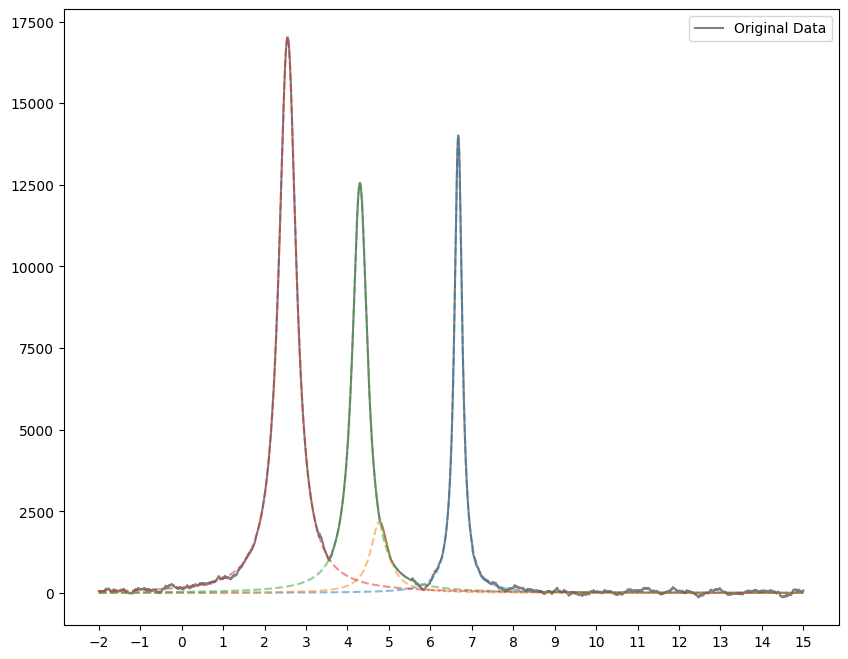

In [33]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 10
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [34]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


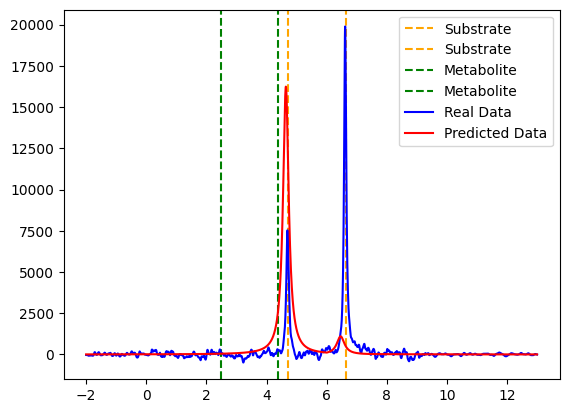

(1, 3000)


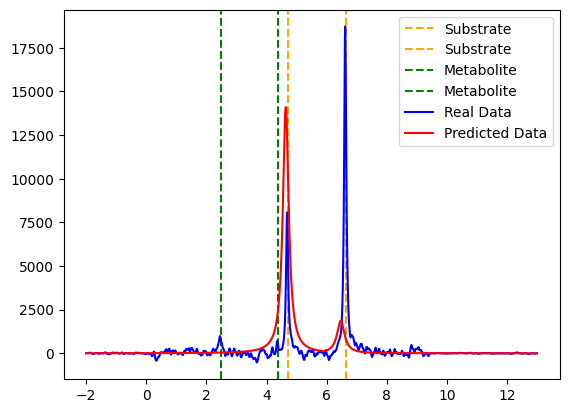

(1, 3000)


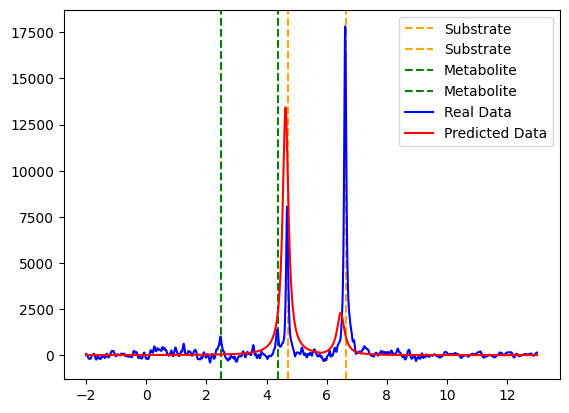

(1, 3000)


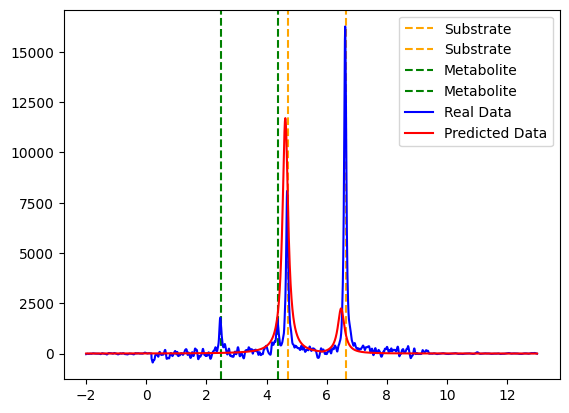

(1, 3000)


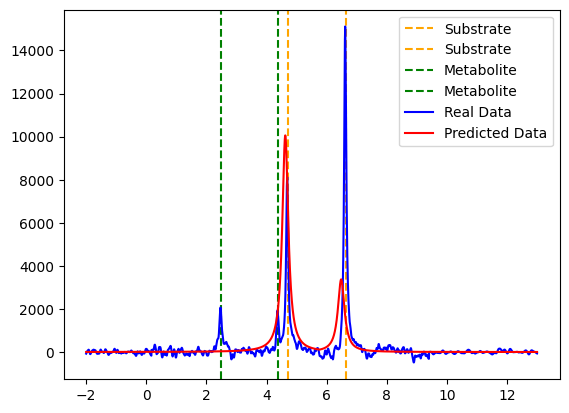

(1, 3000)


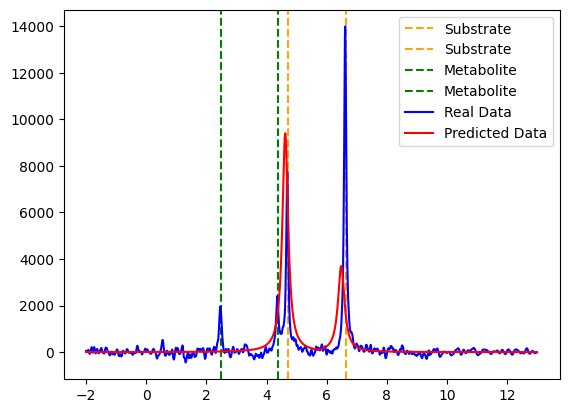

(1, 3000)


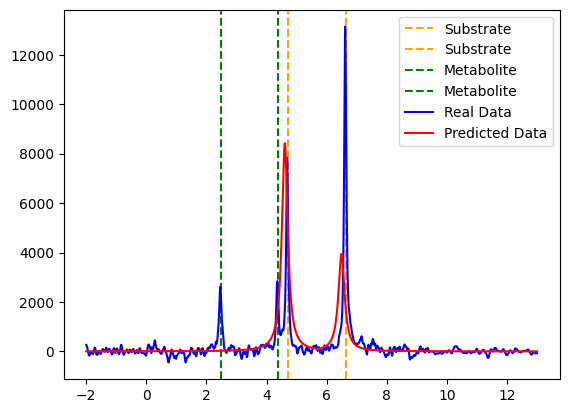

(1, 3000)


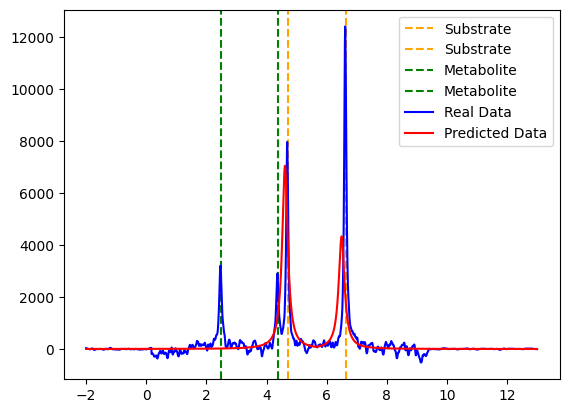

(1, 3000)


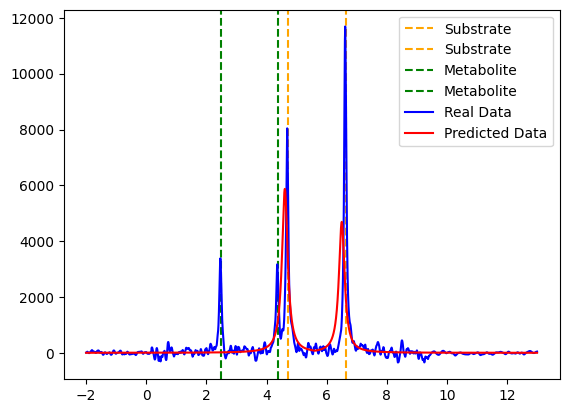

(1, 3000)


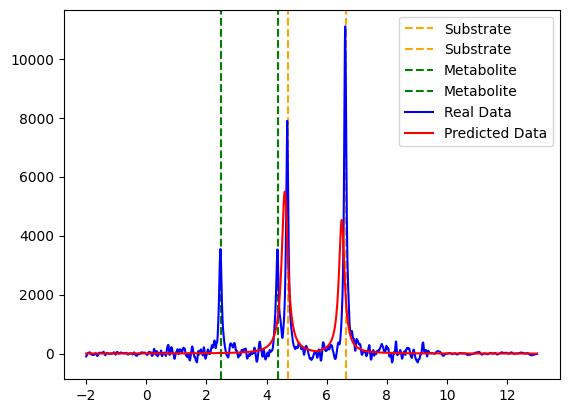

(1, 3000)


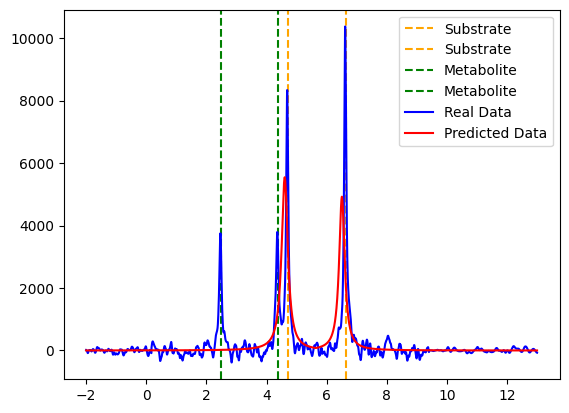

(1, 3000)


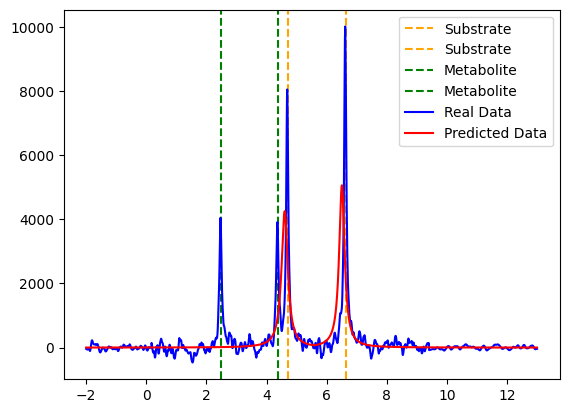

(1, 3000)


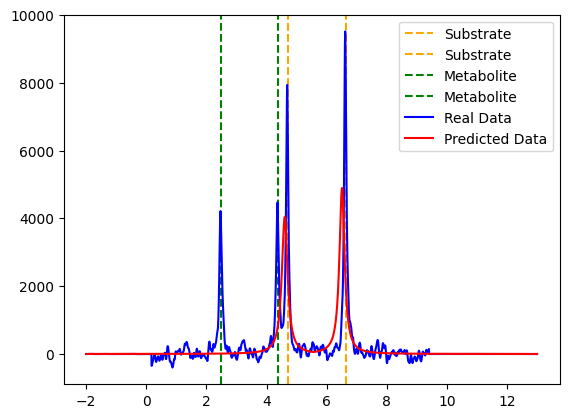

(1, 3000)


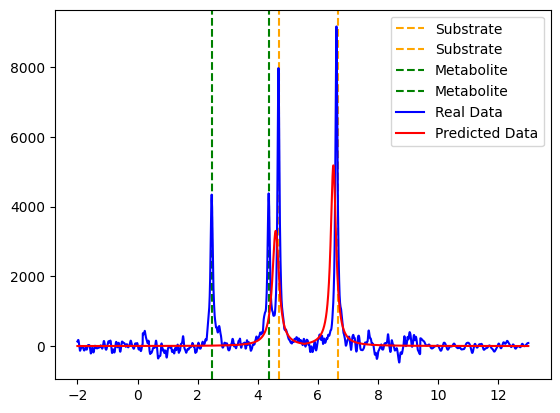

(1, 3000)


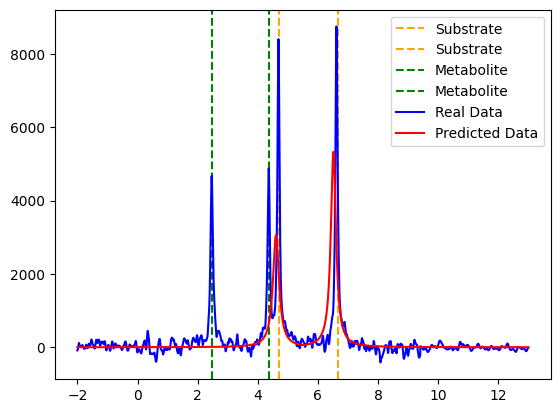

(1, 3000)


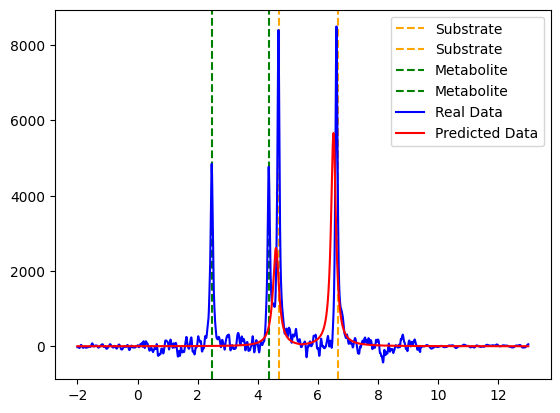

(1, 3000)


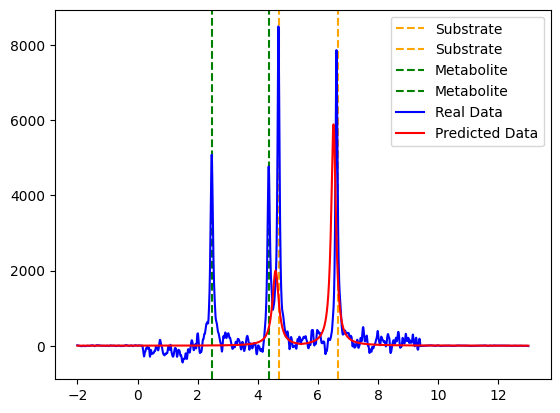

(1, 3000)


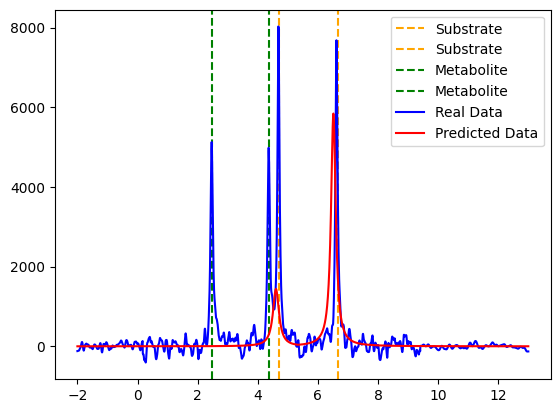

(1, 3000)


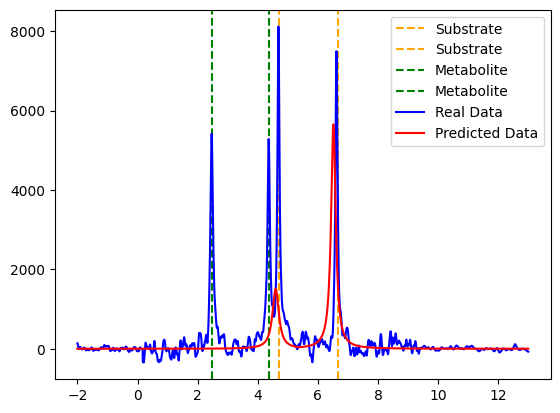

(1, 3000)


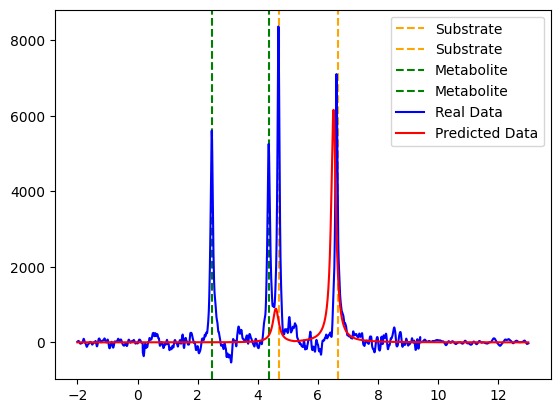

(1, 3000)


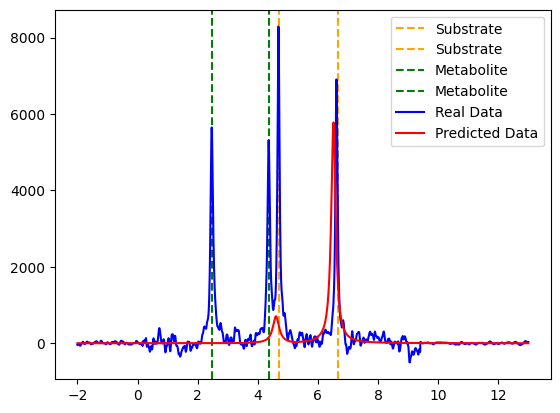

(1, 3000)


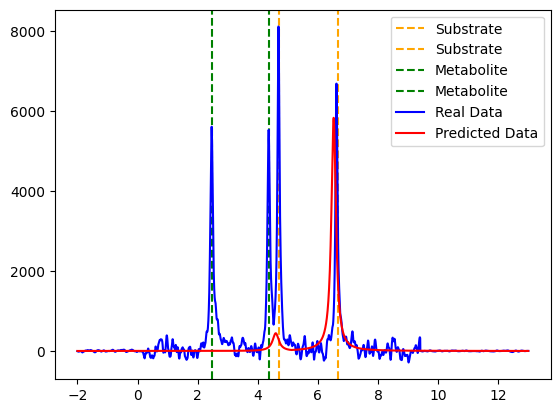

(1, 3000)


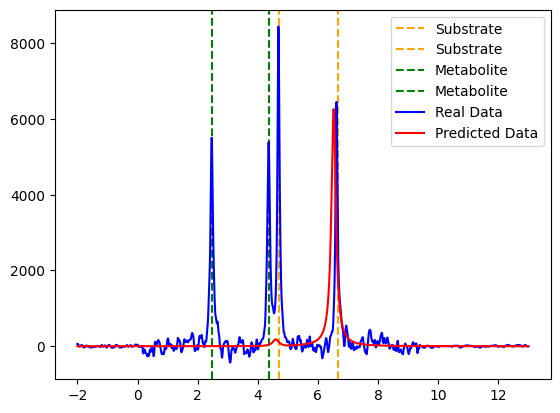

(1, 3000)


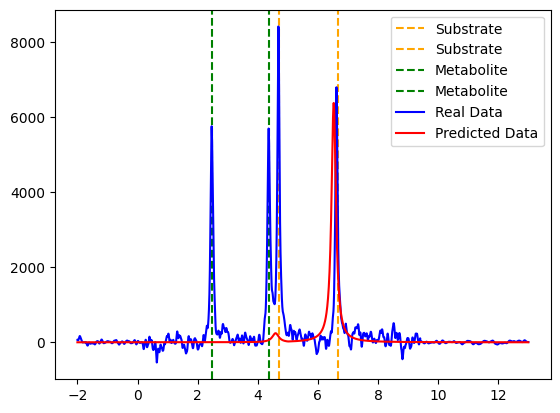

(1, 3000)


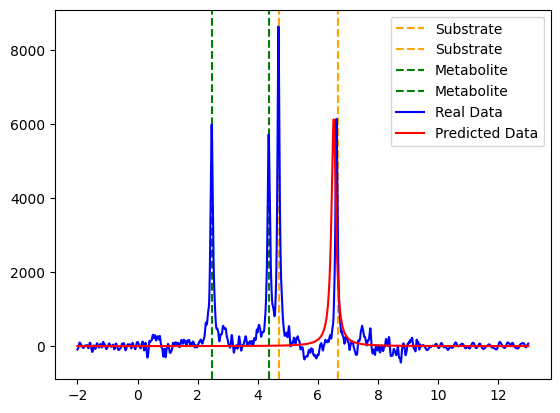

(1, 3000)


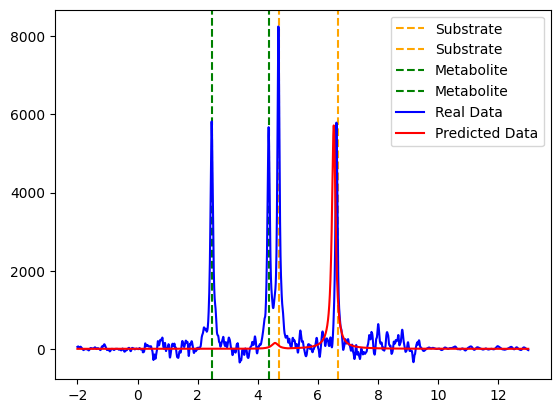

(1, 3000)


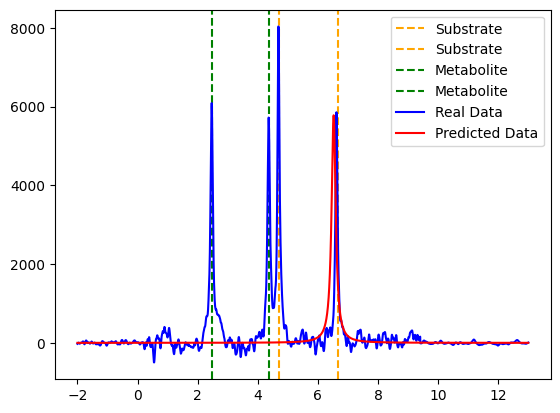

(1, 3000)


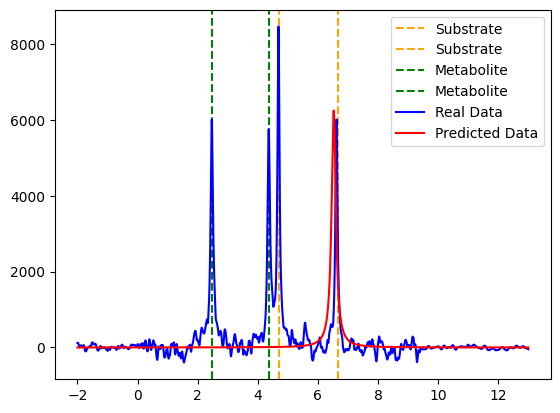

(1, 3000)


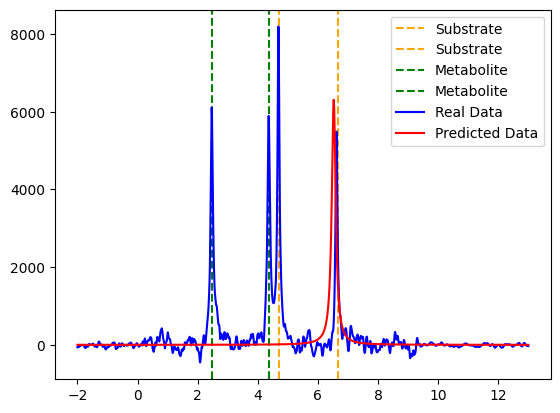

In [35]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 30):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    plt.plot(x_real, y_real, label='Real Data', color='blue')
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')


    plt.legend()
    plt.show()

In [36]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])